In [1]:
#!/usr/bin/python

import simulate_visibilities.Bulm as Bulm
import simulate_visibilities.simulate_visibilities as sv
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
import time, ephem, sys, os, resource, datetime, warnings
import aipy as ap
import os
#os.environ['QT_QPA_PLATFORM']='offscreen'
import sys
import matplotlib.pyplot as plt
import healpy as hp
import healpy.rotator as hpr
import healpy.pixelfunc as hpf
import healpy.visufunc as hpv
import scipy.interpolate as si
import glob
import astropy
from astropy.io import fits

from pyuvdata import UVData, UVCal, UVFITS
import hera_cal as hc
from hera_cal.data import DATA_PATH
from collections import OrderedDict as odict
from pyuvdata import utils as uvutils
import copy
import uvtools as uvt
import linsolve
from hera_cal.datacontainer import DataContainer
from astropy.time import Time
import omnical
import omnical.calibration_omni as omni
from memory_profiler import memory_usage as memuse
from collections import OrderedDict as odict
import pandas
import aipy.miriad as apm
import re
import copy


PI = np.pi
TPI = PI * 2


def pixelize(sky, nside_distribution, nside_standard, nside_start, thresh, final_index, thetas, phis, sizes):
	# thetas = []
	# phis = []
	for inest in range(12 * nside_start ** 2):
		pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis,
						sizes)
		# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside_start, inest, thresh, final_index, thetas, phis)
		# thetas += newt.tolist()
		# phis += newp.tolist()
		# return np.array(thetas), np.array(phis)


def pixelize_helper(sky, nside_distribution, nside_standard, nside, inest, thresh, final_index, thetas, phis, sizes):
	# print "visiting ", nside, inest
	starti, endi = inest * nside_standard ** 2 / nside ** 2, (inest + 1) * nside_standard ** 2 / nside ** 2
	##local mean###if nside == nside_standard or np.std(sky[starti:endi])/np.mean(sky[starti:endi]) < thresh:
	if nside == nside_standard or np.std(sky[starti:endi]) < thresh:
		nside_distribution[starti:endi] = nside
		final_index[starti:endi] = len(thetas)  # range(len(thetas), len(thetas) + endi -starti)
		# return hp.pix2ang(nside, [inest], nest=True)
		newt, newp = hp.pix2ang(nside, [inest], nest=True)
		thetas += newt.tolist()
		phis += newp.tolist()
		sizes += (np.ones_like(newt) * nside_standard ** 2 / nside ** 2).tolist()
		# sizes += (np.ones_like(newt) / nside**2).tolist()

	else:
		# thetas = []
		# phis = []
		for jnest in range(inest * 4, (inest + 1) * 4):
			pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh, final_index, thetas,
							phis, sizes)
			# newt, newp = pixelize_helper(sky, nside_distribution, nside_standard, nside * 2, jnest, thresh)
			# thetas += newt.tolist()
			# phis += newp.tolist()
			# return np.array(thetas), np.array(phis)


def dot(A, B, C, nchunk=10):
	if A.ndim != 2 or B.ndim != 2 or C.ndim != 2:
		raise ValueError("A B C not all have 2 dims: %i %i %i" % (str(A.ndim), str(B.ndim), str(C.ndim)))

	chunk = len(C) / nchunk
	for i in range(nchunk):
		C[i * chunk:(i + 1) * chunk] = A[i * chunk:(i + 1) * chunk].dot(B)
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = A[chunk * nchunk:].dot(B)


def ATNIA(A, Ni, C, nchunk=20):  # C=AtNiA
	if A.ndim != 2 or C.ndim != 2 or Ni.ndim != 1:
		raise ValueError("A, AtNiA and Ni not all have correct dims: %i %i %i"%(A.ndim, C.ndim, Ni.ndim))

	expected_time = 1.3e-11 * (A.shape[0]) * (A.shape[1])**2
	print "Estimated time for A %i by %i"%(A.shape[0], A.shape[1]), expected_time, "minutes",
	sys.stdout.flush()

	chunk = len(C) / nchunk
	for i in range(nchunk):
		ltm = time.time()
		C[i * chunk:(i + 1) * chunk] = np.einsum('ji,jk->ik', A[:, i * chunk:(i + 1) * chunk] * Ni[:, None], A)
		if expected_time >= 1.:
			print "%i/%i: %.1fmins"%(i, nchunk, (time.time() - ltm)/60.),
			sys.stdout.flush()
	if chunk * nchunk < len(C):
		C[chunk * nchunk:] = np.einsum('ji,jk->ik', A[:, chunk * nchunk:] * Ni[:, None], A)


def solve_phase_degen(data_xx, data_yy, model_xx, model_yy, ubls, plot=False):#data should be time by ubl at single freq. data * phasegensolution = model
	if data_xx.shape != data_yy.shape or data_xx.shape != model_xx.shape or data_xx.shape != model_yy.shape or data_xx.shape[1] != ubls.shape[0]:
		raise ValueError("Shapes mismatch: %s %s %s %s, ubl shape %s"%(data_xx.shape, data_yy.shape, model_xx.shape, model_yy.shape, ubls.shape))
	A = np.zeros((len(ubls) * 2, 2))
	b = np.zeros(len(ubls) * 2)

	nrow = 0
	for p, (data, model) in enumerate(zip([data_xx, data_yy], [model_xx, model_yy])):
		for u, ubl in enumerate(ubls):
			amp_mask = (np.abs(data[:, u]) > (np.median(np.abs(data[:, u])) / 2.))
			A[nrow] = ubl[:2]
			b[nrow] = omni.medianAngle(np.angle(model[:, u] / data[:, u])[amp_mask])
			nrow += 1
	phase_cal = omni.solve_slope(np.array(A), np.array(b), 1)
	if plot:
		plt.hist((np.array(A).dot(phase_cal)-b + PI)%TPI-PI)
		plt.title('phase fitting error')
		plt.show()

	#sooolve
	return phase_cal

class LastUpdatedOrderedDict(odict):
	'Store items in the order the keys were last added'

	def __setitem__(self, key, value):
		if key in self:
			del self[key]
		odict.__setitem__(self, key, value)

def S_casa_v_t(v, t = 2015.5):		
	S_0 = 2190.294 #S_casA_1GHz
	alpha =  0.725
	belta = 0.0148
	tau = 6.162*1.e-5

	a = -0.00633 #+-0.00024 year-1 
	b = 0.00039 #+-0.00008 year -1
	c = 1.509*1.e-7 #+-0.162*1.e-7 year-1
	
	v *= 1.e-3
	
	#print(v) # from MHz to GHz
	#print(t) # in decimal year
	
	S_casa_v = S_0 * v**(-alpha + belta * np.log(v)) * np.exp(-tau * v**(-2.1)) #S_0: 2015.5
	d_speed_log_v = a + b * np.log(v) + c * v**(-2.1) #a,b,c: 2005.0
	S_casa_v_t = np.exp((t - 2015.5) * d_speed_log_v + np.log(S_casa_v))
	
	#print(d_speed_log_v)
	
	return S_casa_v_t
	
def S_cyga_v(v, t = 2005):
	S_cyga_v = 3.835 * 1.e5 * v**(-0.718) * np.exp(-0.342 * (21.713/v)**2.1)
	
	return S_cyga_v



INSTRUMENT = ''

In [2]:
#####commandline inputs#####
if len(sys.argv) == 1:
	INSTRUMENT = 'hera47'
else:
	INSTRUMENT = sys.argv[1]#'miteor'#'mwa'#'hera-47''paper'

INSTRUMENT = 'hera47' #'hera47'; 'miteor'
print INSTRUMENT

tag = '-ampcal-' #'-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.

AtNiA_only = False
if len(sys.argv) > 3 and sys.argv[3][:5] == 'atnia':
	AtNiA_only = True
	pixel_scheme_number = int(sys.argv[3][5:])
	
simulation_opt = 1

plotcoord = 'CG'
baseline_safety_factor = 10.#max_ubl = 1.4*lambda/baseline_safety_factor
crosstalk_type = 'autocorr'
#pixel_directory = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'

plot_pixelization = True and not AtNiA_only
plot_projection = True and not AtNiA_only
plot_data_error = True and not AtNiA_only

force_recompute = False
force_recompute_AtNiAi_eig = False
force_recompute_AtNiAi = False
force_recompute_S = False
force_recompute_SEi = False

C = 299.792458
kB = 1.3806488 * 1.e-23

try:
	__file__
except NameError:
	#script_dir = '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/simulate_visibilities/scripts'
	script_dir = os.path.join(DATA_PATH, '../../../simulate_visibilities/scripts')
	pixel_directory = script_dir
	print 'Run IPython'
else:
	script_dir = os.path.dirname(os.path.realpath(__file__))
	pixel_directory = script_dir
	print 'Run Python'


hera47
Run IPython


In [3]:
len(sys.argv)

3

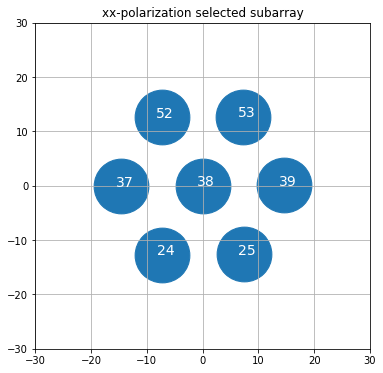

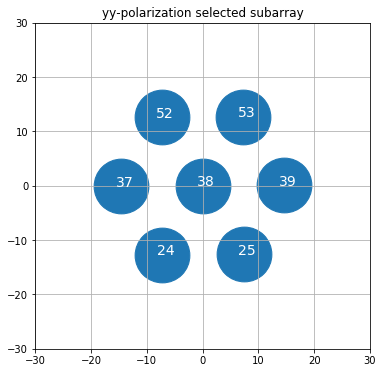

>>>>>>Used nUBL = 9, nt = 60.
Frequencies: 
[ 50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.
  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.
  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.
  92.  93.  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119.
 120. 121. 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133.
 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147.
 148. 149. 150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161.
 162. 163. 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175.
 176. 177. 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189.
 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203.
 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214. 215. 216. 217.
 218. 219. 220. 221. 222. 223. 224. 225. 226. 227. 228. 229. 230. 231.
 232. 233. 234. 235. 236. 237. 23

In [4]:
####################################################
################data file and load beam##############
####################################################
if INSTRUMENT == 'miteor':
	Simulation = True
	Use_SimulatedData = False
	Use_Simulation_noise = False
	
	sys.stdout.flush()
	S_type = 'dyS_lowadduniform_lowI' #'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data

	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2#.1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2#.2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32
	nside_standard = 32 # Determine the resolution of GSM of sky

	pre_calibrate = True
	pre_ampcal = ('qC' in tag)
	pre_phscal = True
	pre_addcal = True
	fit_for_additive = False
	nside_beamweight = 16 # Determin shape of A matrix
	
	Integration_Time = 144 # seconds
	Frequency_Bin = 0.75*1.e6 # Hz
	
	lat_degree = 45.2977
	lst_offset = 5.#lsts will be wrapped around [lst_offset, 24+lst_offset]
#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2016_01_20_avg'#'_seccasa.rad'#
		vartag = '_2016_01_20_avgx100'#''#
	else:
		datatag = '_2016_01_20_avg2_unpollock'#'_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2016_01_20_avg2_unpollock'#'_2016_01_20_avg_unpollockx100'#''#
#	datadir = '/home/omniscope/data/GSM_data/absolute_calibrated_data/'
	datadir = script_dir + '/../Output/'
	antpairs = None
	# deal with beam: create a callable function of the form y(freq) in MHz and returns 2 by npix
	
	
	############################################ Load Beam and Visibility Data ###########################################
	vis_freq_list = flist = np.array([126.83333,127.6667,128.5000,129.3333,130.1667,131.0000,131.8333,132.6667,133.5000,134.3333,135.1667,136.0000,136.8333,137.6667,139.3333,140.0000,141.83333,142.6667,143.5000,144.3333,145.0000,145.1667,146.0000,146.6667,147.5000,148.3333,150.8333,151.6667,152.5000,153.3333,154.1667,155.0000,155.8333,156.0000,156.6667,156.8333,159.3333,161.8333,164.3333,166.8333,167.8333,170.3333,172.8333])
	freq = vis_freq_selected = 150.8333 #MHz
	
	if tag == '-ampcal-':
		tag = '%s-%f'%(INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f'%(INSTRUMENT, freq)
	
	bnside = 64 #Depend on beam pattern data
	freqs = range(110, 200, 10)
	local_beam_unpol = si.interp1d(freqs, np.array([la.norm(np.loadtxt(
		script_dir + '/../data/MITEoR/beam/%s.txt'%(p), skiprows=0).reshape(
		(len(freqs), 12 * bnside ** 2, 4)), axis=-1)**2 for p in ['x', 'y']]).transpose(1, 0, 2), axis=0)
	Plot_Beam = True
	if Plot_Beam:
		plt.figure(0)
		#ind = np.where(beam_freqs == freq)[0][0]
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
				unit='dBi')
	#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
	#             unit='dBi')
		plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		plt.show(block=False)
		#plt.gcf().clear()
			#plt.clf()
			#plt.close()
			
	time_vis_data = np.array([np.loadtxt(script_dir + '/../data/MITEoR/visibilities/%sMHz_%s%s_A.txt'%(vis_freq_selected,p,p)) for p in ['x','y']])
	
	vis_data = (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex128')
	var_data = time_vis_data[:,1:,3::3]
	
	tlist = time_vis_data[0,1:,0]
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)

	tmask = tmasks['x']&tmasks['y']
	tlist = tlist[tmask]
	nt = nt_used = len(tlist)
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))
	nUBL = int(len(time_vis_data[0,0,:])/3)
	
	ubls = {}
	for p in range(2):
		ubls[['x','y'][p]] = time_vis_data[p,0,1:].reshape((nUBL,3))		
	common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	#manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')

	print '>>>>>>Used nUBL = %i, nt = %i.'%(nUBL_used, nt_used)
	sys.stdout.flush()	
	
	
elif INSTRUMENT == 'hera47':
	Simulation = True
	Use_SimulatedData = False
	Use_Simulation_noise = True
	From_File_Data = True
	Keep_Red = False
	Absolute_Calibration = False
	Absolute_Calibration_red = False
	Absolute_Calibration_mfreq = False
	Absolute_Calibration_dred = False
	Absolute_Calibration_dred_mfreq = True
	PointSource_AbsCal = True
	
	Use_AbsCal = True # Use Model calculated noise which is just fullsim autocorr calculated noise.
	Use_PsAbsCal = False # higher priority over Use_AbsCal and Use_Fullsim_Noise. if comply_ps2mod_autocorr then become just fullsim autocorr calculated noise.
	comply_ps2mod_autocorr = False
	Use_Fullsim_Noise = False # Use fullsim autocorr calculated noise.
	
	Replace_Data = True
	
	pre_calibrate = True
	tag = '-ampcal-' if pre_calibrate else '' #'-ampcal-' #sys.argv[2]; if use real uncalibrated data, set tag = '-ampcal-' for amplitude calibration.
	pre_ampcal = ('ampcal' in tag)
	pre_phscal = True
	pre_addcal = True
	fit_for_additive = True
	
	Add_S_diag = True
	Add_Rcond = False
	
	sys.stdout.flush()
	
	lat_degree = -30.72153 #lon='21:25:41.9' lat='-30:43:17.5'
	lst_offset = 1.43#lsts will be wrapped around [lst_offset, 24+lst_offset]

	Integration_Time = 11 # seconds
	Frequency_Bin = 1.625*1.e6 # Hz

	S_type = 'dyS_lowadduniform_maxI' if Add_S_diag else 'no_use' #'dyS_lowadduniform_minI', 'dyS_lowadduniform_I', 'dyS_lowadduniform_lowI', 'dyS_lowadduniform_lowI'#'none'#'dyS_lowadduniform_Iuniform'  #'none'# dynamic S, addlimit:additive same level as max data; lowaddlimit: 10% of max data; lowadduniform: 10% of median max data; Iuniform median of all data

	seek_optimal_threshs = False and not AtNiA_only
	dynamic_precision = .2#.1#ratio of dynamic pixelization error vs data std, in units of data, so not power
	thresh = 2#.2#2.#.03125#
	valid_pix_thresh = 1.e-4
	nside_start = 32
	nside_standard = 32 # resolution of sky
	nside_beamweight = 16 # A matrix shape
	bnside = 64 # beam pattern data resolution
	
	
#	# tag = "q3AL_5_abscal"  #"q0AL_13_abscal"  #"q1AL_10_abscal"'q3_abscalibrated'#"q4AL_3_abscal"# L stands for lenient in flagging
	if 'ampcal' in tag:
		datatag = '_2018_'#'_seccasa.rad'#
		vartag = '_2018_'#''#
	else:
		datatag = '_2018_ampcaled_'#'_2016_01_20_avg_unpollock'#'_seccasa.rad'#
		vartag = '_2018_ampcaled_'#'_2016_01_20_avg_unpollockx100'#''#
	datadir = script_dir + '/../Output/'
	antpairs = None
	
	#######################################################################################################
	##################################### Load Visibility Data ###########################################
	# specify model file and load into UVData, load into dictionary
	Small_ModelData = True
	Model_Calibration = False
	
	model_fname = {}
	model = {}
	mflags = {}
	mantpos = {}
	mant = {}
	model_freqs = {}
	model_times = {}
	model_lsts = {}
	model_pols = {}
	data_fname = {}
	data_fname_full = {}
	dflags = {}
	data = {}
	antpos = {}
	ants = {}
	data_freqs = {}
	data_times = {}
	data_lsts = {}
	data_pols = {}
	
	fulldflags = {}
	
	if Small_ModelData:
		if Model_Calibration:
			model_fname = {}
			model = mflags = mantpos = mant = model_freqs = model_times = model_lsts = model_pols = {}
			for i in range(2):
				model_fname[i] = os.path.join(DATA_PATH, "zen.2458042.12552.%s.HH.uvXA"%['xx','yy'][i]) #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
				#model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
				(model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i],
				 model_pols[i]) = hc.abscal.UVData2AbsCalDict(model_fname[i], return_meta=True)
			
#			data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#			(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#			 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
		
		# specify data file and load into UVData, load into dictionary
		for i in range(2):
			data_fname[i] = os.path.join(DATA_PATH, "zen.2458043.12552.%s.HH.uvORA"%['xx', 'yy'][i]) #zen.2457698.40355.xx.HH.uvcA
			if i == 1:
				try:
					#data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
					if not os.path.isfile(data_fname[i]):
						data_fname[1] = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
				except:
					pass
			data_fname_full[i] = os.path.join(DATA_PATH, 'Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i])
			(data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], 
			 data_pols[i]) = hc.abscal.UVData2AbsCalDict(data_fname[i], return_meta=True)
			
#		try:
#			data_fname_yy = os.path.join(DATA_PATH, "zen.2458043.12552.yy.HH.uvORA") #zen.2457698.40355.yy.HH.uvcA
#			if not os.path.isfile(data_fname_yy):
#				data_fname_yy = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#		except:
#			pass
#		data_fname_yy_full = "/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.yy.HH.uvOR"
#		(data_yy, dflags[1], antpos_yy, ants_yy, data_freqs_yy, data_times_yy, data_lsts_yy, 
#		 data_pols_yy) = hc.abscal.UVData2AbsCalDict(data_fname_yy, return_meta=True)
		
		
	else:
		if Model_Calibration:
#			model_fname1 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv'
#			model_fname2 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv'
#			model_fname1_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.yy.HH.uv'
#			model_fname2_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.yy.HH.uv'
#			(model, mflags, antpos, ants, model_freqs, model_times, model_lsts,
#			 model_pols) = hc.abscal.UVData2AbsCalDict(model_fname1, return_meta=True) # also can try model_fname2
#			(model_yy, mflags_yy, antpos_yy, ants_yy, model_freqs_yy, model_times_yy, model_lsts_yy,
#			 model_pols_yy) = hc.abscal.UVData2AbsCalDict(model_fname2, return_meta=True) # also can try model_fname2
			
			model_fname_dred = {}
			model_dred = mflags_dred = mantpos_dred = mant_dred = model_freqs_dred = model_times_dred = model_lsts_dred = model_pols_dred = {}
			for i in range(2):
				#model_fname[i] = "/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.12552.%s.HH.uv"%['xx','yy'][i]#/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv
				model_fname[i] = os.path.join(DATA_PATH, 'Observation-1192115507/2458042/zen.2458042.12552.%s.HH.uv'%['xx','yy'][i])
				#model_fname[1] = os.path.join(DATA_PATH, "zen.2458042.12552.xx.HH.uvXA") #/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv
#				(model_dred[i], mflags_dred[i], mantpos_dred[i], mants_dred[i], model_freqs_dred[i], model_times_dred[i], model_lsts_dred[i],
#				 model_pols_dred[i]) = hc.abscal.UVData2AbsCalDict(model_fname_dred[i], return_meta=True)
				(model[i], mflags[i], mantpos[i], mants[i], model_freqs[i], model_times[i], model_lsts[i],
				 model_pols[i]) = hc.abscal.UVData2AbsCalDict(model_fname[i], return_meta=True)
			
#			data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#			(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#			 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
		
		# specify data file and load into UVData, load into dictionary
		
		for i in range(2):
			data_fname[i] = os.path.join(DATA_PATH, 'Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i])
			#data_fname[i] = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.%s.HH.uvOR'%['xx', 'yy'][i]
			(data[i], dflags[i], antpos[i], ants[i], data_freqs[i], data_times[i], data_lsts[i], 
			 data_pols[i]) = hc.abscal.UVData2AbsCalDict(data_fname[i], return_meta=True)
		
#		data_fname_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192287662/2458043/zen.2458043.12552.yy.HH.uvOR'
#		(data_yy, dflags_yy, antpos_yy, ants_yy, data_freqs_yy, data_times_yy, data_lsts_yy, 
#		 data_pols_yy) = hc.abscal.UVData2AbsCalDict(data_fname_yy, return_meta=True)
		
		
#	model, interp_flags = hc.abscal.interp2d_vis(model, model_lsts, model_freqs, data_lsts, data_freqs) #interpolate model onto time & freq axes of data
#	# instantiate class
#	AC = hc.abscal.AbsCal(model, data, antpos=antpos, wgts=wgts, freqs=data_freqs) #Instantiate AbsCal object
	
	################# Select Frequency ####################
	flist = {}
	index_freq = {}
	antloc = {}
	dflags_sf = {} #single frequency
	for i in range(2):
		flist[i] = np.array(data_freqs[i])/10**6
		try:
			index_freq[i] = np.where(flist[i]==150)[0][0]
	#		index_freq = 512
		except:
			index_freq[i] = len(flist[i])/2
	
	for i in range(2):
		dflags_sf[i] = LastUpdatedOrderedDict()
		for key in dflags[i].keys():
			dflags_sf[i][key] = dflags[i][key][:,index_freq[i]]
	
	# ant locations
	for i in range(2): 
		antloc[i] = np.array(map(lambda k: antpos[i][k], ants[i]))
#	antloc_yy = np.array(map(lambda k: antpos_yy[k], ants_yy))
	
	# plot sub-array HERA layout
	for j in range(2):
		plt.figure(100000+5*j, figsize=(6,6))
		plt.grid()
		plt.scatter(antloc[j][:, 0], antloc[j][:, 1], s=3000)
		_ = [plt.text(antloc[j][i, 0]-1, antloc[j][i, 1], str(ants[j][i]), fontsize=14, color='w') for i in range(len(antloc[j]))]
		plt.title('%s-polarization selected subarray'%['xx', 'yy'][j])
		plt.xlim(-30, 30)
		plt.ylim(-30, 30)
		plt.show(block=False)
		#plt.cla()

	############################## Autocorrelation #################################
	xxfile = data_fname[0] if not Small_ModelData else data_fname_full[0]
	yyfile = data_fname[1] if not Small_ModelData else data_fname_full[1]
	
	# Load data for autocorrelation calculating
	uvd_xx = UVData()
	uvd_xx.read_miriad(xxfile)
	uvd_xx.ants = np.unique(np.concatenate([uvd_xx.ant_1_array, uvd_xx.ant_2_array]))
	uvd_yy = UVData()
	uvd_yy.read_miriad(yyfile)
	uvd_yy.ants = np.unique(np.concatenate([uvd_yy.ant_1_array, uvd_yy.ant_2_array]))

	# Get metadata
	freqs = uvd_xx.freq_array.squeeze() / 1e6
	times = uvd_xx.time_array.reshape(uvd_xx.Ntimes, uvd_xx.Nbls)[:, 0]
	jd_start = np.floor(times.min())
	Nfreqs = len(freqs)
	Ntimes = len(times)

	# get redundant info
	aa = hc.utils.get_aa_from_uv(uvd_xx)
	info = hc.omni.aa_to_info(aa)
	red_bls = np.array(info.get_reds())
	ants = sorted(np.unique(np.concatenate(red_bls)))
	Nants = len(ants)
	Nside = int(np.ceil(np.sqrt(Nants)))
	Yside = int(np.ceil(float(Nants)/Nside))
	
	try:
		plot_data_autocorr = False
		if plot_data_autocorr: # at specific frequency
			### plot autos
			t_index = 0
			jd = times[t_index]
			utc = Time(jd, format='jd').datetime

			xlim = (-50, Nfreqs+50)
			ylim = (-10,30)

			fig, axes = plt.subplots(Yside, Nside, figsize=(14,14), dpi=75)
			fig.subplots_adjust(wspace=0.2, hspace=0.2)
			fig.suptitle("JD = {0}, time = {1} UTC".format(jd, utc), fontsize=14)
			fig.tight_layout(rect=(0, 0, 1, 0.95))

			k = 0
			for i in range(Yside):
				for j in range(Nside):
					ax = axes[i,j]
					ax.set_xlim(xlim)
					ax.set_ylim(ylim)
					if k < Nants:
						px, = ax.plot(10*np.log10(np.abs(uvd_xx.get_data((ants[k], ants[k]))[t_index])), color='steelblue', alpha=0.75, linewidth=3)
						py, = ax.plot(10*np.log10(np.abs(uvd_yy.get_data((ants[k], ants[k]))[t_index])), color='darkorange', alpha=0.75, linewidth=3)
						ax.grid(True, which='both')
						ax.set_title(str(ants[k]), fontsize=14)
						if k == 0:
							ax.legend([px, py], ['East', 'North'], fontsize=12)
					else:
						ax.axis('off')
					if j != 0:
						ax.set_yticklabels([])
					else:
						[t.set_fontsize(12) for t in ax.get_yticklabels()]
						ax.set_ylabel(r'$10\cdot\log_{10}$ amplitude', fontsize=14)
					if i != Yside-1:
						ax.set_xticklabels([])
					else:
						[t.set_fontsize(12) for t in ax.get_xticklabels()]
						ax.set_xlabel('freq channel', fontsize=14)

					k += 1
			plt.show(block=False)
		
	except:
		pass
		
	autocorr_data_mfreq = {} #np.zeros((2, Ntimes, Nfreqs))
	autocorr_data_mfreq[0] = np.mean(np.array([np.abs(uvd_xx.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
	autocorr_data_mfreq[1] = np.mean(np.array([np.abs(uvd_yy.get_data((ants[k], ants[k]))) for k in range(Nants)]), axis=0)
	autocorr_data =  {}
	for i in range(2):
		autocorr_data[i] = autocorr_data_mfreq[i][:,index_freq[i]]
		
	if Replace_Data:	
		findex = np.where(freqs==150)
		findex_list = {}
		autocorr_data_mfreq_ff = {}
		for i in range(2):
			findex_list[i] = np.array([np.where(freqs==flist[i][j])[0][0] for j in range(len(flist[i]))])
			
		data_ff = {}
		dflags_ff = {}
		for i in range(2):
			data_ff[i] = LastUpdatedOrderedDict()
			dflags_ff[i] = LastUpdatedOrderedDict()
			for id_key, key in enumerate(dflags[i].keys()):
				#key[2] = 'xx' if i == 0 else 'yy'
				data_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = uvd_xx.get_data((key[0], key[1]))[:,findex_list[i]] if i == 0 else uvd_yy.get_data((key[0], key[1]))[:,findex_list[i]]
				autocorr_data_mfreq_ff[i] = autocorr_data_mfreq[i][:, findex_list[i]]
				dflags_ff[i][key[0], key[1], 'xx' if i == 0 else 'yy'] = dflags[i][key]
						#del data_ff[dflags[i].keys()[id_key]]
		
		data = copy.deepcopy(data_ff)
		dflags = copy.deepcopy(dflags_ff)
		autocorr_data_mfreq = copy.deepcopy(autocorr_data_mfreq_ff)	
		
		del(data_ff)
		del(dflags_ff)
		del(autocorr_data_mfreq_ff)
	#del(autocorr_data_mfreq)
		
	del(uvd_xx)
	del(uvd_yy)
	del(aa)
	del(info)
	
	
	
#	plt.figure(100005, figsize=(6,6))
#	plt.grid()
#	plt.scatter(antloc_yy[:, 0], antloc_yy[:, 1], s=3000)
#	_ = [plt.text(antloc_yy[i, 0]-1, antloc_yy[i, 1], str(ants_yy[i]), fontsize=14, color='w') for i in range(len(antloc_yy))]
#	plt.title('yy polarization selected subarray')
#	plt.xlim(-30, 30)
#	plt.ylim(-30, 30)
#	plt.show(block=False)
	
	
	#bls = odict([(x, antpos[x[0]] - antpos[x[1]]) for x in model.keys()])
	bls = [[],[]]
	for i in range(2):
		bls[i] = odict([(x, antpos[i][x[0]] - antpos[i][x[1]]) for x in data[i].keys()])
		#bls[1] = odict([(y, antpos_yy[y[0]] - antpos_yy[y[1]]) for y in data_yy.keys()])
		bls = np.array(bls)
	
	bsl_coord = [[],[]]
	bsl_coord_x = bsl_coord[0] = np.array([bls[0][index] for index in bls[0].keys()])
	bsl_coord_y = bsl_coord[1] = np.array([bls[1][index] for index in bls[1].keys()])
	#bsl_coord_x=bsl_coord_y=bsl_coord
	bsl_coord = np.array(bsl_coord)
	
	
	########################### Visibility ##############################
	vis_data_mfreq = {}
	#vis_data_Omni_mfreq = np.array([data_omni[bslkeys] for bslkeys in data_omni.keys()], dtype='complex128').transpose((2,1,0)) if Model_Calibration else None
	for i in range(2):
		vis_data_mfreq[i] = np.array([data[i][bslkeys] for bslkeys in data[i].keys()], dtype='complex128').transpose((2,1,0))
#	vis_data_mfreq = np.array([data_yy[bslkeys] for bslkeys in data_yy.keys()], dtype='complex128').transpose((2,1,0))
	
#	vis_data_mfreq = np.zeros((2,vis_data_xx_mfreq.shape[0], vis_data_xx_mfreq.shape[1], vis_data_xx_mfreq.shape[2]), dtype='complex128')
#	vis_data_mfreq[0] = vis_data_xx_mfreq
#	vis_data_mfreq[1] = vis_data_yy_mfreq

	vis_freq_selected = freq = flist[0][index_freq[0]] #MHz For Omni:  0:100, 16:125, 32:150, 48:175;;; For Model:  512:150MHz   Choose xx as reference
	#vis_data = np.zeros((2,vis_data_mfreq.shape[2], vis_data_xx_mfreq.shape[3]), dtype='complex128')
	vis_data = {}
	for i in range(2):
		vis_data[i] = vis_data_mfreq[i][index_freq[i], :, :] # [pol][ freq, time, bl] 

	#del(vis_data_mfreq)
		

	################################## Unique Base Lines and Remove Redundancy ########################################
	
#	np.array(omnical.arrayinfo.compute_reds(antloc)) # Alternate way to compute.
	Ubl_list_raw = [[],[]]
	Ubl_list = [[],[]]
	ant_pos = [[],[]]
	
	Nubl_raw = np.zeros(2, dtype=int)
	times_raw = np.zeros(2, dtype=int)
	times_raw_list = [[],[]]
	redundancy = [[],[]]
	bsl_coord_dred = [[],[]]
	vis_data_dred = [[],[]]
	vis_data_dred_mfreq = [[],[]]
	
	for i in range(2):
		Ubl_list_raw[i] = np.array(omnical.arrayinfo.compute_reds_total(antloc[i])) ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
	#Ubl_list_raw[1] = np.array(omnical.arrayinfo.compute_reds_total(antloc_yy)) ## Note that a new function has been added into omnical.arrayinfo as "compute_reds_total" which include all ubls not only redundant ones.
		ant_pos[i] = antpos[i]
	#ant_pos[1] = antpos_yy
	for i in range(2):
		for i_ubl in range(len(Ubl_list_raw[i])):
			list_bsl = []
			for i_ubl_pair in range(len(Ubl_list_raw[0][i_ubl])):
				try:
					list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s'%['xx','yy'][i])))
				except:
					list_bsl.append(bls[i].keys().index((ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][0]], ant_pos[i].keys()[Ubl_list_raw[i][i_ubl][i_ubl_pair][1]], '%s'%['xx','yy'][1-i])))
			Ubl_list[i].append(list_bsl)
	
	for i in range(2):		
		Nubl_raw[i] = len(Ubl_list[i])
		times_raw[i] = len(data_times[i])
		times_raw_list[i] = data_times[i]
		bsl_coord_dred[i] = np.zeros((Nubl_raw[i], 3))
		vis_data_dred[i] = np.zeros((times_raw[i], Nubl_raw[i]), dtype='complex128')
		vis_data_dred_mfreq[i] = np.zeros((len(flist[i]), times_raw[i], Nubl_raw[i]), dtype='complex128')
	
	try:
		var_data_dred = [[],[]]
		var_data_dred[0] = np.zeros((times_raw[0], Nubl_raw[0]), dtype='complex128')
		var_data_dred[1] = np.zeros((times_raw[1], Nubl_raw[1]), dtype='complex128')
	except:
		pass
		
	
	########################### Average on Redundant baselines #############################
	#data_dred = {}
	dflags_dred = {}
		
	for i in range(2):
		#data_dred[i] = {}
		#dflags_dred[i] = {}
		dflags_dred[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		for i_ubl in range(Nubl_raw[0]):
			vis_data_dred[i][:, i_ubl] = np.mean(vis_data[i].transpose()[Ubl_list[i][i_ubl]].transpose(), axis=1)
			bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[i][i_ubl]], axis=0)
			#if Absolute_Calibration_dred:
			dflags_dred[i][dflags_sf[i].keys()[Ubl_list[i][i_ubl][0]]] = dflags_sf[i][dflags_sf[i].keys()[Ubl_list[i][i_ubl][0]]]
#				if i == 0:
#					#data_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = dflags[dflags.keys()[Ubl_list[i][i_ubl][0]]]
#				else:
#					#data_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = dflags_yy[dflags_yy.keys()[Ubl_list[i][i_ubl][0]]]
			redundancy[i].append(len(Ubl_list[i][i_ubl]))
			try:
				var_data_dred[i][:, i_ubl] = np.mean(var_data[i].transpose()[Ubl_list[i][i_ubl]].transpose(), axis=1)
			except:
				pass
				
				
	#vis_data_dred_mfreq = [[],[]]
	dflags_dred_mfreq = {}
		
	for i in range(2):
		#data_dred_mfreq[i] = {}
		#dflags_dred_mfreq[i] = {}
		dflags_dred_mfreq[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		for i_ubl in range(Nubl_raw[0]):
			vis_data_dred_mfreq[i][:, :, i_ubl] = np.mean(vis_data_mfreq[i][ :, :, Ubl_list[i][i_ubl]], axis=-1)
			#bsl_coord_dred[i][i_ubl] = np.mean(bsl_coord[i][Ubl_list[i][i_ubl]], axis=0)
			#if Absolute_Calibration_dred_mfreq:
			dflags_dred_mfreq[i][dflags[i].keys()[Ubl_list[i][i_ubl][0]]] = dflags[i][dflags[i].keys()[Ubl_list[i][i_ubl][0]]]
#				if i == 0:
#					#data_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags.keys()[Ubl_list[i][i_ubl][0]]] = dflags[dflags.keys()[Ubl_list[i][i_ubl][0]]]
#				else:
#					#data_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = vis_data_dred[i][:, i_ubl]
#					dflags_dred[i][dflags_yy.keys()[Ubl_list[i][i_ubl][0]]] = dflags_yy[dflags_yy.keys()[Ubl_list[i][i_ubl][0]]]
			#redundancy[i].append(len(Ubl_list[i][i_ubl]))
			try:
				var_data_dred[i][:, i_ubl] = np.mean(var_data[i][ :, :, Ubl_list[i][i_ubl]], axis=-1)
			except:
				pass
		

	#wgts_dred = copy.deepcopy(dflags_dred)
		
	
	Del = True
	if Del and not Small_ModelData:
		try:
			#del(red_bls)
			#del(autocorr_data_mfreq)
			#del(vis_data_mfreq)
			del(var_data_mfreq)
				
		except:
			pass
			
		try:
			if not Keep_Red:
				del(bsl_coord)
		except:
			pass
	
	sys.stdout.flush()
	
	
	############################### t and f ##########################
	# Using one of the two polarization, which should basically be same from choosing files
	tlist_JD = np.array(data_times[0])
	JD2SI_time = Time(data_times[0], format='jd').datetime
	tlist = np.zeros(len(data_times[0]))
	nt = len(tlist)
	nf = len(flist[0])
	for i in range(len(data_times[0])):
		tlist[i] = si_t = (JD2SI_time[i].hour*3600. + JD2SI_time[i].minute*60. + JD2SI_time[i].second)/3600.
	#	tlist[i] = '%.2f' %si_t
	
	if tag == '-ampcal-':
		tag = '%s-%f'%(INSTRUMENT, freq) + tag
	else:
		tag = '%s-%f'%(INSTRUMENT, freq)
	tmasks = {}
	for p in ['x', 'y']:
		tmasks[p] = np.ones_like(tlist).astype(bool)

	tmask = tmasks['x']&tmasks['y']
	tlist = tlist[tmask]
	lsts = data_lsts[0][tmask]
	nt_used = len(tlist)
	nf_used = len(flist[0])
	jansky2kelvin = 1.e-26 * (C / freq) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2))
	jansky2kelvin_mfreq = {}
	for j in range(2):
		jansky2kelvin_mfreq[j] = np.array([1.e-26 * (C / flist[j][i]) ** 2 / 2 / kB / (4 * PI / (12 * nside_standard ** 2)) for i in range(len(flist[j]))])
	
	############################## Common UBL ###########################
	ubls = {}
	bls_red = {}
	#freq = 150
#	nside_standard = 32
	baseline_safety_factor = 3.
	
	nBL_red = len(bsl_coord_x)
	for p in ['x', 'y']:
		#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
		bls_red[p] = globals()['bsl_coord_' + p]
	common_bls_red = np.array([u for u in bls_red['x'] if (u in bls_red['y'] or -u in bls_red['y'])])
	
	used_common_bls_red = common_bls_red[la.norm(common_bls_red, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nBL_red_used = len(used_common_bls_red)
	
	if Keep_Red:
		nUBL = len(bsl_coord_x)
		for p in ['x', 'y']:
			#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
			ubls[p] = globals()['bsl_coord_' + p]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
	else:
		nUBL = len(bsl_coord_dred[0])
		nUBL_yy = len(bsl_coord_dred[1])
		for i in range(2):
			p = ['x', 'y'][i]
			ubls[p] = bsl_coord_dred[i]
		common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
	#common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
	#manually filter UBLs
	used_common_ubls = common_ubls[la.norm(common_ubls, axis=-1) / (C / freq) <= 1.4 * nside_standard / baseline_safety_factor]#[np.argsort(la.norm(common_ubls, axis=-1))[10:]]     #remove shorted 10
	nUBL_used = len(used_common_ubls)
	ubl_index = {}  # stored index in each pol's ubl for the common ubls
	for p in ['x', 'y']:
		ubl_index[p] = np.zeros(nUBL_used, dtype='int')
		for i, u in enumerate(used_common_ubls):
			if u in ubls[p]:
				ubl_index[p][i] = np.argmin(la.norm(ubls[p] - u, axis=-1)) + 1
			elif -u in ubls[p]:
				ubl_index[p][i] = - np.argmin(la.norm(ubls[p] + u, axis=-1)) - 1
			else:
				raise Exception('Logical Error')

	print '>>>>>>Used nUBL = %i, nt = %i.'%(nUBL_used, nt_used)
	sys.stdout.flush()
	
	######################### Beam Pattern #############################
	
	filename = script_dir + '/../data/HERA-47/Beam-Dipole/healpix_beam.fits'
	beam_E = fits.getdata(filename, extname='BEAM_E').T #E is east corresponding to X polarization
	beam_nside = hp.npix2nside(beam_E.shape[1])
	beam_freqs = fits.getdata(filename, extname='FREQS')

	print('Frequencies: ')
	print(beam_freqs)
	
	# select only 100-200 MHz data
#	freq_select = np.where((freqs >= 100) & (freqs <=200))[0]
#	beams = beams[:, freq_select]
#	freqs = freqs[freq_select]
#	Nfreqs = len(freqs)

	# take East pol and rotate to get North pol
	Nfreqs = len(beam_freqs)
	beam_theta, beam_phi = hp.pix2ang(64, np.arange(64**2 * 12))
	#R = hp.Rotator(rot=[0,0,-np.pi/2], deg=False)
	R = hp.Rotator(rot=[-np.pi/2,0,0], deg=False)
	beam_theta2, beam_phi2 = R(beam_theta, beam_phi)
	beam_N = np.array(map(lambda x: hp.get_interp_val(x, beam_theta2, beam_phi2), beam_E))
	beam_EN = np.array([beam_E, beam_N])
	beam_EN.resize(2, Nfreqs, 49152)
	
#	# normalize each frequency to max of 1
#	for i in range(beam_EN.shape[-2]):
#		beam_EN[:, i, :] /= beam_EN[:, i, :].max()
	
	local_beam_unpol = si.interp1d(beam_freqs, beam_EN.transpose(1, 0, 2), axis=0)
	

In [5]:
print INSTRUMENT
print tag
#tag = 'ampcal'
print Nants
print Small_ModelData
print data_fname
print len(antloc)

hera47
hera47-150.000000-ampcal-
47
True
{0: '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/zen.2458043.12552.xx.HH.uvORA', 1: '/Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/zen.2458043.12552.xx.HH.uvORA'}
2


In [6]:
print bsl_coord
print red_bls
print len(red_bls)

[[[ 7.35221779e+00 -1.26189069e+01  9.99681658e-02]
  [-2.18634287e+01 -1.27404881e+01  1.89519037e-01]
  [-1.46078417e+01 -5.57878836e-02  2.97754315e-02]
  [-7.25562415e+00 -1.26746948e+01  1.09726883e-01]
  [-2.92156839e+01 -1.11576036e-01  3.95508570e-02]
  [-7.25562404e+00 -1.26746948e+01  1.29743593e-01]
  [ 7.35225495e+00 -1.26289123e+01  1.49984888e-01]
  [-7.25558699e+00 -1.26847002e+01  1.59743605e-01]
  [ 9.66311028e-02 -2.53036069e+01  2.79711773e-01]
  [ 9.66307942e-02 -2.53036071e+01  2.59711771e-01]
  [ 7.35225515e+00 -1.26289121e+01  1.49968180e-01]
  [-2.18634661e+01 -1.27304829e+01  1.39519023e-01]
  [-1.46078419e+01 -5.57879046e-02  9.75871691e-03]
  [ 7.35221790e+00 -1.26189067e+01  9.99514526e-02]
  [-7.25558679e+00 -1.26847002e+01  1.79760320e-01]
  [ 1.47044728e+01 -2.52478190e+01  2.49936341e-01]
  [-1.45112109e+01 -2.53593950e+01  2.89487203e-01]
  [ 2.19600969e+01 -1.25731242e+01  1.20192748e-01]
  [-1.46078419e+01 -5.57881319e-02  2.97921401e-02]
  [ 2.196005

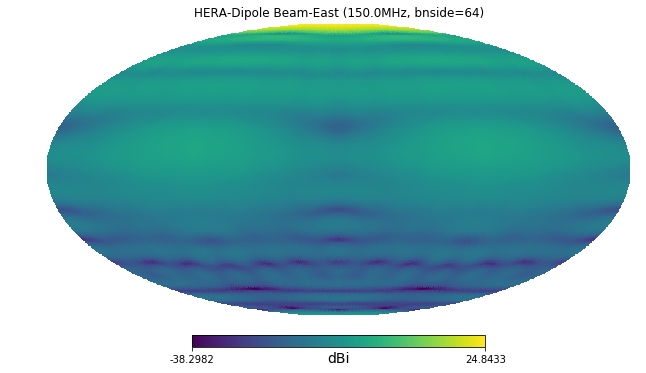

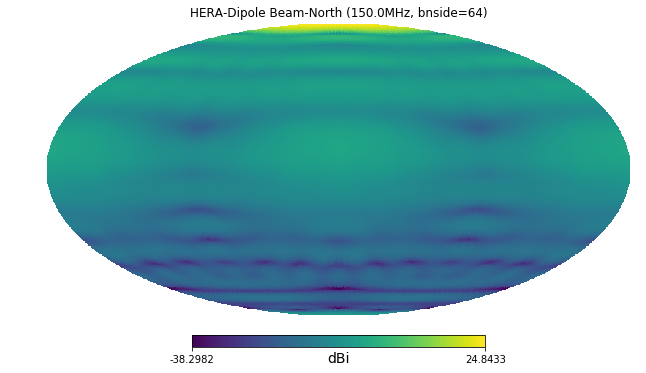

In [7]:

Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()



In [8]:
print local_beam_unpol(150)[0:]
print local_beam_unpol(150)[0:].sum()
print local_beam_unpol(150)[0:].min()
print local_beam_unpol(150)[0:].max()

[[317.35033648 317.36347034 317.36347034 ...   0.45564572   0.45564572
    0.4558748 ]
 [317.36347034 317.36347034 317.35033648 ...   0.45564572   0.4558748
    0.4558748 ]]
98426.09926039288
0.00014797059467877035
317.3634703353978


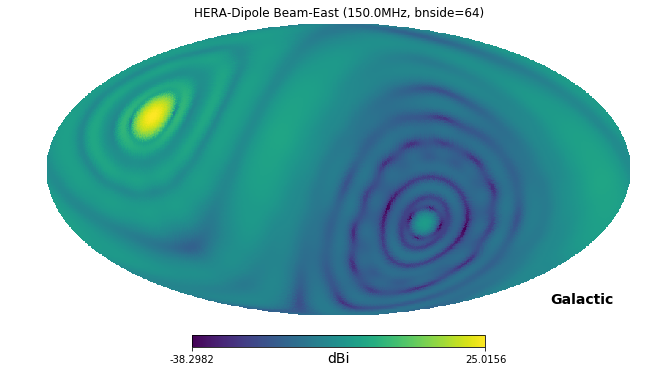

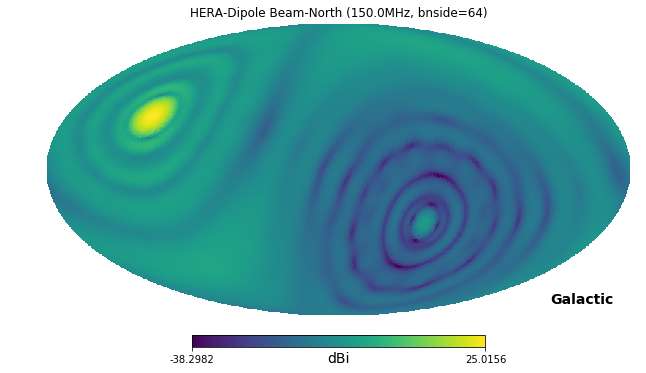

In [9]:
Plot_Beam = True
if Plot_Beam:
    plt.figure(0)
    #ind = np.where(beam_freqs == freq)[0][0]
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[0,:]), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_E[ind,:]), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    hp.mollview(10.0 * np.log10(local_beam_unpol(freq)[1,:]), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
            unit='dBi')
#     hp.mollview(10.0 * np.log10(beam_N[ind,:]), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(beam_freqs[ind], bnside),
#             unit='dBi')
    plt.savefig(script_dir + '/../Output/%s-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
    plt.show(block=False)
    #plt.gcf().clear()
        #plt.clf()
        #plt.close()


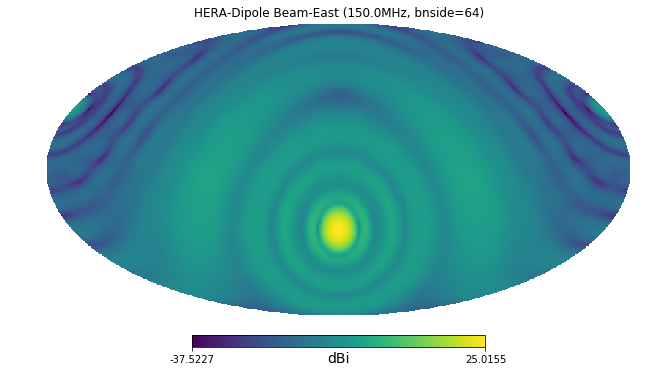

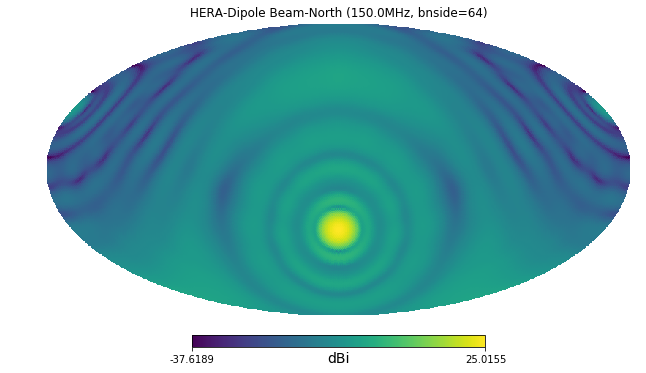

In [10]:
#################
####set up vs and beam
################
vs = sv.Visibility_Simulator()
vs.initial_zenith = np.array([0, lat_degree * PI / 180])  # self.zenithequ
beam_heal_hor_x = local_beam_unpol(freq)[0]
beam_heal_hor_y = local_beam_unpol(freq)[1]
beam_heal_equ_x = sv.rotate_healpixmap(beam_heal_hor_x, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])
beam_heal_equ_y = sv.rotate_healpixmap(beam_heal_hor_y, 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0])

if Absolute_Calibration_dred_mfreq:
	beam_heal_hor_x_mfreq = np.array([local_beam_unpol(flist[0][i])[0] for i in range(nf_used)])
	beam_heal_hor_y_mfreq = np.array([local_beam_unpol(flist[1][i])[1] for i in range(nf_used)])
	beam_heal_equ_x_mfreq = np.array([sv.rotate_healpixmap(beam_heal_hor_x_mfreq[i], 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0]) for i in range(nf_used)])
	beam_heal_equ_y_mfreq = np.array([sv.rotate_healpixmap(beam_heal_hor_y_mfreq[i], 0, PI / 2 - vs.initial_zenith[1], vs.initial_zenith[0]) for i in range(nf_used)])


Plot_Beam = True
if Plot_Beam:
	plt.figure(10)
	#ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-%.2f-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
	plt.show(block=False)

sys.stdout.flush()

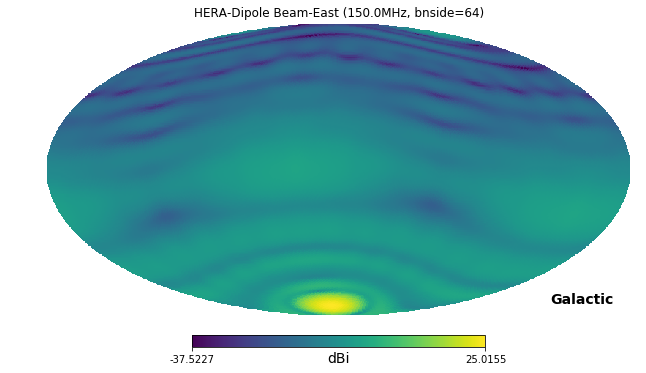

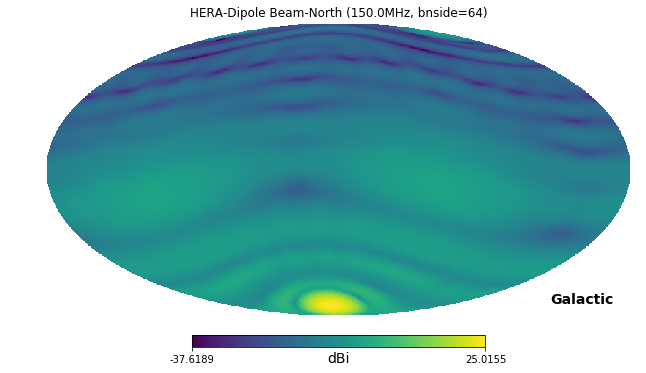

In [11]:
if Plot_Beam:
	plt.figure(0)
# 	ind = np.where(beam_freqs == freq)[0][0]
	hp.mollview(10.0 * np.log10(beam_heal_equ_x), coord='CG', title='HERA-Dipole Beam-East (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-east-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	hp.mollview(10.0 * np.log10(beam_heal_equ_y), coord='CG', title='HERA-Dipole Beam-North (%sMHz, bnside=%s)'%(freq, bnside),
			unit='dBi')
	#plt.savefig(script_dir + '/../Output/%s-equ-dipole-Beam-north-CG-%.2f-bnside-%s.pdf'%(INSTRUMENT, beam_freqs[ind], bnside))
	plt.show(block=False)

In [12]:
########################### Delete some Input Data ##############################
Del=True
if Del:
	#del(data)
	#del(data_yy)
	try:
		#del(model)
		#del(model_yy)
		del(data_omni)
	except:
		pass

sys.stdout.flush()

In [13]:
######################
####initial A to compute beam weight
#####################
A_version = 1.0
A = {}
for p in ['x', 'y']:
	pol = p + p
	# ubl file
	#// ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
	#ubls = np.array([[0,0,0]])
	#//np.fromfile(ubl_filename, dtype='float32').reshape((nUBL, 3))
	print "%i UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(ubls[p]), np.max(np.linalg.norm(ubls[p], axis=1)) / (C / freq), pol)
	print "%i Used-Common-UBLs to include, longest baseline is %i wavelengths for Pol: %s" % (len(used_common_ubls), np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq), pol)

	# beam
	if p == 'x':
		beam_heal_equ = beam_heal_equ_x
	elif p == 'y':
		beam_heal_equ = beam_heal_equ_x
	print "Computing sky weighting A matrix for %s pol..." % p
	sys.stdout.flush()

	A[p] = np.zeros((nt_used * len(used_common_ubls), 12 * nside_beamweight ** 2), dtype='complex128')

	timer = time.time()
	for i in np.arange(12 * nside_beamweight ** 2):
		dec, ra = hpf.pix2ang(nside_beamweight, i)  # gives theta phi
		dec = PI / 2 - dec
		print "\r%.1f%% completed" % (100. * float(i) / (12. * nside_beamweight ** 2)),
		sys.stdout.flush()
		if abs(dec - lat_degree * PI / 180) <= PI / 2:
			A[p][:, i] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts).flatten()

	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()
	

9 UBLs to include, longest baseline is 14 wavelengths for Pol: xx
9 Used-Common-UBLs to include, longest baseline is 14 wavelengths for Pol: xx
Computing sky weighting A matrix for x pol...
100.0% completed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [14]:
####################################################
###beam weights using an equal pixel A matrix######
#################################################
print "Computing beam weight...",
sys.stdout.flush()
beam_weight = ((la.norm(A['x'], axis=0) ** 2 + la.norm(A['y'], axis=0) ** 2) ** .5)[hpf.nest2ring(nside_beamweight, range(12 * nside_beamweight ** 2))]
beam_weight = beam_weight / np.mean(beam_weight)
thetas_standard, phis_standard = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
beam_weight = hpf.get_interp_val(beam_weight, thetas_standard, phis_standard, nest=True) #np.array([beam_weight for i in range(nside_standard ** 2 / nside_beamweight ** 2)]).transpose().flatten()
print "done."
sys.stdout.flush()

Computing beam weight... done.


In [15]:
################################################
#####################GSM###########################
#############################################
pca1 = hp.fitsfunc.read_map(script_dir + '/../data/gsm1.fits' + str(nside_standard))
pca2 = hp.fitsfunc.read_map(script_dir + '/../data/gsm2.fits' + str(nside_standard))
pca3 = hp.fitsfunc.read_map(script_dir + '/../data/gsm3.fits' + str(nside_standard))
components = np.loadtxt(script_dir + '/../data/components.dat')
scale_loglog = si.interp1d(np.log(components[:, 0]), np.log(components[:, 1]))
w1 = si.interp1d(components[:, 0], components[:, 2])
w2 = si.interp1d(components[:, 0], components[:, 3])
w3 = si.interp1d(components[:, 0], components[:, 4])
gsm_standard = np.exp(scale_loglog(np.log(freq))) * (w1(freq) * pca1 + w2(freq) * pca2 + w3(freq) * pca3)
if Absolute_Calibration_dred_mfreq:
	gsm_standard_mfreq = np.array([np.exp(scale_loglog(np.log(flist[0][i]))) * (w1(flist[0][i]) * pca1 + w2(flist[0][i]) * pca2 + w3(flist[0][i]) * pca3) for i in range(nf_used)])

# rotate sky map and converts to nest
equatorial_GSM_standard = np.zeros(12 * nside_standard ** 2, 'float')
print "Rotating GSM_standard and converts to nest...",

if INSTRUMENT == 'miteor':
	DecimalYear = 2013.58 #2013, 7, 31, 16, 47, 59, 999998)
elif INSTRUMENT == 'hera47':
	DecimalYear = np.mean(Time(data_times[0], format='jd').decimalyear)
	JulianEpoch = np.mean(Time(data_times[0], format='jd').jyear)

sys.stdout.flush()
equ_to_gal_matrix = hp.rotator.Rotator(coord='cg').mat.dot(sv.epoch_transmatrix(2000, stdtime=JulianEpoch))
ang0, ang1 = hp.rotator.rotateDirection(equ_to_gal_matrix,
					hpf.pix2ang(nside_standard, range(12 * nside_standard ** 2), nest=True))
equatorial_GSM_standard = hpf.get_interp_val(gsm_standard, ang0, ang1)
if Absolute_Calibration_dred_mfreq:
	equatorial_GSM_standard_mfreq = np.array([hpf.get_interp_val(gsm_standard_mfreq[i], ang0, ang1) for i in range(nf_used)])
print "done."

Del=True
if Del:
	del(pca1)
	del(pca2)
	del(pca3)
	del(w1)
	del(w2)
	del(w3)
	del(components)
	del(scale_loglog)
	del(gsm_standard)
	try:
		del(gsm_standard_mfreq)
	except:
		pass
sys.stdout.flush()

NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 32
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Rotating GSM_standard and converts to nest... done.


In [16]:
#print A.shape

In [17]:
###########################################################
####simulate visibilities using non dynamic pixelization###
##########################################
full_sim_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
sim_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
sim_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
if simulation_opt == 1:
	
	if os.path.isfile(full_sim_filename):
		fullsim_vis = np.fromfile(full_sim_filename, dtype='complex128').reshape((2, nUBL_used+1, nt_used))
		fullsim_vis[0][:-1,:].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1,:].astype('complex128').tofile(sim_vis_yy_filename)
		
	else:

		fullsim_vis = np.zeros((2, nUBL_used + 1, nt_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
		full_sim_ubls = np.concatenate((used_common_ubls, [[0, 0, 0]]), axis=0)#tag along auto corr
		full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
		full_decs = PI / 2 - full_thetas
		full_ras = full_phis
		full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
		# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

		print "Simulating visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
		sys.stdout.flush()
		masked_equ_GSM = equatorial_GSM_standard[full_sim_mask]
		timer = time.time()
		for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
			for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
				res = vs.calculate_pointsource_visibility(ra, dec, full_sim_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
				fullsim_vis[p] += masked_equ_GSM[i] * res
				# fullsim_vis_DBG[p, ..., i] = res[:-1]
				#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
		print "simulated visibilities in %.1f minutes."%((time.time() - timer) / 60.)
		fullsim_vis.astype('complex128').tofile(full_sim_filename)
		fullsim_vis[0][:-1,:].astype('complex128').tofile(sim_vis_xx_filename)
		fullsim_vis[1][:-1,:].astype('complex128').tofile(sim_vis_yy_filename)
		
	autocorr_vis = np.abs(fullsim_vis[:, -1])
	if crosstalk_type == 'autocorr':
		autocorr_vis_normalized = np.array([autocorr_vis[p] / (la.norm(autocorr_vis[p]) / la.norm(np.ones_like(autocorr_vis[p]))) for p in range(2)])
	else:
		autocorr_vis_normalized = np.ones((2, nt_used))
	fullsim_vis = fullsim_vis[:, :-1].transpose((1, 0, 2))


In [18]:
print autocorr_vis.mean()
print fullsim_vis.mean()

1227565.6587779154
(1556.6106039729052-329.7816353772341j)


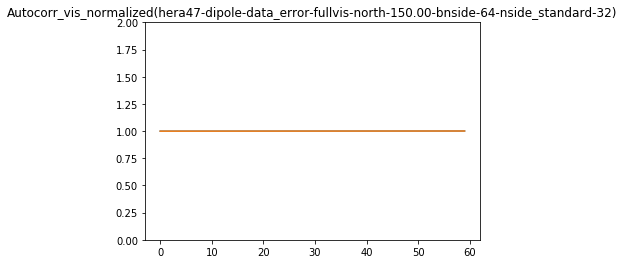

In [19]:
if plot_data_error:
	#plt.clf()
	plt.figure(30)
	plt.plot(autocorr_vis_normalized.transpose())
	plt.title('Autocorr_vis_normalized(%s-dipole-data_error-fullvis-north-%.2f-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.ylim([0, 2])
	plt.savefig(script_dir + '/../Output/%s-dipole-data_error-fullvis-north-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()
	#plt.clf()
	#plt.close()
sys.stdout.flush()


In [20]:
######################################### Absolute Calibration on Omnicaled Data #############################################
if Absolute_Calibration_red:
	full_redabs_sim_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_redabs.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
	redabs_sim_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_redabs_sim_xx.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
	redabs_sim_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_redabs_sim_yy.simvis'%(INSTRUMENT, freq, nBL_red_used+1, nt_used, nside_standard, bnside)
		
	if os.path.isfile(full_redabs_sim_filename):
		fullsim_vis_red = np.fromfile(full_redabs_sim_filename, dtype='complex128').reshape((2, nBL_red_used+1, nt_used))
		fullsim_vis_red[0][:-1,:].astype('complex128').tofile(redabs_sim_vis_xx_filename)
		fullsim_vis_red[1][:-1,:].astype('complex128').tofile(redabs_sim_vis_yy_filename)
		
	else:

		fullsim_vis_red = np.zeros((2, nBL_red_used + 1, nt_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
		full_sim_bls_red = np.concatenate((used_common_bls_red, [[0, 0, 0]]), axis=0)#tag along auto corr
		full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
		full_decs = PI / 2 - full_thetas
		full_ras = full_phis
		full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
		# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

		print "Simulating redundant visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nBL_red_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
		sys.stdout.flush()
		masked_equ_GSM = equatorial_GSM_standard[full_sim_mask]
		timer = time.time()
		for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
			for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
				res_red = vs.calculate_pointsource_visibility(ra, dec, full_sim_bls_red, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
				fullsim_vis_red[p] += masked_equ_GSM[i] * res_red
				# fullsim_vis_DBG[p, ..., i] = res[:-1]
				#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
		print "simulated redundant visibilities in %.1f minutes."%((time.time() - timer) / 60.)
		fullsim_vis_red.astype('complex128').tofile(full_redabs_sim_filename)
		fullsim_vis_red[0][:-1,:].astype('complex128').tofile(redabs_sim_vis_xx_filename)
		fullsim_vis_red[1][:-1,:].astype('complex128').tofile(redabs_sim_vis_yy_filename)
		
	autocorr_vis_red = np.abs(fullsim_vis_red[:, -1])
	if crosstalk_type == 'autocorr':
		autocorr_vis_red_normalized = np.array([autocorr_vis_red[p] / (la.norm(autocorr_vis_red[p]) / la.norm(np.ones_like(autocorr_vis_red[p]))) for p in range(2)])
	else:
		autocorr_vis_red_normalized = np.ones((2, nt_used))
	fullsim_vis_red = fullsim_vis_red[:, :-1].transpose((1, 0, 2)) 

	if plot_data_error:
		#plt.clf()
		plt.figure(3000000)
		plt.plot(autocorr_vis_red_normalized.transpose())
		plt.title('Autocorr_vis_normalized(%s-dipole-data_error-fullvis_red-north-%.2f-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.ylim([0, 2])
		plt.savefig(script_dir + '/../Output/%s-dipole-data_error-fullvis_red-north-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()
		#plt.clf()
		#plt.close()
	sys.stdout.flush()


In [21]:
if Absolute_Calibration_dred_mfreq: # Used 9.4 min. 64*9*60*12280
	full_sim_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	sim_vis_xx_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_xx_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
	sim_vis_yy_filename_mfreq = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_sim_yy_mfreq%s-%s-%s.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[1]))
	if simulation_opt == 1:
		
		if os.path.isfile(full_sim_filename_mfreq):
			fullsim_vis_mfreq = np.fromfile(full_sim_filename_mfreq, dtype='complex128').reshape((2, nUBL_used+1, nt_used, nf_used))
			fullsim_vis_mfreq[0][:-1].astype('complex128').tofile(sim_vis_xx_filename_mfreq)
			fullsim_vis_mfreq[1][:-1].astype('complex128').tofile(sim_vis_yy_filename_mfreq)
			
		else:

			fullsim_vis_mfreq = np.zeros((2, nUBL_used + 1, nt_used, nf_used), dtype='complex128')#since its going to accumulate along the pixels it needs to start with complex128. significant error if start with complex64
			full_sim_ubls = np.concatenate((used_common_ubls, [[0, 0, 0]]), axis=0)#tag along auto corr
			full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
			full_decs = PI / 2 - full_thetas
			full_ras = full_phis
			full_sim_mask = hpf.get_interp_val(beam_weight, full_thetas, full_phis, nest=True) > 0
			# fullsim_vis_DBG = np.zeros((2, len(used_common_ubls), nt_used, np.sum(full_sim_mask)), dtype='complex128')

			print "Simulating visibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * nf_used * (nUBL_used / 78.) * (nt_used / 193.) * (np.sum(full_sim_mask) / 1.4e5)),
			sys.stdout.flush()
			masked_equ_GSM_mfreq = equatorial_GSM_standard_mfreq[:, full_sim_mask]
			timer = time.time()
			for id_f, f in enumerate(flist[0]):
				for p, beam_heal_equ in enumerate([beam_heal_equ_x_mfreq[id_f], beam_heal_equ_y_mfreq[id_f]]):
					for i, (ra, dec) in enumerate(zip(full_ras[full_sim_mask], full_decs[full_sim_mask])):
						res = vs.calculate_pointsource_visibility(ra, dec, full_sim_ubls, f, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
						fullsim_vis_mfreq[p, :, :, id_f] += masked_equ_GSM_mfreq[id_f, i] * res
						# fullsim_vis_DBG[p, ..., i] = res[:-1]
						#autocorr = ~16*la.norm, ~80*np.std, ~1.e-5*np.corrrelate
			print "simulated visibilities in %.1f minutes."%((time.time() - timer) / 60.)
			fullsim_vis_mfreq.astype('complex128').tofile(full_sim_filename_mfreq)
			fullsim_vis_mfreq[0][:-1, :, :].astype('complex128').tofile(sim_vis_xx_filename_mfreq)
			fullsim_vis_mfreq[1][:-1, :, :].astype('complex128').tofile(sim_vis_yy_filename_mfreq)
			
		autocorr_vis_mfreq = np.abs(fullsim_vis_mfreq[:, -1])
#		if crosstalk_type == 'autocorr':
#			autocorr_vis_normalized = np.array([autocorr_vis[p] / (la.norm(autocorr_vis[p]) / la.norm(np.ones_like(autocorr_vis[p]))) for p in range(2)])
#		else:
#			autocorr_vis_normalized = np.ones((2, nt_used))
		fullsim_vis_mfreq = fullsim_vis_mfreq[:, :-1].transpose((1, 0, 2, 3)) # (uBL, Pol, Times, Freqs)


In [22]:
if not Model_Calibration: #and Absolute_Calibration is True:
#		model_fname1 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.xx.HH.uv'
#		model_fname2 = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.xx.HH.uv'
#		model_fname1_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192115507/2458042/zen.2458042.13298.yy.HH.uv'
#		model_fname2_yy = '/Users/JianshuLi/Documents/Miracle/Research/Cosmology/21cm Cosmology/Algorithm-Data/Data/HERA-47/Observation-1192114862/2458042/zen.2458042.12552.yy.HH.uv'
#		(model, mflags, antpos, ants, model_freqs, model_times, model_lsts,
#		 model_pols) = hc.abscal.UVData2AbsCalDict(model_fname1, return_meta=True) # also can try model_fname2
#		(model_yy, mflags_yy, antpos_yy, ants_yy, model_freqs_yy, model_times_yy, model_lsts_yy,
#		 model_pols_yy) = hc.abscal.UVData2AbsCalDict(model_fname2, return_meta=True) # also can try model_fname2
	
#		data_fname_omni = os.path.join(DATA_PATH, "zen.2458043.12552.xx.HH.uvORA")
#		(data_omni, dflags_omni, antpos_omni, ants_omni, data_freqs_omni, data_times_omni, data_lsts_omni, 
#		 data_pols_omni) = hc.abscal.UVData2AbsCalDict(data_fname_omni, return_meta=True)
	
	#model_list = {}
	#model = {}
	model_sf = {}
	model_dred = {}
	model_dred_mfreq = {}
	data = {}
	data_sf = {}
	data_dred = {}
	data_dred_mfreq = {}
	data_dred_mfreq_pscal = {}
	interp_flags_dred_mfreq ={}
	interp_flags_dred_mfreq_pscal ={}
	AC = {}
	AC_sf = {}
	AC_dred = {}
	AC_dred_mfreq = {}
	AC_dred_mfreq_pscal = {}
	freq_to_cal = [freq]
	fulldflags = {}
	auto_select_dred_mfreq = {}
	auto_select_dred_mfreq_pscal = {}
	
#	try:
#		cdata = copy.deepcopy(data)
#	except:
#		pass
	
	try:
		cdflags_sf = copy.deepcopy(dflags_sf)
	except:
		pass
		
	try:
		cdflags_dred = copy.deepcopy(dflags_dred)
	except:
		pass
	
	try:
		cdflags = copy.deepcopy(dflags)
	except:
		pass
	
	try:
		cdflags_dred_mfreq = copy.deepcopy(dflags_dred_mfreq)
	except:
		pass
		
	#cwgts = copy.deepcopy(wgts)
	#cwgts_dred = copy.deepcopy(wgts_dred)
	
	bl_select = 0
	bl = dflags.keys()[bl_select] #dflags and dflags_yy #[(24, 53, 'xx')
	fig = {}
	axes = {}
	fig_data = {}
	axes_data = {}
	
	bl_dred_select = 0
	bl_dred = dflags_dred[0].keys()[bl_dred_select] #if Absolute_Calibration_dred else None #[(25, 37, 'xx')
	fig2 = {}
	axes2 = {}
	fig2_data = {}
	axes2_data = {}
	
	bl_dred_mfreq_select = 8
	bl_dred_mfreq = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig3 = {}
	axes3 = {}
	fig3_data = {}
	axes3_data = {}
	fig3_data_abscorr = {} 
	axes3_data_abscorr = {}
	
	bl_dred_mfreq_pscal_select = 8
	bl_dred_mfreq_pscal = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_pscal_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_pscal_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig4 = {}
	axes4 = {}
	fig4_data = {}
	axes4_data = {}
	fig4_data_abscorr = {} 
	axes4_data_abscorr = {}
	
	delay_corr_data = {}
	delay_corr_data_sf = {}
	delay_corr_data_dred = {}
	delay_corr_data_dred_mfreq = {}
	delay_corr_data_dred_mfreq_pscal = {}
	DAC = {}
	DAC_sf = {}
	DAC_dred = {}
	DAC_dred_mfreq = {}
	DAC_dred_mfreq_pscal = {}
	dly_phs_corr_data = {}
	dly_phs_corr_data_sf = {}
	dly_phs_corr_data_dred = {}
	dly_phs_corr_data_dred_mfreq = {}
	dly_phs_corr_data_dred_mfreq_pscal = {}
	DPAC = {}
	DPAC_sf = {}
	DPAC_dred = {}
	DPAC_dred_mfreq = {}
	DPAC_dred_mfreq_pscal = {}
	abs_corr_data = {}
	abs_corr_data_sf = {}
	abs_corr_data_dred = {}
	abs_corr_data_dred_mfreq = {}
	abs_corr_data_dred_mfreq_pscal = {}
	
	vis_data_dred_mfreq_abscal = [[], []]
	vis_data_dred_mfreq_pscal_abscal = [[], []]
	autocorr_data_dred_mfreq_abscal = [[], []]
	autocorr_data_dred_mfreq_pscal_abscal = [[], []]
	vis_data_dred_abscal = [[], []]
	vis_data_dred_pscal_abscal = [[], []]
	autocorr_data_dred_abscal = [[], []]
	autocorr_data_dred_pscal_abscal = [[], []]
	
	add_Autobsl = False # Whether we add (0,0,0) to calculate autocorr or not.
	
#		model = (copy.deepcopy(data)).astype('complex128')
#		model_yy = copy.deepcopy(data_yy).astype('complex128')
	for i in range(2):
		model_sf[i] = LastUpdatedOrderedDict()
		model_sf[i] = LastUpdatedOrderedDict()
		model_dred[i] = LastUpdatedOrderedDict()
		model_dred_mfreq[i] = LastUpdatedOrderedDict()
		#data[i] = LastUpdatedOrderedDict()
		data_sf[i] = LastUpdatedOrderedDict()
		data_dred[i] = LastUpdatedOrderedDict()
		data_dred_mfreq[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		
		#fulldflags[i] = hc.abscal.UVData2AbsCalDict(data_fname_full[i], return_meta=True)[1] # assume autocorr no RFI flagged.
		
		if Absolute_Calibration_red:
			keys = dflags_sf[i].keys() # if i == 0 else dflags_yy.keys()
			for key_index, key in enumerate(keys):
				model_sf[i][key] = fullsim_vis_red[key_index, i, :]
				data_sf[i][key] = vis_data[i][:, key_index]
			model_sf[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_red[i] # not lose generality, choose the autocorrelation of first antenna in the first UBL as visibility in last line for autocorrelation calibraiton.
			data_sf[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data[i]
			cdflags_sf[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([False]*len(autocorr_data[i]))
			print(keys)
			print(keys[0][0])
			
				
		if Absolute_Calibration_dred:
			for key_index_dred, key_dred in enumerate(dflags_dred[i].keys()):
				model_dred[i][key_dred] = fullsim_vis[key_index_dred, i, :]
				data_dred[i][key_dred] = vis_data_dred[i][:, key_index_dred]
			model_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_vis[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
			data_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_data[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
			cdflags_dred[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = np.array([False]*len(autocorr_data[i]))
			print(dflags_dred[i].keys())
			print(dflags_dred[i].keys()[0][0])
			
		
#		if Absolute_Calibration_dred_mfreq:
#			keys = dflags_dred_mfreq[i].keys()
#			for key_index, key in enumerate(keys):
#				model[i][key] = fullsim_vis_mfreq[key_index_dred, i]
#				#data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
#			model[i][dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][0], dflags_dred[i].keys()[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
#			cdata[i][dflags[i].keys()[0][0], dflags[i].keys()[0][0], dflags[i].keys()[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
#			cdflags[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
#			print(dflags[i].keys())
#			print(dflags[i].keys()[0][0])
#			
							
		if Absolute_Calibration_dred_mfreq:
			keys = dflags_dred_mfreq[i].keys()
			for key_index, key in enumerate(keys):
				model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i]
				#data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
				data_dred_mfreq[i][key] = vis_data_dred_mfreq[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
			if add_Autobsl:
				model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
				data_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
				cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
				auto_select_dred_mfreq[i] = (keys[0][0], keys[0][0], keys[0][2])
			print(dflags_dred_mfreq[i].keys())
			print(dflags_dred_mfreq[i].keys()[0][0])
			
			
	###### make wgts #######	
	for i in range(2):
		if i == 0:
			wgts_sf = copy.deepcopy(cdflags_sf)
		for k in wgts_sf[i].keys():
			wgts_sf[i][k] = (~wgts_sf[i][k]).astype(np.float)
		
		if i == 0:
			wgts_dred = copy.deepcopy(cdflags_dred)
		for k in wgts_dred[i].keys():
			wgts_dred[i][k] = (~wgts_dred[i][k]).astype(np.float)
			
#		if i == 0:
#			wgts = copy.deepcopy(cdflags)
#		for k in wgts[i].keys():
#			wgts[i][k] = (~wgts[i][k]).astype(np.float)
				
		if i == 0:
			wgts_dred_mfreq = copy.deepcopy(cdflags_dred_mfreq)
		for k in wgts_dred_mfreq[i].keys():
			wgts_dred_mfreq[i][k] = (~wgts_dred_mfreq[i][k]).astype(np.float)
			
			
re_cal_times = 1


[(25, 37, 'xx'), (25, 52, 'xx'), (24, 52, 'xx'), (37, 39, 'xx'), (24, 39, 'xx'), (24, 53, 'xx'), (24, 25, 'xx'), (24, 38, 'xx'), (24, 37, 'xx')]
25
[(25, 37, 'yy'), (25, 52, 'yy'), (24, 52, 'yy'), (37, 39, 'yy'), (24, 39, 'yy'), (24, 53, 'yy'), (24, 25, 'yy'), (24, 38, 'yy'), (24, 37, 'yy')]
25


In [23]:
for i in range(2):
	pol = ['xx', 'yy'][i]
	re_cal = 0
	
	if Absolute_Calibration_dred_mfreq:
		for re_cal in range(re_cal_times): # number of times of absolute calibration
			if re_cal == 0:
				model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
				# instantiate class
				AC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
				AC_dred_mfreq[i].delay_lincal(kernel=(1, 11), medfilt=True, time_avg=True, solve_offsets=True)
			else:
				#model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
				# instantiate class
				AC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
				AC_dred_mfreq[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
			# apply to data
			delay_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(AC_dred_mfreq[i].data, (AC_dred_mfreq[i].ant_dly_gain))
			# instantiate class
			DAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
			# avg phase solver
			DAC_dred_mfreq[i].phs_logcal(avg=True)
			# apply to data
			dly_phs_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(DAC_dred_mfreq[i].data, (DAC_dred_mfreq[i].ant_phi_gain))
			# instantiate class
			DPAC_dred_mfreq[i] = hc.abscal.AbsCal(model_dred_mfreq[i], dly_phs_corr_data_dred_mfreq[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
			# run amp linsolve
			DPAC_dred_mfreq[i].abs_amp_logcal()
			# run phs linsolve
			DPAC_dred_mfreq[i].TT_phs_logcal(zero_psi=False, four_pol=False)
			# apply to data
			abs_corr_data_dred_mfreq[i] = hc.abscal.apply_gains(DPAC_dred_mfreq[i].data, 
									(DPAC_dred_mfreq[i].abs_psi_gain, DPAC_dred_mfreq[i].TT_Phi_gain, DPAC_dred_mfreq[i].abs_eta_gain), gain_convention='multiply')
								
		vis_data_dred_mfreq_abscal[i] = np.zeros_like(vis_data_dred_mfreq[i], dtype='complex128')
		for key_id, key in enumerate(dflags_dred_mfreq[i].keys()):
			vis_data_dred_mfreq_abscal[i][:, :, key_id] = abs_corr_data_dred_mfreq[i][key].transpose()
			#vis_data_dred_mfreq_abscal[i][:, :, key_id] = np.real(abs_corr_data_dred_mfreq[i][key].transpose()) + np.abs(np.imag(abs_corr_data_dred_mfreq[i][key].transpose()))*1j
		if add_Autobsl:
			autocorr_data_dred_mfreq_abscal[i] = abs_corr_data_dred_mfreq[i][auto_select_dred_mfreq[i]]
		else:
			autocorr_data_dred_mfreq_abscal[i] = autocorr_vis_mfreq[i]
			
		vis_data_dred_abscal[i] = vis_data_dred_mfreq_abscal[i][index_freq[i], :, :]
		if add_Autobsl: 
			autocorr_data_dred_abscal[i] = autocorr_data_dred_mfreq_abscal[i][:, index_freq[i]]
		else:
			autocorr_data_dred_abscal[i] = autocorr_vis_mfreq[i][:, index_freq[i]]
		

...configuring linsolve data for delay_lincal


divide by zero encountered in divide


...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve


divide by zero encountered in divide


...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve


divide by zero encountered in divide


...finished linsolve
...configuring linsolve data for TT_phs_logcal
...running linsolve


divide by zero encountered in divide


...finished linsolve
...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve


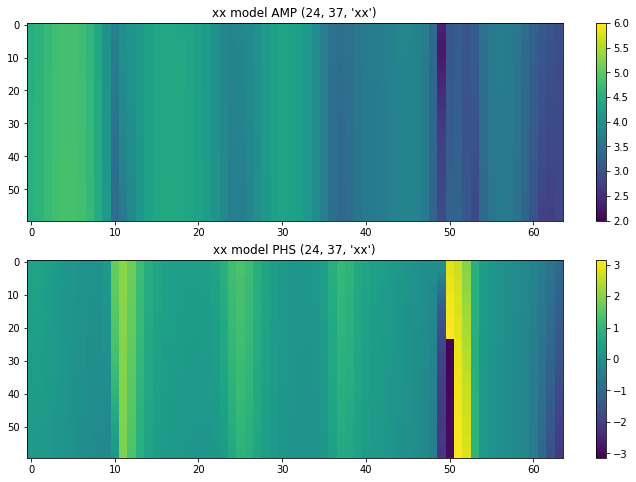

divide by zero encountered in log10


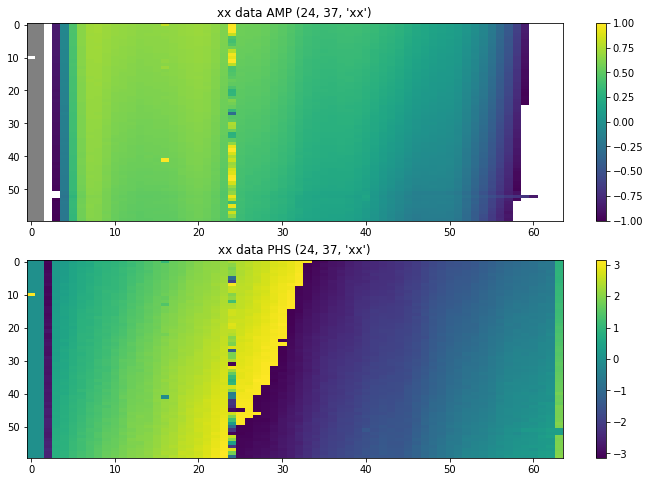

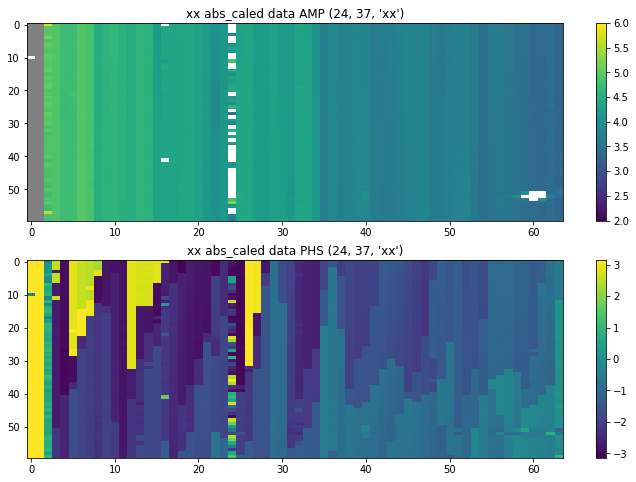

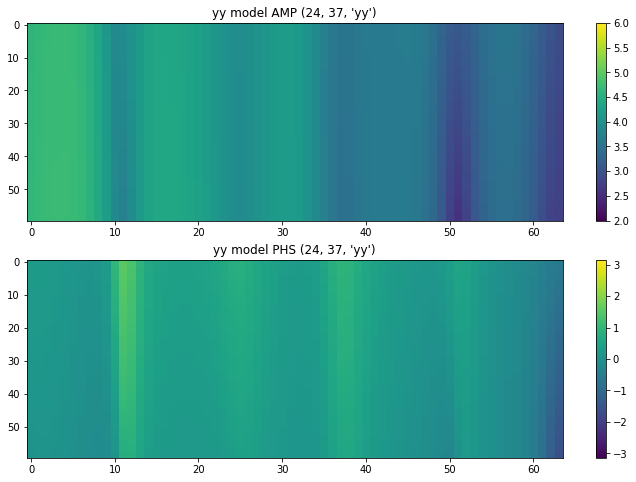

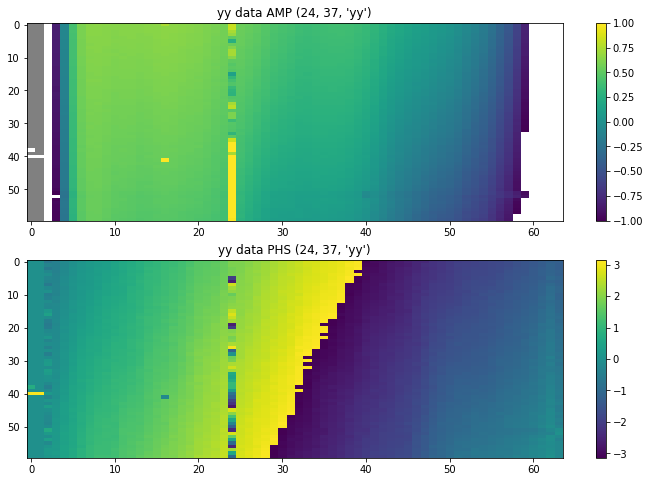

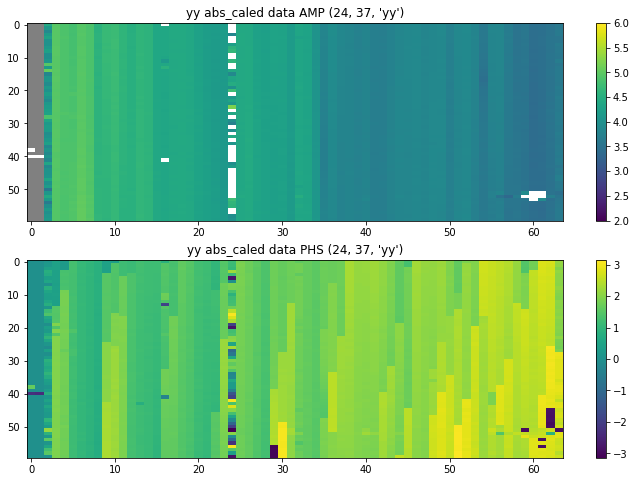

In [24]:
for i in range(2):
	pol = ['xx', 'yy'][i]
	
	if Absolute_Calibration_dred_mfreq:								
		plt.figure(80000000+10*i)
		fig3[i], axes3[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3[i][0])
		uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
		plt.colorbar()
		plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3[i][1])
		uvt.plot.waterfall(AC_dred_mfreq[i].model[bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)			
		#plt.cla()
			
		plt.figure(90000000+10*i)
		fig3_data[i], axes3_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3_data[i][0])
		uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=1, drng=2)
		plt.colorbar()
		plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3_data[i][1])
		uvt.plot.waterfall(data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)
		#plt.cla()		
			
		####################### after ABS Calibration #########################	
		plt.figure(8000000+10*i)
		fig3_data_abscorr[i], axes3_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
		plt.sca(axes3_data_abscorr[i][0])
		uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='log', mx=6, drng=4)
		plt.colorbar()
		plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq[i]))
		plt.sca(axes3_data_abscorr[i][1])
		uvt.plot.waterfall(abs_corr_data_dred_mfreq[i][bl_dred_mfreq[i]], mode='phs', mx=np.pi, drng=2*np.pi)
		plt.colorbar()
		plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq[i]))
		plt.show(block=False)
		#plt.cla()


In [25]:
for i in range(2):	
	if Absolute_Calibration_dred:
		# instantiate class
		#AC_dred[i] = hc.abscal.AbsCal(model_dred[i], data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
		AC_dred[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
		# apply to data
		delay_corr_data_dred[i] = hc.abscal.apply_gains(AC_dred[i].data, (AC_dred[i].ant_dly_gain))
		# instantiate class
		DAC_dred[i] = hc.abscal.AbsCal(model_dred[i], data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# avg phase solver
		DAC_dred[i].phs_logcal(avg=True)
		# apply to data
		dly_phs_corr_data_dred[i] = hc.abscal.apply_gains(DAC_dred[i].data, (DAC_dred[i].ant_phi_gain))
		# instantiate class
		DPAC_dred[i] = hc.abscal.AbsCal(model_dred[i], dly_phs_corr_data_dred[i], antpos=antpos[i], wgts=wgts_dred[i], freqs=freq_to_cal)
		# run amp linsolve
		DPAC_dred[i].abs_amp_logcal()
		# run phs linsolve
		DPAC_dred[i].TT_phs_logcal(zero_psi=False, four_pol=False)
		# apply to data
		abs_corr_data_dred[i] = hc.abscal.apply_gains(DPAC_dred[i].data, 
								(DPAC_dred[i].abs_psi_gain, DPAC_dred[i].TT_Phi_gain, DPAC_dred[i].abs_eta_gain), gain_convention='multiply')
		
		
		plt.figure(60000000+10*i)
		fig2[i], axes2[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2[i][0])
			uvt.plot.waterfall(AC_dred[i].model[bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred))
			plt.sca(axes2[i][1])
			uvt.plot.waterfall(AC_dred[i].model[bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred))
			plt.show(block=False)			
		else:
			plt.sca(axes2[i][0])
			plt.plot(np.real(AC_dred[i].model[bl_dred]))
			plt.title(pol + ' model Real {}'.format(bl_dred))
			plt.sca(axes2[i][1])
			plt.plot(np.imag(AC_dred[i].model[bl_dred]))
			plt.title(pol + ' model Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()
			
		plt.figure(70000000+10*i)
		fig2_data[i], axes2_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2_data[i][0])
			uvt.plot.waterfall(AC_dred[i].data[bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			uvt.plot.waterfall(AC_dred[i].data[bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred))
			plt.show(block=False)
		else:
			plt.sca(axes2_data[i][0])
			plt.plot(np.real(AC_dred[i].data[bl_dred]))
			plt.title(pol + ' data Real {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			plt.plot(np.imag(AC_dred[i].data[bl_dred]))
			plt.title(pol + ' data Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()
			
			
		####################### after ABS Calibration #########################	
		plt.figure(7000000+10*i)
		fig2_data[i], axes2_data[i] = plt.subplots(2, 1, figsize=(12, 8))
		if len(freq_to_cal) >= 2:
			plt.sca(axes2_data[i][0])
			uvt.plot.waterfall(abs_corr_data_dred[i][bl_dred], mode='log', mx=4, drng=2)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			uvt.plot.waterfall(abs_corr_data_dred[i][bl_dred], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred))
			plt.show(block=False)
		else:
			plt.sca(axes2_data[i][0])
			plt.plot(np.real(abs_corr_data_dred[i][bl_dred]))
			plt.title(pol + ' data Real {}'.format(bl_dred))
			plt.sca(axes2_data[i][1])
			plt.plot(np.imag(abs_corr_data_dred[i][bl_dred]))
			plt.title(pol + ' data Imag {}'.format(bl_dred))
			plt.show(block=False)
		#plt.cla()


In [26]:
################# Noise and Vis Data Loading ##################
if len(tlist) >= 2:
	Time_seperation_real = np.array([3600.*np.abs(tlist[i+1]-tlist[i]) for i in range(len(tlist)-1)]) # in second
elif INSTRUMENT == 'hera47':
	 Time_seperation_real = 11
elif INSTRUMENT == 'miteor':
	Time_seperation_real = 144
Frequency_gap_real = np.array([1.e6*np.abs(flist[0][i+1]-flist[0][i]) for i in range(len(flist[0])-1)]) # Hz

Integration_Time = np.mean(Time_seperation_real)
Frequency_Bin = np.mean(Frequency_gap_real)

Calculate_SimulationData_Noise = True
Calculate_Data_Noise = True

scale_noise = True
#Use_AbsCal = False

noise = {}
noise_data = {}
if Calculate_SimulationData_Noise:
	if Keep_Red:	
		noise['x'] = np.array([np.random.normal(0, autocorr_vis_red[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) for t_index in range(len(autocorr_vis[0]))],dtype='complex128').flatten()
		noise['y'] = np.array([np.random.normal(0, autocorr_vis_red[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) for t_index in range(len(autocorr_vis[1]))],dtype='complex128').flatten()
	else:
		noise['x'] = np.array([(np.random.normal(0, autocorr_vis[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_vis[0]))],dtype='complex128').flatten()
		noise['y'] = np.array([(np.random.normal(0, autocorr_vis[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_vis[1]))],dtype='complex128').flatten()
	
#	N_acu = {}
#	N_acu['x'] = np.outer(noise['x'], noise['x'].T)
#	N_acu['y'] = np.outer(noise['y'], noise['y'].T)
	N = {}
	N['x'] = noise['x'] * noise['x']
	N['y'] = noise['y'] * noise['y']
	
	sim_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
	sim_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_sim_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
	N['x'].astype('complex128').tofile(sim_var_xx_filename)
	N['y'].astype('complex128').tofile(sim_var_yy_filename)
	
	Del = True
	if Del:
		del(noise)
		del(N)

if Calculate_Data_Noise:
	if INSTRUMENT == 'miteor':
		noise_data['x'] = (var_data[0].flatten())**0.5
		noise_data['y'] = (var_data[1].flatten())**0.5
		
	elif INSTRUMENT == 'hera47':
		if Keep_Red:
			noise_data['x'] = np.array([np.random.normal(0,autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Not Absolute Calibrated
			noise_data['y'] = np.array([np.random.normal(0,autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
		else:
			if scale_noise:
				if Use_AbsCal:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[0][t_index]/(Integration_Time*Frequency_Bin) **0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_data_dred_abscal[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[1][t_index]/(Integration_Time*Frequency_Bin) **0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_data_dred_abscal[1]))],dtype='complex128').flatten()
				else:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[0])**0.5) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) / np.array(redundancy[1])**0.5) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
			else:
				if Use_AbsCal:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data_dred_abscal[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data_dred_abscal[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data_dred_abscal[1]))],dtype='complex128').flatten()
				else:
					noise_data['x'] = np.array([(np.random.normal(0, autocorr_data[0][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data[0]))],dtype='complex128').flatten() # Absolute Calibrated
					noise_data['y'] = np.array([(np.random.normal(0, autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL_used) ) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
						
#	N_data_acu = {}
#	N_data_acu['x'] = np.outer(noise_data['x'], noise_data['x'].T)
#	N_data_acu['y'] = np.outer(noise_data['y'], noise_data['y'].T)
	N_data = {}
	N_data['x'] = noise_data['x'] * noise_data['x']
	N_data['y'] = noise_data['y'] * noise_data['y']
	
	Store_Data_Noise = True

	if Store_Data_Noise:
		data_var_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
		data_var_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
		N_data['x'].astype('complex128').tofile(data_var_xx_filename)
		N_data['y'].astype('complex128').tofile(data_var_yy_filename)
	
	Del = True
	if Del:
		del(noise_data)
		#del(N_data)
#		try:
#			del(autocorr_data)
#		except:
#			pass

sys.stdout.flush()


In [27]:
######################
####simulate cas and cyg
#######################
southern_points = {'hyd':{'ra': '09:18:05.7', 'dec': '-12:05:44'},
'cen':{'ra': '13:25:27.6', 'dec': '-43:01:09'},
'cyg':{'ra': '19:59:28.3', 'dec': '40:44:02'},
'pic':{'ra': '05:19:49.7', 'dec': '-45:46:44'},
'vir':{'ra': '12:30:49.4', 'dec': '12:23:28'},
'for':{'ra': '03:22:41.7', 'dec': '-37:12:30'},
'sag':{'ra': '17:45:40.045', 'dec': '-29:0:27.9'},
'cas':{'ra': '23:23:26', 'dec': '58:48:00'},
'crab':{'ra': '5:34:31.97', 'dec': '22:00:52.1'}}


for source in southern_points.keys():
	southern_points[source]['body'] = ephem.FixedBody()
	southern_points[source]['body']._ra = southern_points[source]['ra']
	southern_points[source]['body']._dec = southern_points[source]['dec']

flux_func = {}
#flux_func['cas'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/casA2013.5out')[:,2])
#flux_func['cyg'] = si.interp1d(np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,1], np.loadtxt('/home/omniscope/data/point_source_flux/cygA2006out')[:,2])
flux_func['cas'] = si.interp1d(flist[0], np.array([S_casa_v_t(flist[0][i], DecimalYear) for i in range(len(flist[0]))]))
flux_func['cyg'] = si.interp1d(flist[0], np.array([S_cyga_v(flist[0][i], DecimalYear) for i in range(len(flist[0]))]))


pt_sources = ['cyg', 'cas']
pt_vis = np.zeros((len(pt_sources), 2, nUBL_used, nt_used), dtype='complex128')
if INSTRUMENT == 'miteor':
	print "Simulating cyg casvisibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (2. / 1.4e5)),
	sys.stdout.flush()
	timer = time.time()
	for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
		for i, source in enumerate(pt_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
			pt_vis[i, p] = jansky2kelvin * flux_func[source](freq) * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2
elif INSTRUMENT == 'hera47':
	print "Simulating cyg casvisibilities, %s, expected time %.1f min"%(datetime.datetime.now(), 14.6 * (nUBL_used / 78.) * (nt_used / 193.) * (2. / 1.4e5)),
	sys.stdout.flush()
	timer = time.time()
	for p, beam_heal_equ in enumerate([beam_heal_equ_x, beam_heal_equ_y]):
		for i, source in enumerate(pt_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec
			pt_vis[i, p] = jansky2kelvin * flux_func[source](freq) * vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ, tlist=lsts) / 2



if PointSource_AbsCal:
	vis_freq = {}
	
	autocorr_data_dred_mfreq_pscal = {}
	vis_data_dred_mfreq_pscal = {}
	
	for j, p in enumerate(['x', 'y']):
		pol = p+p
		vis_data_dred_mfreq_pscal[j] = np.zeros_like(vis_data_dred_mfreq_abscal[j])
		autocorr_data_dred_mfreq_pscal[j] = np.zeros_like(autocorr_data_dred_mfreq_abscal[j])
	
	for id_f in range(len(flist[0])):
		vis_freq[0] = flist[0][id_f]
		vis_freq[1] = flist[1][id_f]
		cal_lst_range = np.array([5, 6]) / TPI * 24.
		calibrate_ubl_length = 1600 / np.mean([vis_freq[0], vis_freq[1]]) #10.67
		cal_time_mask = tmask	 #(tlist>cal_lst_range[0]) & (tlist<cal_lst_range[1])#a True/False mask on all good data to get good data in cal time range
		#cal_ubl_mask = {}
		
		
		Ni = {}
		cubls = copy.deepcopy(ubls)
		ubl_sort = {}
		noise_data_pscal = {}
		N_data_pscal = {}
		vis_data_dred_pscal = {}
		
		From_AbsCal = False
		
		for i, p in enumerate(['x', 'y']):
			pol = p+p
			cal_ubl_mask = np.linalg.norm(ubls[p], axis=1) >= calibrate_ubl_length
			#get Ni (1/variance) and data
			#var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, vartag)
			#noise_data_pscal['y'] = np.array([(np.random.normal(0,autocorr_data[1][t_index]/(Integration_Time*Frequency_Bin)**0.5,nUBL_used) ) for t_index in range(len(autocorr_data[1]))],dtype='complex128').flatten()
			
			if From_AbsCal:
				vis_data_dred_pscal[i] = vis_data_dred_mfreq_abscal[i][id_f][np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
				noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_abscal[i][t_index, id_f]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
			else:
				vis_data_dred_pscal[i] = vis_data_dred_mfreq[i][id_f][np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
				noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_mfreq[i][t_index, id_f]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
				
			N_data_pscal[p] = noise_data_pscal[p] * noise_data_pscal[p]
			#N_data_pscal['y'] = noise_data_pscal['y'] * noise_data_pscal['y']
			Ni[p] = 1./N_data_pscal[p].reshape((nt, nUBL))[np.ix_(cal_time_mask, cal_ubl_mask)].transpose()
			ubls[p] = ubls[p][cal_ubl_mask]
			ubl_sort[p] = np.argsort(la.norm(ubls[p], axis=1))

			print "%i UBLs to include"%len(ubls[p])
		
		del(noise_data_pscal)
		
		print "Computing UNpolarized point sources matrix..."
		sys.stdout.flush()
		cal_sources = ['cyg', 'cas']
		Apol = np.empty((np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask), len(cal_sources)), dtype='complex128')
		timer = time.time()
		for n, source in enumerate(cal_sources):
			ra = southern_points[source]['body']._ra
			dec = southern_points[source]['body']._dec

			Apol[:, 0, :, n] = vs.calculate_pointsource_visibility(ra, dec, ubls[p], vis_freq[0], beam_heal_equ=beam_heal_equ_x_mfreq[id_f], tlist=lsts[cal_time_mask])
			Apol[:, 1, :, n] = vs.calculate_pointsource_visibility(ra, dec, ubls[p], vis_freq[1], beam_heal_equ=beam_heal_equ_y_mfreq[id_f], tlist=lsts[cal_time_mask])

		Apol = np.conjugate(Apol).reshape((np.sum(cal_ubl_mask), 2 * np.sum(cal_time_mask), len(cal_sources)))
		Ni = np.transpose([Ni['x'], Ni['y']], (1, 0, 2))

		realA = np.zeros((2 * Apol.shape[0] * Apol.shape[1], 1 + 2 * np.sum(cal_ubl_mask) * 2), dtype='complex128')
		realA[:, 0] = np.concatenate((np.real(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2]))), np.imag(Apol.reshape((Apol.shape[0] * Apol.shape[1], Apol.shape[2])))), axis=0).dot([jansky2kelvin_mfreq[0][id_f] * flux_func[source](vis_freq[0]) for source in cal_sources])
		vis_scale = la.norm(realA[:, 0]) / len(realA)**.5
		for coli, ncol in enumerate(range(1, realA.shape[1])):
			realA[coli * np.sum(cal_time_mask): (coli + 1) * np.sum(cal_time_mask), ncol] = vis_scale

		realNi = np.concatenate((Ni.flatten() * 2, Ni.flatten() * 2))
		realAtNiAinv = np.linalg.pinv(np.einsum('ji,j,jk->ik', realA, realNi, realA))


		b = np.transpose([vis_data_dred_pscal[0], vis_data_dred_pscal[1]], (1, 0, 2))
		phase_degen_niter = 0
		phase_degen2 = {'x': np.zeros(2), 'y': np.zeros(2)}
		phase_degen_iterative_x = np.zeros(2)
		phase_degen_iterative_y = np.zeros(2)
		def tocomplex(realdata):
			reshapedata = realdata.reshape((2, np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask)))
			return reshapedata[0] + reshapedata[1] * 1.j

		phase_degen_niter_max = 100
		while (phase_degen_niter < phase_degen_niter_max and max(np.linalg.norm(phase_degen_iterative_x), np.linalg.norm(phase_degen_iterative_y)) > 1e-5) or phase_degen_niter == 0:
			phase_degen_niter += 1
			b[:, 0] = b[:, 0] * np.exp(1.j * ubls['x'][:, :2].dot(phase_degen_iterative_x))[:, None]
			b[:, -1] = b[:, -1] * np.exp(1.j * ubls['y'][:, :2].dot(phase_degen_iterative_y))[:, None]
			realb = np.concatenate((np.real(b.flatten()), np.imag(b.flatten())))

			psol = realAtNiAinv.dot(np.transpose(realA).dot(realNi * realb))
			realb_fit = realA.dot(psol)
			perror = ((realb_fit - realb) * (realNi**.5)).reshape((2, np.sum(cal_ubl_mask), 2, np.sum(cal_time_mask)))

			realbfit_noadditive = realA[:, 0] * psol[0]
			realbfit_additive = realb_fit - realbfit_noadditive
			realb_noadditive = realb - realbfit_additive
			bfit_noadditive = tocomplex(realbfit_noadditive)
			b_noadditive = tocomplex(realb_noadditive)
			if phase_degen_niter == phase_degen_niter_max:
				phase_degen_iterative_x = solve_phase_degen(np.transpose(b_noadditive[:, 0]), np.transpose(b_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), ubls['x'])#, [3, 3, 1e3])
				phase_degen_iterative_y = solve_phase_degen(np.transpose(b_noadditive[:, -1]), np.transpose(b_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), ubls['y'])#, [3, 3, 1e3])

			else:
				phase_degen_iterative_x = solve_phase_degen(np.transpose(b_noadditive[:, 0]), np.transpose(b_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), np.transpose(bfit_noadditive[:, 0]), ubls['x'])
				phase_degen_iterative_y = solve_phase_degen(np.transpose(b_noadditive[:, -1]), np.transpose(b_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), np.transpose(bfit_noadditive[:, -1]), ubls['y'])
			phase_degen2['x'] += phase_degen_iterative_x
			phase_degen2['y'] += phase_degen_iterative_y
			print phase_degen_niter, phase_degen2['x'], phase_degen2['y'], np.linalg.norm(perror)

		renorm = 1 / (2 * psol[0])

		print (renorm, vis_freq[0],  phase_degen2['x'], vis_freq[1], phase_degen2['y'])

		#freqs[fi] = vis_freq

		################################# apply to data and var and output unpolarized version ####################################
		data_var_xx_filename_pscal = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_xx_pscal.simvis'%(INSTRUMENT, freq, nUBL, nt, nside_standard, bnside)
		data_var_yy_filename_pscal = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_var_data_yy_pscal.simvis'%(INSTRUMENT, freq, nUBL, nt, nside_standard, bnside)
		
		#vis_data_dred_pscal = {}
		#N_data_pscal = {}
		
		######### recover ubls and ubl_sort ##########
		ubls = cubls
		#ubl_sort = cubl_sort
		
		if Keep_Red:
			nUBL = len(bsl_coord_x)
			for p in ['x', 'y']:
				#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl' % (p, p, nUBL, 3)
				ubls[p] = globals()['bsl_coord_' + p]
			common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
			
		else:
			nUBL = len(bsl_coord_dred[0])
			nUBL_yy = len(bsl_coord_dred[1])
			for i in range(2):
				p = ['x', 'y'][i]
				ubls[p] = bsl_coord_dred[i]
			common_ubls = np.array([u for u in ubls['x'] if (u in ubls['y'] or -u in ubls['y'])])
		
		#get data and var and apply change
		
		for j, p in enumerate(['x', 'y']):
			pol = p+p

			if From_AbsCal:
				vis_data_dred_mfreq_pscal[j][id_f] = vis_data_dred_mfreq_abscal[j][id_f] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
				if comply_ps2mod_autocorr:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_vis_mfreq[j][:, id_f]
				else:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_data_dred_mfreq_abscal[j][:, id_f] * np.abs(renorm)  # Absolute Calibrated
			else:
				vis_data_dred_mfreq_pscal[j][id_f] = vis_data_dred_mfreq[j][id_f] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
				if comply_ps2mod_autocorr:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_vis_mfreq[j][:, id_f]
				else:
					autocorr_data_dred_mfreq_pscal[j][:, id_f] = autocorr_data_mfreq[j][:, id_f] * np.abs(renorm) # Absolute Calibrated
		
		
	noise_data_pscal = {}
	N_data_pscal = {}
	vis_data_dred_pscal = {}
	for i, p in enumerate(['x', 'y']):
		pol = p+p
#		data_filename = glob.glob(datadir + tag + '_%s%s_*_*'%(p, p) + datatag)[0]
#		nt_nUBL = os.path.basename(data_filename).split(datatag)[0].split('%s%s_'%(p, p))[-1]
#		nt = int(nt_nUBL.split('_')[0])
#		nUBL = int(nt_nUBL.split('_')[1])
#		var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, vartag)
#
#		op_data_filename = datadir + tag + '_%s%s_%i_%i%s'%(p, p, nt, nUBL, dataoptag)
#		op_var_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, varoptag)
#		op_var100_filename = datadir + tag + '_%s%s_%i_%i%s.var'%(p, p, nt, nUBL, varoptag+'x100')

		#ubl file
		#ubl_filename = datadir + tag + '_%s%s_%i_%i.ubl'%(p, p, nUBL, 3)
		#ubls = np.fromfile(ubl_filename, dtype='float32').reshape((nUBL, 3))
		
#		if From_AbsCal:
#			vis_data_dred_pscal[i] = vis_data_dred_abscal[i] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_abscal[i][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
#		else:
#			vis_data_dred_pscal[i] = vis_data_dred[i] * np.exp(1.j * ubls[p][:, :2].dot(phase_degen2[p])) * renorm
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data[i][t_index]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data[i]))],dtype='complex128').flatten() # Absolute Calibrated
		
		vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
		noise_data_pscal[p] = np.array([(np.random.normal(0, autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/ (Integration_Time*Frequency_Bin)**0.5, nUBL)/ np.array(redundancy[i])**0.5 ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
		
#		if From_AbsCal:
#			vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
#		else:
#			vis_data_dred_pscal[i] = vis_data_dred_mfreq_pscal[i][index_freq[i]]
#			noise_data_pscal[p] = np.array([(np.random.normal(0,autocorr_data_dred_mfreq_pscal[i][t_index, index_freq[i]]/(Integration_Time*Frequency_Bin)**0.5, nUBL) ) for t_index in range(len(autocorr_data_dred_mfreq_pscal[i]))],dtype='complex128').flatten() # Absolute Calibrated
					
		N_data_pscal[p] = noise_data_pscal[p] * noise_data_pscal[p]
		N_data_pscal[p] = N_data_pscal[p].reshape((nt, nUBL))
		
		#save
#		if os.path.isfile(op_data_filename) and not overwrite:
#			raise IOError(op_data_filename + ' exists.')
#		else:
#			new_data.astype('complex128').tofile(op_data_filename)

		N_data_pscal[p].astype('complex128').tofile(globals()['data_var_' + pol + '_filename_pscal'])
		#(new_var * 100.).astype('float32').tofile(op_var100_filename)
	del(noise_data_pscal)


Simulating cyg casvisibilities, 2018-03-07 19:14:32.543149, expected time 0.0 min 6 UBLs to include
6 UBLs to include
Computing UNpolarized point sources matrix...
1 [ 0.00112498 -0.00103673] [-0.24315268 -0.09442453] 1.0215073205736493
2 [ 0.00224996 -0.00207345] [-0.23488257 -0.09107074] 1.0215275212610087
3 [ 0.00337494 -0.00311018] [-0.2276474 -0.090102 ] 1.0215277040105302
4 [ 0.00449991 -0.00414691] [-0.22137229 -0.08968782] 1.0215278086105073
5 [ 0.00562489 -0.00518363] [-0.21598398 -0.0893488 ] 1.0215278620656865
6 [ 0.00674987 -0.00622036] [-0.21100704 -0.19541046] 1.021527870633171
7 [ 0.00787485 -0.00725709] [-0.20642393 -0.31778476] 1.0215277602288593
8 [ 0.00899983 -0.00829381] [-0.20254676 -0.44198166] 1.021527689514451
9 [ 0.01012481 -0.00933054] [-0.20017464 -0.35345935] 1.0215276261055604
10 [ 0.01124979 -0.01036727] [-0.1982025  -0.44370315] 1.0215277508422917
11 [ 0.01237477 -0.01140399] [-0.19680944 -0.3536161 ] 1.0215275251999498
12 [ 0.01349974 -0.01244072] [-0.19

8 [0.00978711 0.00579501] [-0.02683276  0.00871464] 0.6083731728834028
9 [0.01101049 0.00651938] [-0.03001028  0.01051377] 0.608373275893522
10 [0.01223388 0.00724376] [-0.03319189  0.01229466] 0.6083733803552737
11 [0.01345727 0.00796814] [-0.0363752   0.01404855] 0.6083734888921531
12 [0.01468066 0.00869251] [-0.03955694  0.01577103] 0.6083736024632149
13 [0.01590405 0.00941689] [-0.04273353  0.01746015] 0.6083737211132583
14 [0.01712743 0.01014127] [-0.04590133  0.01911539] 0.6083738444185437
15 [0.01835082 0.01086564] [-0.0490569   0.02073699] 0.6083739717420992
16 [0.01957421 0.01159002] [-0.05219699  0.02232556] 0.6083741023749243
17 [0.0207976  0.01231439] [-0.05531863  0.02388187] 0.6083742356107922
18 [0.02202099 0.01303877] [-0.05841912  0.02540676] 0.6083743707833049
19 [0.02324438 0.01376315] [-0.06149601  0.02690104] 0.6083745072820258
20 [0.02446776 0.01448752] [-0.0645471   0.02836549] 0.6083746445573575
21 [0.02569115 0.0152119 ] [-0.06757041  0.02980085] 0.608374782119

20 [-0.07245233 -0.35903053] [-0.14547187 -0.26313184] 45.750951350758776
21 [ 0.1601887  -0.23090827] [ 0.03501688 -0.09975935] 45.680127908960884
22 [-0.02503945 -0.37437934] [-0.14056329 -0.26333811] 45.629863343629054
23 [ 0.14411778 -0.19282857] [ 0.0286071  -0.08262692] 45.80033855760146
24 [-0.03748373 -0.35204823] [-0.14207044 -0.25413674] 45.74857797156839
25 [ 0.14322353 -0.20384758] [ 0.04064179 -0.09588966] 45.59777318173993
26 [-0.03604307 -0.36452476] [-0.13427029 -0.26053732] 45.65205798182528
27 [ 0.13474287 -0.19159898] [ 0.03851355 -0.08703557] 45.74887357952958
28 [-0.04560721 -0.35063836] [-0.13238012 -0.25616882] 45.74581815704419
29 [ 0.13267803 -0.20091584] [ 0.05068977 -0.09663115] 45.59498159721987
30 [-0.04808117 -0.36366351] [-0.12429633 -0.25960603] 45.67428619406494
31 [ 0.1229901  -0.19308715] [ 0.040675   -0.07371644] 45.74035752504974
32 [-0.05310876 -0.35565353] [-0.12147585 -0.25016745] 45.82008310497187
33 [ 0.12239974 -0.199427  ] [ 0.06090352 -0.098

32 [ 0.01871072 -0.00846891] [ 0.01355244 -0.02879124] 27282.784950064404
33 [ 0.01893574 -0.00853602] [ 0.01379487 -0.02953429] 27288.67919067321
34 [ 0.01915452 -0.00859991] [ 0.0140265  -0.03026715] 27295.955015313328
35 [ 0.01936717 -0.00866067] [ 0.01424873 -0.03099199] 27304.431605281952
36 [ 0.01957384 -0.00871838] [ 0.01446306 -0.03171116] 27313.944529657965
37 [ 0.01977466 -0.00877314] [ 0.01466617 -0.03241879] 27324.344964936616
38 [ 0.01997035 -0.00882502] [ 0.01485631 -0.03311159] 27335.741415565724
39 [ 0.02016124 -0.0088741 ] [ 0.01503616 -0.03379374] 27348.194313524717
40 [ 0.02034329 -0.00891807] [ 0.0152075  -0.03446802] 27361.516187737245
41 [ 0.02051691 -0.00895718] [ 0.0153713  -0.03513593] 27374.891290240936
42 [ 0.02068254 -0.00899169] [ 0.01552766 -0.03579755] 27388.268389458837
43 [ 0.02084059 -0.00902187] [ 0.01567649 -0.03645244] 27401.642103444072
44 [ 0.02099147 -0.00904794] [ 0.01581571 -0.03709678] 27415.015193809286
45 [ 0.02113881 -0.00907201] [ 0.015945

42 [-0.27309346 -0.89431496] [-0.00279882  0.08905035] 25760.66301204668
43 [-0.27243331 -0.89276625] [-0.00218565  0.08967289] 25772.892155085498
44 [-0.27178742 -0.89125175] [-0.00161933  0.09024206] 25795.320769569706
45 [-0.27119497 -0.8897326 ] [-0.00114831  0.09075395] 25826.950289981593
46 [-0.2706494 -0.8882146] [-0.00075671  0.09121115] 25869.339594230154
47 [-0.27013248 -0.88666731] [-0.00044853  0.09162695] 25920.92031935827
48 [-0.26962854 -0.88511224] [-0.00022005  0.09199551] 25982.503142725098
49 [-0.26915048 -0.88354005] [-2.73549824e-05  9.23082887e-02] 26052.61886535577
50 [-0.26873486 -0.88186037] [0.00011466 0.09258493] 26129.136321675713
51 [-0.26830217 -0.88019929] [0.00022687 0.09281617] 26215.458271840653
52 [-0.26793214 -0.87843606] [0.00029042 0.09301451] 26305.76223332824
53 [-0.26760544 -0.87658427] [0.0003281  0.09316107] 26404.03037789542
54 [-0.26728448 -0.8746525 ] [0.00033741 0.09324408] 26508.34151671203
55 [-0.26690604 -0.87261241] [0.00029075 0.09325

21 [0.06792729 0.02118543] [-0.0837472   0.02847006] 33388.217118815184
22 [0.07197634 0.02011184] [-0.08374915  0.02946465] 33182.42191993157
23 [0.0756669  0.01908808] [-0.08373216  0.03039543] 33022.389217394135
24 [0.07895444 0.01806524] [-0.08372803  0.03129542] 32904.09874711808
25 [0.08192324 0.01712337] [-0.08376871  0.03218452] 32819.53898392684
26 [0.08450666 0.01628257] [-0.08383403  0.03305979] 32765.355113165508
27 [0.08662045 0.01543979] [-0.08403421  0.03398903] 32737.52765333136
28 [0.08834014 0.01459476] [-0.08425719  0.03492135] 32728.172167623547
29 [0.08984714 0.01381313] [-0.08438379  0.03579189] 32737.263975929865
30 [0.09130431 0.01307998] [-0.0844604   0.03660434] 32767.93402356378
31 [0.09258286 0.01237466] [-0.08455312  0.03740819] 32817.79767143453
32 [0.0936493  0.01169369] [-0.08460672  0.0381693 ] 32882.74593666355
33 [0.09456124 0.01105287] [-0.08465636  0.03889386] 32961.41683753194
34 [0.09542157 0.01044871] [-0.08468645  0.03954412] 33050.18281803488
3

34 [ 0.05460339 -0.09451893] [0.02141537 0.01285879] 34368.42015539526
35 [ 0.05443129 -0.09488061] [0.02199009 0.01345294] 34363.642955180054
36 [ 0.05424624 -0.09518114] [0.02261123 0.014058  ] 34359.46646366415
37 [ 0.05409416 -0.09545326] [0.02333439 0.01470252] 34353.78490792376
38 [ 0.05396615 -0.09570132] [0.02403603 0.01537556] 34347.43781892063
39 [ 0.05382363 -0.09591597] [0.02480433 0.0160626 ] 34342.36050433873
40 [ 0.05371202 -0.0961107 ] [0.02559308 0.0167619 ] 34335.5748233476
41 [ 0.05362287 -0.0962867 ] [0.02635607 0.01746918] 34329.25831074205
42 [ 0.05356059 -0.09646299] [0.02714319 0.01817215] 34324.01232639062
43 [ 0.05350501 -0.09662317] [0.02788896 0.01885471] 34318.98823689124
44 [ 0.05346432 -0.09678386] [0.02860767 0.01952881] 34314.51568101978
45 [ 0.05342885 -0.09693215] [0.02935924 0.02020308] 34310.86269423364
46 [ 0.05339798 -0.09706929] [0.03014308 0.02089797] 34306.6347927889
47 [ 0.05336983 -0.09719203] [0.03090224 0.0216015 ] 34302.13878066215
48 [ 0.

46 [-0.01162401 -0.0184228 ] [-0.03025377  0.03306745] 73428.94490970139
47 [-0.00650949 -0.01963024] [-0.02337619  0.03176882] 73951.9901829432
48 [ 0.00142518 -0.02082822] [-0.01190951  0.02662925] 74422.33814570348
49 [-0.01169258 -0.01909221] [-0.04686353  0.04034342] 74538.62331956084
50 [-0.00931848 -0.02009243] [-0.04272545  0.0405829 ] 70854.07967539095
51 [-0.0067403 -0.0210685] [-0.038518    0.04073016] 71361.74857086175
52 [-0.00391184 -0.02201387] [-0.03420283  0.04075345] 71869.32098120822
53 [-0.00076473 -0.02291831] [-0.0298053  0.0406024] 72378.32417722126
54 [ 0.00280724 -0.02375204] [-0.02534744  0.04019198] 72881.54884742586
55 [ 0.00697129 -0.02447256] [-0.02067914  0.03941631] 73371.96927153146
56 [ 0.01197219 -0.02506706] [-0.01542962  0.03794628] 73846.70851914525
57 [ 0.01872741 -0.02541045] [-0.00839209  0.03524665] 74301.80421548303
58 [ 0.03267415 -0.01837444] [0.00669331 0.02585364] 74633.3938849986
59 [ 0.02651497 -0.01961721] [0.00658669 0.0276534 ] 73407.

59 [-0.16755877 -0.01171164] [0.20829276 0.63183164] 34491.63993445577
60 [-0.16771235 -0.01108343] [0.20625333 0.63454747] 34565.28079585319
61 [-0.16785351 -0.01046016] [0.20403655 0.63740745] 34664.0230235076
62 [-0.16799708 -0.00986293] [0.20164341 0.64043734] 34793.30959222841
63 [-0.16814693 -0.00929984] [0.19942188 0.64344374] 34955.81181678172
64 [-0.16829273 -0.00875004] [0.19737211 0.64641035] 35128.63800595194
65 [-0.16844591 -0.00820106] [0.19545251 0.64933585] 35303.522536922894
66 [-0.16859449 -0.00765418] [0.1936237  0.65226471] 35476.52551997405
67 [-0.1687357  -0.00714923] [0.19163083 0.65526272] 35647.44957097876
68 [-0.16886476 -0.00671914] [0.18916917 0.65853321] 35830.10034270815
69 [-0.16897133 -0.00632784] [0.18450453 0.66314615] 36044.604075741845
70 [-0.16900607 -0.00598524] [0.1794021  0.66817187] 36399.14862118164
71 [-0.16882845 -0.00588584] [0.1739304  0.67380267] 36747.510117610705
72 [-0.1702337 -0.0056386] [0.16779048 0.68007231] 37064.87215476046
73 [-0

75 [0.0167101  0.07600411] [0.04568749 0.18389611] 36013.19684694983
76 [0.01674982 0.07612222] [0.04570299 0.1839281 ] 36013.29946088123
77 [0.01677959 0.07621618] [0.04571723 0.18395689] 36013.37630803701
78 [0.01680238 0.0762902 ] [0.04573033 0.18398288] 36013.432008713775
79 [0.01682048 0.07634942] [0.04574238 0.18400641] 36013.47354626958
80 [0.01683543 0.07639772] [0.04575345 0.18402775] 36013.50591236107
81 [0.01684772 0.07643712] [0.0457636  0.18404714] 36013.53231744927
82 [0.01685781 0.07646927] [0.04577291 0.18406476] 36013.55372513682
83 [0.01686607 0.07649551] [0.04583362 0.18408101] 36013.570992337525
84 [0.01687283 0.07651693] [0.0458757 0.1841012] 36013.58827095317
85 [0.01687836 0.07653442] [0.04590579 0.18412288] 36013.60037237347
86 [0.01688289 0.07654869] [0.04592806 0.1841446 ] 36013.608861864304
87 [0.01688658 0.07656034] [0.04594514 0.18416555] 36013.6147875456
88 [0.01688962 0.07656988] [0.04595868 0.18418532] 36013.61886835856
89 [0.01689215 0.07657777] [0.0459

91 [-0.23638929 -0.08692286] [0.03607898 0.06553279] 43036.434249502556
92 [-0.23674901 -0.0880978 ] [0.03323732 0.06817927] 42965.51879553567
93 [-0.23719084 -0.08918217] [0.03085087 0.07083562] 42895.737699082885
94 [-0.23763164 -0.09017299] [0.02883381 0.07342645] 42824.82574061143
95 [-0.23811305 -0.09111412] [0.02711474 0.07601086] 42755.2975908342
96 [-0.23865573 -0.09200338] [0.02563998 0.07884542] 42686.07588517102
97 [-0.23923134 -0.09283871] [0.02427098 0.08165565] 42611.84146767357
98 [-0.23982355 -0.09361678] [0.02304114 0.08449749] 42537.50278223523
99 [-0.24042852 -0.09435513] [0.02184357 0.08748751] 42462.80566146866
100 [-0.24111305 -0.09504848] [0.02053795 0.09071473] 42384.72012232723
((-247.35317199298558-0j), 117.1875, array([-0.24111305, -0.09504848]), 117.1875, array([0.02053795, 0.09071473]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [ 0.01152975 -0.00240035] [ 0.00035061 -0.00806114] 37131.37499774108
2 [ 0.01628895 -0.0

1 [0.00788956 0.00105124] [0.00106772 0.01317743] 26480.334497422496
2 [0.01315222 0.00232048] [0.00243947 0.02556052] 26406.17765513342
3 [0.01705118 0.00365601] [0.00588666 0.03526133] 26364.56099220482
4 [0.01992156 0.0051032 ] [0.00971307 0.04368628] 26341.564821107557
5 [0.03167717 0.00112309] [0.01355352 0.05130771] 26326.009923453163
6 [ 0.03860652 -0.00098512] [0.0170207 0.0582201] 26327.25393677213
7 [ 0.04289985 -0.00194638] [0.02026542 0.06439562] 26346.766483584164
8 [ 0.04535948 -0.0023093 ] [0.0233569 0.0698505] 26365.68631552448
9 [ 0.04685262 -0.00214299] [0.02599857 0.07482264] 26380.43421053009
10 [ 0.04864947 -0.00171338] [0.02840187 0.07965935] 26390.778436707325
11 [ 0.05010295 -0.00108321] [0.03093968 0.08434657] 26401.842213708256
12 [ 0.05090454 -0.00023487] [0.03348165 0.08866941] 26411.82509083605
13 [0.05131024 0.0007335 ] [0.03571492 0.09318048] 26418.518316643702
14 [0.05147269 0.00182011] [0.03800342 0.09761316] 26422.898911672786
15 [0.05153247 0.00291512

15 [-0.04139788 -0.02774481] [ 0.02248814 -0.0107422 ] 29835.96716223277
16 [-0.04181509 -0.02995789] [ 0.02377823 -0.01015982] 29857.53645396015
17 [-0.04220385 -0.03212157] [ 0.02686404 -0.00957822] 29877.716218736423
18 [-0.04282074 -0.03493111] [ 0.03060912 -0.00869044] 29899.088459797284
19 [-0.04269735 -0.03964449] [ 0.03476094 -0.00687748] 29921.45339451794
20 [-0.04172267 -0.04216929] [ 0.04171431 -0.00363767] 29944.696372359198
21 [-0.03562064 -0.03599365] [ 0.11916201 -0.06569513] 29952.04005371197
22 [-0.04137161 -0.03370113] [ 0.12000815 -0.07393661] 29749.755569956753
23 [-0.04412133 -0.03254429] [ 0.11970671 -0.08005587] 29699.64300273893
24 [-0.0452303  -0.03194541] [ 0.11912482 -0.08460887] 29679.3313373431
25 [-0.04567754 -0.03159222] [ 0.11839755 -0.08801744] 29671.881960682073
26 [-0.04600726 -0.03137429] [ 0.11766379 -0.09087113] 29670.49726099993
27 [-0.04612951 -0.03126367] [ 0.1170146  -0.09318486] 29671.835323518426
28 [-0.04617131 -0.03121609] [ 0.11640421 -0.0

8 [0.04150018 0.01102703] [ 0.00121463 -0.0163433 ] 145114.00839393944
9 [0.0460227  0.01375714] [ 0.00070613 -0.01737175] 145015.98626076954
10 [0.05037251 0.01663782] [ 0.00012898 -0.01832574] 144922.1818833234
11 [0.05455674 0.0195965 ] [-0.00052425 -0.01921269] 144831.4605114126
12 [0.05853257 0.02265183] [-0.00122032 -0.02008089] 144744.1079539691
13 [0.06227617 0.02585073] [-0.00198337 -0.02088487] 144658.39376130118
14 [0.06573298 0.0290269 ] [-0.00280974 -0.02163622] 144571.543867946
15 [0.06886127 0.03205908] [-0.00367494 -0.02235951] 144486.9797001154
16 [0.0715578  0.03503808] [-0.0045576  -0.02308744] 144407.38398808782
17 [0.07409407 0.03794299] [-0.00547355 -0.02380406] 144328.89011077237
18 [0.07652609 0.0406426 ] [-0.00642147 -0.02454131] 144253.20611907076
19 [0.07890568 0.04336379] [-0.00729247 -0.02533765] 144184.5754171043
20 [0.08113501 0.04600023] [-0.00823408 -0.026114  ] 144116.38490803112
21 [0.08322695 0.04855136] [-0.00911454 -0.02695332] 144051.51174928833
2

21 [ 0.11211514 -0.14427074] [-0.20406938  0.1493301 ] 44884.505799248975
22 [ 0.10772524 -0.14707009] [-0.20271811  0.12393161] 45870.606676886775
23 [ 0.04968859 -0.06046246] [-0.17290712  0.24080984] 46096.84502573362
24 [ 0.03649256 -0.03924052] [-0.17638607  0.23229725] 42225.8416913154
25 [ 0.02804804 -0.02496332] [-0.18022371  0.22273088] 41966.64988372279
26 [ 0.02292606 -0.01563449] [-0.18370322  0.21074406] 41951.269211147526
27 [ 0.02006025 -0.00952777] [-0.18294667  0.18985341] 42251.62026777558
28 [ 0.01914864 -0.00651637] [-0.18101601  0.16469936] 43270.18373639982
29 [ 0.01916475 -0.00555174] [-0.17975359  0.14119421] 44592.15760357134
30 [ 0.01903845 -0.0083598 ] [-0.17635128  0.12112995] 45585.214159177915
31 [ 0.02211431 -0.22176477] [-0.14636651  0.10291659] 46041.73981621751
32 [ 0.00891645 -0.21798461] [-0.13114852  0.09794592] 46027.01346800761
33 [ 0.00441554 -0.21936206] [-0.12656951  0.0979151 ] 46017.19226303427
34 [ 0.00207853 -0.22157235] [-0.12664324  0.099

58 [ 0.05343271 -0.10354226] [-0.00342641  0.06119613] 36756.636623415034
59 [ 0.05335948 -0.10362552] [-0.00339671  0.0612582 ] 36754.69791371274
60 [ 0.05328797 -0.1037044 ] [-0.00336654  0.06131529] 36752.726332140846
61 [ 0.0532177 -0.1037801] [-0.00333646  0.06136812] 36750.756177938965
62 [ 0.05314741 -0.10385379] [-0.00330706  0.06141687] 36748.80258893556
63 [ 0.05307735 -0.10392577] [-0.00327876  0.06146174] 36746.8652232646
64 [ 0.05300836 -0.10399588] [-0.00325168  0.06150318] 36744.964604289235
65 [ 0.05294094 -0.10406402] [-0.00322588  0.06154158] 36743.12048671534
66 [ 0.0528737  -0.10413113] [-0.00320139  0.06157725] 36741.3440720094
67 [ 0.05280677 -0.10419733] [-0.00317819  0.06161047] 36739.61242798505
68 [ 0.05274022 -0.10426273] [-0.00315626  0.06164145] 36737.92818671648
69 [ 0.05267413 -0.10432742] [-0.00313554  0.06167041] 36736.29244191502
70 [ 0.05260869 -0.10439135] [-0.00311565  0.06169809] 36734.705209142136
71 [ 0.05254413 -0.10445446] [-0.00309655  0.06172

68 [ 0.02560777 -0.09874467] [ 0.07622171 -0.00369348] 28986.25150503748
69 [ 0.02413951 -0.10109489] [ 0.07619929 -0.00372712] 29004.935934949277
70 [ 0.02264678 -0.10346886] [ 0.07617718 -0.00375793] 29023.748328413563
71 [ 0.0211525  -0.10587193] [ 0.07615104 -0.00378817] 29042.4439030659
72 [ 0.01964556 -0.10826555] [ 0.07611995 -0.00381527] 29061.05087103627
73 [ 0.01815049 -0.1106701 ] [ 0.07608626 -0.00384176] 29079.30111448008
74 [ 0.01663328 -0.11308016] [ 0.07605058 -0.00386784] 29097.11329273706
75 [ 0.01512373 -0.11547104] [ 0.07601344 -0.00389363] 29114.516580188654
76 [ 0.01361044 -0.11783119] [ 0.07597536 -0.00391924] 29131.205886924905
77 [ 0.01212484 -0.12016292] [ 0.07593676 -0.00394475] 29147.116569863705
78 [ 0.01071791 -0.12242746] [ 0.07589808 -0.00397021] 29162.083112144286
79 [ 0.00933335 -0.1246597 ] [ 0.0758599  -0.00399549] 29175.78108085697
80 [ 0.008055   -0.12693068] [ 0.07582664 -0.00401724] 29188.5050248949
81 [ 0.00695154 -0.12910019] [ 0.07579827 -0.00

79 [ 0.47886786 -0.33239152] [-0.02017774  0.19711245] 52149.21407020408
80 [ 0.47861259 -0.33257135] [-0.01987047  0.19778571] 52161.9228993505
81 [ 0.47833245 -0.33275152] [-0.01956231  0.19846358] 52174.195508761244
82 [ 0.47803044 -0.33292928] [-0.01925329  0.19914608] 52185.884196680214
83 [ 0.477697   -0.33310915] [-0.01894067  0.19983395] 52197.02040301306
84 [ 0.47732759 -0.33329199] [-0.01862778  0.20052689] 52207.263899419195
85 [ 0.4769197  -0.33347725] [-0.0183151   0.20122385] 52216.74604535533
86 [ 0.47644656 -0.33365815] [-0.01800133  0.20192452] 52225.367614393625
87 [ 0.47588288 -0.33383033] [-0.01768777  0.20262798] 52232.125725688464
88 [ 0.47523628 -0.33399132] [-0.01737487  0.20333307] 52236.30021644227
89 [ 0.47449206 -0.33413482] [-0.01705705  0.20404233] 52238.08584137122
90 [ 0.47367991 -0.33427392] [-0.01673899  0.20475176] 52236.76516476688
91 [ 0.4728236  -0.33442783] [-0.01642212  0.20546122] 52233.64988108824
92 [ 0.47186586 -0.3345845 ] [-0.01610549  0.20

91 [-0.09879947  0.0600126 ] [ 0.09094238 -0.2706317 ] 34609.012010413164
92 [-0.09864006  0.06111416] [ 0.09628294 -0.27107522] 34642.67749613826
93 [-0.09847303  0.06240435] [ 0.10106765 -0.27138253] 34670.57735917895
94 [-0.09834281  0.06390136] [ 0.10506525 -0.27141866] 34696.6369543428
95 [-0.09827383  0.06573612] [ 0.10830747 -0.27118737] 34718.04269487427
96 [-0.09827302  0.06781131] [ 0.11099875 -0.27078354] 34734.74145100401
97 [-0.09842977  0.0704683 ] [ 0.11320211 -0.2701918 ] 34750.46599491593
98 [-0.09881298  0.07354966] [ 0.11492754 -0.2694378 ] 34767.03461984656
99 [-0.09930919  0.07689629] [ 0.11629815 -0.26859682] 34789.99781889587
100 [-0.09989651  0.08059491] [ 0.11740499 -0.26768198] 34828.92549851762
((-196.68477359816413-0j), 132.8125, array([-0.09989651,  0.08059491]), 132.8125, array([ 0.11740499, -0.26768198]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [ 0.00029235 -0.00018439] [0.00061109 0.00018012] 25161.394459225714

1 [ 0.00061045 -0.00029159] [2.39292615e-04 1.75318048e-05] 30074.4036568086
2 [ 0.00122239 -0.00058829] [4.78530441e-04 3.45938141e-05] 30269.08527507361
3 [ 0.00183949 -0.00089235] [7.17373067e-04 5.13698853e-05] 30484.31493023911
4 [ 0.00245496 -0.00119989] [9.55797246e-04 6.78544015e-05] 30721.26239369802
5 [ 0.0030644  -0.00150853] [1.19290081e-03 8.44175475e-05] 30976.84884915542
6 [ 0.00366796 -0.00181823] [0.00142857 0.00010112] 31248.304640851355
7 [ 0.004276   -0.00213481] [0.00166311 0.00011793] 31534.60207889005
8 [ 0.00488751 -0.00245762] [0.00189662 0.00013483] 31840.07548412868
9 [ 0.00550224 -0.00278603] [0.00212938 0.00015177] 32163.91580858096
10 [ 0.00612179 -0.0031205 ] [0.00236133 0.00016874] 32505.565132369273
11 [ 0.00675418 -0.00346546] [0.00259248 0.00018569] 32865.51346497146
12 [ 0.00739163 -0.00381731] [0.00282272 0.00020259] 33248.419868134675
13 [ 0.00803345 -0.00417561] [0.0030524  0.00021939] 33649.56175924149
14 [ 0.0086757  -0.00453794] [0.00328184 0.0

18 [-0.00076287  0.01266093] [-0.00583329  0.03649192] 366674.96604538575
19 [-0.0006916   0.01325891] [-0.00557281  0.03809018] 367016.4624456087
20 [-0.00063548  0.01388071] [-0.0052992  0.0396681] 367353.3707775667
21 [-0.00060056  0.01453763] [-0.00504145  0.04120545] 367679.29351482703
22 [-0.00057959  0.01523296] [-0.00478062  0.04269298] 367982.88567465235
23 [-0.00057108  0.01592285] [-0.00451812  0.04414815] 368268.299522129
24 [-0.00057789  0.0166015 ] [-0.0042563   0.04559026] 368541.11560316704
25 [-0.0005773   0.01725477] [-0.00399853  0.0470014 ] 368804.44560975325
26 [-0.0005759   0.01790108] [-0.00374958  0.04837063] 369055.5278611271
27 [-0.00056322  0.01852716] [-0.00353621  0.04971489] 369291.16736886406
28 [-0.00053576  0.01913628] [-0.00337608  0.05108671] 369507.7519201178
29 [-0.00049763  0.01972656] [-0.00322962  0.0524317 ] 369707.55617404555
30 [-0.0004488   0.02029815] [-0.00312659  0.05376055] 369893.9938237251
31 [-0.00038861  0.02084176] [-0.00302564  0.05

32 [-0.06228772  0.041304  ] [ 0.02128663 -0.01392275] 32153.553473812528
33 [-0.06358795  0.04245614] [ 0.02241857 -0.01396804] 32202.98814183996
34 [-0.06488873  0.04359586] [ 0.02360927 -0.01399659] 32256.644240621827
35 [-0.06616563  0.04472814] [ 0.02485302 -0.0140057 ] 32316.024074166766
36 [-0.0674423   0.04586251] [ 0.02617009 -0.01399681] 32381.91130575213
37 [-0.06869061  0.04698891] [ 0.02754686 -0.01394599] 32454.355706939863
38 [-0.0699156   0.04810559] [ 0.02900399 -0.01386471] 32532.007968552945
39 [-0.0711012   0.04921651] [ 0.03053949 -0.01374443] 32615.96231501907
40 [-0.07222945  0.0503289 ] [ 0.03215459 -0.01358291] 32705.865306669086
41 [-0.07332073  0.05144931] [ 0.03385937 -0.01338735] 32801.88574962348
42 [-0.07433697  0.05258172] [ 0.03567763 -0.01315562] 32902.984597449744
43 [-0.07528862  0.0537174 ] [ 0.03765114 -0.01289754] 33011.45105153513
44 [-0.07619687  0.0548561 ] [ 0.03980464 -0.01260955] 33127.78653986429
45 [-0.077069    0.05600094] [ 0.04217646 -0

46 [-0.16783026  0.02496633] [-0.0621374  -0.00209164] 38097.01267742374
47 [-0.16722724  0.02471853] [-0.06247938 -0.00260712] 38046.13167538933
48 [-0.16665796  0.02447061] [-0.06281419 -0.0031222 ] 37998.473437807654
49 [-0.1661359   0.02423588] [-0.06314204 -0.00363687] 37954.09194026195
50 [-0.16565572  0.0240149 ] [-0.06346367 -0.00414856] 37914.579062275894
51 [-0.16521356  0.02380805] [-0.06376827 -0.00464406] 37879.389717618425
52 [-0.16479001  0.02360854] [-0.06405992 -0.00512711] 37847.94736889958
53 [-0.16437621  0.02340906] [-0.06434043 -0.00560023] 37818.356106179235
54 [-0.16395289  0.02319791] [-0.06460678 -0.00606226] 37789.722746386506
55 [-0.16351943  0.02297384] [-0.06485509 -0.00651117] 37760.04022869558
56 [-0.16310714  0.02275188] [-0.06508678 -0.00694585] 37729.24642739084
57 [-0.1627313   0.02254385] [-0.06530931 -0.00737063] 37700.52426606959
58 [-0.16238837  0.02234796] [-0.0655293  -0.00778947] 37675.54022265311
59 [-0.16207493  0.02216219] [-0.06574937 -0.0

58 [-0.11406763  0.05757978] [-0.0955804   0.05246208] 36983.19914106443
59 [-0.11512691  0.05771585] [-0.09638738  0.05333178] 36888.43178407549
60 [-0.116149   0.0578453] [-0.09715654  0.05420228] 36801.760114304205
61 [-0.11713538  0.05796886] [-0.09793801  0.05508929] 36721.083396643946
62 [-0.11809883  0.05808657] [-0.09866007  0.05595684] 36644.71459175825
63 [-0.11905069  0.0581982 ] [-0.09934026  0.0568129 ] 36574.052185340275
64 [-0.11999498  0.05830428] [-0.09996099  0.0576471 ] 36507.73335531738
65 [-0.12092235  0.05840677] [-0.10055086  0.05847459] 36445.896358451864
66 [-0.12183161  0.05850622] [-0.10113594  0.0593096 ] 36388.16204561767
67 [-0.12271633  0.05860272] [-0.10170709  0.06014827] 36333.84462934131
68 [-0.12357874  0.05869662] [-0.10221307  0.06096476] 36283.37207110904
69 [-0.12442353  0.05878749] [-0.10267028  0.06176638] 36237.62461950812
70 [-0.12525401  0.05887533] [-0.10310148  0.06256463] 36195.75447511571
71 [-0.1260685   0.05896074] [-0.10352103  0.0633

70 [-0.03807102 -0.02113732] [-0.01586838  0.02716319] 53149.95124608716
71 [-0.03816176 -0.02133063] [-0.01586761  0.02733974] 53143.56885201522
72 [-0.03825017 -0.02152104] [-0.01586163  0.02751397] 53137.31666695364
73 [-0.0383364  -0.02170852] [-0.01585077  0.02768605] 53131.206263998
74 [-0.0384216  -0.02189361] [-0.01583534  0.02785617] 53125.23066333812
75 [-0.03850674 -0.02207678] [-0.0158156   0.02802447] 53119.328914316364
76 [-0.03859053 -0.02225736] [-0.01579182  0.0281911 ] 53113.448357025656
77 [-0.03867286 -0.0224353 ] [-0.01576424  0.02835618] 53107.656722304484
78 [-0.0387539  -0.02261062] [-0.01573309  0.02851986] 53101.9589002672
79 [-0.03883277 -0.02278296] [-0.0156986   0.02868225] 53096.34577911701
80 [-0.03890916 -0.02295241] [-0.01566131  0.02884326] 53090.86151572765
81 [-0.03898321 -0.023119  ] [-0.01562222  0.02900252] 53085.518406231815
82 [-0.03905441 -0.02328279] [-0.01558148  0.02916008] 53080.30934872837
83 [-0.03912266 -0.02344375] [-0.01553886  0.02931

80 [-0.03665042 -0.04541031] [-0.04775804  0.01530908] 50357.39722559118
81 [-0.03675926 -0.04553514] [-0.0477747  0.0153408] 50354.417876877436
82 [-0.03686752 -0.04565523] [-0.04778901  0.01537122] 50351.149381985524
83 [-0.0369751  -0.04577075] [-0.04780128  0.0154004 ] 50347.65735362111
84 [-0.0370836  -0.04588289] [-0.0478118  0.0154284] 50343.973749388715
85 [-0.037195   -0.04599301] [-0.04782047  0.01545528] 50340.03074219639
86 [-0.03730914 -0.04610121] [-0.04782744  0.01548109] 50335.711232632435
87 [-0.03742621 -0.04620819] [-0.04783295  0.01550587] 50331.03726895752
88 [-0.03754639 -0.04631457] [-0.04783718  0.01552965] 50326.02071169148
89 [-0.03766907 -0.04642013] [-0.04784032  0.01555249] 50320.67131455391
90 [-0.03778729 -0.04652305] [-0.04784251  0.01557439] 50315.0373208037
91 [-0.0378984  -0.04662319] [-0.0478439   0.01559543] 50309.55660818562
92 [-0.03800292 -0.0467205 ] [-0.04784461  0.01561566] 50304.410055964
93 [-0.03810134 -0.04681501] [-0.04784474  0.01563513]

92 [-0.02342828  0.12290095] [-0.05659819  0.08492299] 64824.91592431018
93 [-0.02342415  0.12290565] [-0.05654109  0.08546052] 64826.378136807856
94 [-0.02342003  0.12290975] [-0.05648441  0.08599994] 64827.90747844346
95 [-0.02341595  0.12291328] [-0.05641513  0.08652013] 64829.45911410255
96 [-0.02341187  0.12291623] [-0.05633311  0.08702295] 64831.165311960096
97 [-0.02340779  0.12291858] [-0.0562479   0.08751142] 64833.02914199559
98 [-0.02340373  0.12292037] [-0.05615767  0.08799128] 64834.93061311859
99 [-0.02339969  0.12292162] [-0.0560687   0.08847195] 64836.9004257103
100 [-0.0233957   0.12292235] [-0.05598339  0.08895722] 64838.87143484104
((137.97365833049278+0j), 146.875, array([-0.0233957 ,  0.12292235]), 146.875, array([-0.05598339,  0.08895722]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [ 0.05375173 -0.04327725] [-0.00718538 -0.00542385] 36859.337234246355
2 [ 0.06368687 -0.05147735] [-0.00865801 -0.00834298] 36461.20646274869


1 [0.00682699 0.00245226] [-0.00142223 -0.00183105] 45228.50712368983
2 [0.00957709 0.00506786] [-0.0018881  -0.00342943] 45194.259877342774
3 [0.0108761  0.00735088] [-0.00183255 -0.00485757] 45166.42962966197
4 [0.01181296 0.00951531] [-0.00192094 -0.00606412] 45140.07908913619
5 [0.0124238  0.01146028] [-0.00222003 -0.00705531] 45116.2026892718
6 [0.01285076 0.01314858] [-0.00311041 -0.00783921] 45096.904303345895
7 [0.01341208 0.01477025] [-0.00403834 -0.00865458] 45086.94533769806
8 [0.01429657 0.01607932] [-0.00503319 -0.00943258] 45077.810004713196
9 [0.01505386 0.0173102 ] [-0.00615501 -0.01020622] 45072.551237868734
10 [0.01573627 0.01845585] [-0.00733499 -0.0109893 ] 45070.00240118266
11 [0.01641488 0.01934422] [-0.00857318 -0.01183751] 45069.27109151722
12 [0.0167398  0.02028836] [-0.00973015 -0.01275438] 45071.929448179064
13 [0.01700323 0.02116093] [-0.01080795 -0.01372839] 45072.951313306694
14 [0.0172103  0.02194814] [-0.01185196 -0.01473362] 45073.66578362508
15 [0.0173

16 [ 0.01164605 -0.01514452] [ 0.04512484 -0.00217733] 68640.54496589245
17 [ 0.01222471 -0.01598146] [ 0.04822018 -0.00224634] 68472.7985533249
18 [ 0.01278708 -0.01680722] [ 0.05131456 -0.00230949] 68319.07067628614
19 [ 0.01333429 -0.01762124] [ 0.05440304 -0.00236811] 68179.16323978663
20 [ 0.01386821 -0.01842361] [ 0.0575015  -0.00243541] 68052.43980501554
21 [ 0.01438942 -0.01921461] [ 0.06059013 -0.0025041 ] 67937.60433146801
22 [ 0.01489874 -0.01999445] [ 0.06364892 -0.00256661] 67835.42454829536
23 [ 0.01539605 -0.02076368] [ 0.066679   -0.00262718] 67747.1413584773
24 [ 0.01588077 -0.02152272] [ 0.06968421 -0.00269134] 67673.09978007301
25 [ 0.01636295 -0.02227757] [ 0.07267149 -0.00276618] 67613.48958768071
26 [ 0.01684997 -0.02303229] [ 0.07563077 -0.00284887] 67570.680185155
27 [ 0.0173393  -0.02378434] [ 0.0785385  -0.00292851] 67548.6148092373
28 [ 0.01782479 -0.02453126] [ 0.08140242 -0.00301153] 67549.87452876207
29 [ 0.01829982 -0.02526944] [ 0.08422556 -0.00310108] 6

28 [-0.06002098  0.05281432] [-0.00868107 -0.01487287] 35052.398239476905
29 [-0.05983492  0.05333839] [-0.00883439 -0.0151603 ] 35034.24739998585
30 [-0.05965255  0.05384485] [-0.00897877 -0.01543521] 35016.51795778859
31 [-0.05948803  0.05433019] [-0.0091171  -0.01569795] 34999.343494745626
32 [-0.05933558  0.05479485] [-0.00925244 -0.01595089] 34983.07506735844
33 [-0.05919605  0.05523486] [-0.00938741 -0.01619752] 34967.60959809123
34 [-0.05906761  0.05565152] [-0.00952124 -0.01643693] 34953.046663988905
35 [-0.05895053  0.05604639] [-0.00965146 -0.01666698] 34939.32594618854
36 [-0.05884094  0.05642578] [-0.00976931 -0.0168831 ] 34926.41083363454
37 [-0.0587379   0.05679031] [-0.0098765  -0.01708781] 34914.03876903117
38 [-0.05858331  0.05710899] [-0.00997368 -0.01728177] 34902.16680788477
39 [-0.05841954  0.05740335] [-0.01006152 -0.01746578] 34890.684252890394
40 [-0.05823544  0.05767617] [-0.01014075 -0.01764058] 34879.71840945477
41 [-0.05804016  0.05793207] [-0.0102186  -0.01

40 [ 0.22849493 -0.04592811] [0.24668736 0.78509134] 38192.18476691832
41 [ 0.22793862 -0.04578031] [0.24554792 0.78177804] 38071.1440877038
42 [ 0.22747381 -0.04567834] [0.24457906 0.77902255] 37966.00058848773
43 [ 0.22706219 -0.04557918] [0.24372669 0.77668062] 37873.61651173609
44 [ 0.22671146 -0.04550913] [0.24287146 0.77461182] 37791.32784836062
45 [ 0.22638785 -0.04542822] [0.24207929 0.77279207] 37715.69811333827
46 [ 0.2261067 -0.0453664] [0.24128522 0.77115685] 37646.877887620736
47 [ 0.22586061 -0.04531641] [0.24048981 0.76969956] 37583.37635644384
48 [ 0.22576677 -0.04526916] [0.23942578 0.76837294] 37525.16242094448
49 [ 0.22566657 -0.0452241 ] [0.23830383 0.76712493] 37468.84891083162
50 [ 0.22556322 -0.04519181] [0.23720761 0.76593325] 37413.67818755738
51 [ 0.22557272 -0.04516716] [0.23623982 0.76478544] 37360.76205212907
52 [ 0.22556842 -0.04514442] [0.23536239 0.76368746] 37313.78615630323
53 [ 0.22555419 -0.04512559] [0.23455569 0.76266704] 37269.82094052084
54 [ 0.2

53 [-0.01132221  0.17613511] [0.01641725 0.03457034] 33641.67959723611
54 [-0.01147734  0.17574354] [0.01659868 0.03495346] 33605.21098245656
55 [-0.01163299  0.1753617 ] [0.01677633 0.0353297 ] 33571.200913289475
56 [-0.01178553  0.17498933] [0.01695078 0.03569895] 33539.17865460355
57 [-0.01193353  0.17462619] [0.01712544 0.03606142] 33508.599640633576
58 [-0.01207944  0.17427069] [0.01729956 0.03641847] 33479.137771059555
59 [-0.01222295  0.17392286] [0.01747308 0.03677028] 33450.91487090833
60 [-0.01236316  0.17358305] [0.01764601 0.03711694] 33423.85643761295
61 [-0.01249959  0.17325195] [0.01781621 0.03745743] 33397.82519819656
62 [-0.01263541  0.17292924] [0.01798131 0.03779127] 33372.84423438778
63 [-0.01277224  0.17261374] [0.01814151 0.03811858] 33349.3962097791
64 [-0.01290836  0.17230528] [0.01829702 0.03843945] 33327.60350495706
65 [-0.01304172  0.17200369] [0.01844742 0.03875505] 33307.16601681538
66 [-0.01317482  0.17170925] [0.01859287 0.03906555] 33287.68231501164
67 [

64 [-0.0239932 -0.0826241] [-0.01034119  0.05082   ] 34165.225449114354
65 [-0.02497511 -0.08395605] [-0.01040106  0.0508574 ] 34159.77603998238
66 [-0.02592127 -0.08529141] [-0.01045167  0.05088008] 34154.86207058706
67 [-0.02682251 -0.08664166] [-0.01050537  0.05088552] 34150.38362913586
68 [-0.02767978 -0.08798418] [-0.01054533  0.05088603] 34146.51650844778
69 [-0.02846487 -0.0893346 ] [-0.01057494  0.05088346] 34143.134298898585
70 [-0.0291978  -0.09070879] [-0.01060908  0.050872  ] 34140.54095892037
71 [-0.03007867 -0.09205177] [-0.01063395  0.05086045] 34138.6822777494
72 [-0.03091362 -0.09343993] [-0.01064962  0.05085036] 34135.69257940809
73 [-0.03174621 -0.09484569] [-0.01065917  0.05084174] 34133.447883381436
74 [-0.03254924 -0.09630882] [-0.01066433  0.05083467] 34131.539663044496
75 [-0.03338323 -0.09777303] [-0.0106671   0.05082881] 34130.35845859311
76 [-0.03426771 -0.09922366] [-0.010668    0.05082413] 34129.264397657
77 [-0.03512098 -0.1006721 ] [-0.0106672   0.0508207

79 [-0.05065862  0.00866028] [0.01386496 0.07654   ] 37432.79589251269
80 [-0.05066343  0.0086259 ] [0.01390204 0.07664195] 37434.07679499098
81 [-0.05066798  0.00859158] [0.01393673 0.07673876] 37435.32694123017
82 [-0.05067231  0.00855734] [0.01396925 0.07683065] 37436.55166832144
83 [-0.05067643  0.00852318] [0.01399978 0.07691785] 37437.7553484785
84 [-0.05068037  0.0084891 ] [0.0140285  0.07700058] 37438.94161443599
85 [-0.05068414  0.00845509] [0.01403298 0.07709195] 37440.11351240987
86 [-0.05068772  0.00842115] [0.01404019 0.07717773] 37440.66903496112
87 [-0.05069112  0.0083873 ] [0.01404945 0.07725834] 37441.31664809868
88 [-0.05069438  0.00835353] [0.01406023 0.07733418] 37442.04025847321
89 [-0.05069751  0.00831983] [0.01407209 0.07740559] 37442.82668904067
90 [-0.05070052  0.00828621] [0.01408468 0.07747286] 37443.66515431607
91 [-0.05070345  0.00825267] [0.01409773 0.07753628] 37444.54682338818
92 [-0.05070629  0.00821921] [0.01411101 0.0775961 ] 37445.464412659996
93 [-0

96 [0.04477483 0.0888836 ] [-0.01162397 -0.0810449 ] 65626.25643625537
97 [0.04480373 0.08958673] [-0.01197315 -0.08152699] 65871.46038624295
98 [0.04482158 0.09028247] [-0.01233628 -0.08200672] 66122.55866319583
99 [0.04482864 0.09097136] [-0.01271232 -0.08248464] 66379.91120588566
100 [0.04482523 0.09165344] [-0.01308962 -0.08296118] 66643.31664648463
((-25.263722813989187-0j), 160.9375, array([0.04482523, 0.09165344]), 160.9375, array([-0.01308962, -0.08296118]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [0.0004275  0.00043406] [ 0.02636743 -0.00011083] 65892.40107502493
2 [0.00061902 0.00983232] [0.00955322 0.00100608] 66607.78030498384
3 [0.00127094 0.0106072 ] [ 0.06393426 -0.00119191] 66480.88935992372
4 [0.00098866 0.01370296] [0.05652636 0.00028337] 61920.20693051772
5 [0.00089986 0.01676006] [0.04751077 0.00180866] 63380.99859116956
6 [0.00116321 0.01989366] [0.0364906  0.00348637] 64839.27131448811
7 [0.001628 0.023273] [0.02302068 0

76 [-0.00299006  0.01863544] [ 0.091469   -0.46592273] 35542.010499950695
77 [-0.00291817  0.01887821] [ 0.09121015 -0.46631872] 35563.331836589954
78 [-0.00284236  0.01911476] [ 0.09096065 -0.46669816] 35584.67081586219
79 [-0.00276293  0.01934531] [ 0.09072043 -0.46706213] 35605.993807510735
80 [-0.00268136  0.01956427] [ 0.09048916 -0.46741143] 35627.24692724751
81 [-0.0025983   0.01976528] [ 0.09026557 -0.46774661] 35648.38694702214
82 [-0.0025179   0.01995557] [ 0.09004882 -0.46806807] 35669.43371925047
83 [-0.00243803  0.02013638] [ 0.0898388  -0.46837654] 35690.13004747589
84 [-0.00235275  0.02030669] [ 0.08963556 -0.4686729 ] 35710.536839771376
85 [-0.00226512  0.02047101] [ 0.08943917 -0.46895817] 35730.89846040068
86 [-0.00217571  0.02062842] [ 0.08924896 -0.4692328 ] 35751.04373993824
87 [-0.00208314  0.02077526] [ 0.0890645  -0.46949621] 35770.9592463552
88 [-0.0019876   0.02091172] [ 0.08888606 -0.4697489 ] 35790.685136540415
89 [-0.00189047  0.02103995] [ 0.08871357 -0.46

91 [0.14976892 0.20295706] [-0.01653707 -0.04072464] 35144.52050204199
92 [0.14630929 0.21240506] [-0.01956174 -0.04526917] 35052.03937687066
93 [0.14437176 0.22068572] [-0.02114174 -0.04842251] 34982.340900999385
94 [0.14183377 0.22918043] [-0.02126576 -0.05193371] 34943.25459939398
95 [0.1387994  0.23887071] [-0.02090081 -0.0561515 ] 34898.80247194447
96 [0.1282996  0.26137473] [-0.02011217 -0.06159746] 34849.800204548425
97 [0.11627572 0.28593036] [-0.01948371 -0.06679442] 34751.619870782226
98 [0.10901032 0.30548996] [-0.01955232 -0.07143042] 34610.26089998639
99 [0.1066048  0.32065737] [-0.01912014 -0.07703278] 34515.40137049433
100 [0.10549855 0.33253497] [-0.01801857 -0.08376197] 34507.784482249335
((-316.0080520006825-0j), 165.625, array([0.10549855, 0.33253497]), 165.625, array([-0.01801857, -0.08376197]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.00601637 -0.00191934] [0.01084583 0.00311368] 47011.90580634488
2 [-0.01312641 -0.002

13 [ 0.2384421  -0.06380734] [ 0.13795603 -0.28970399] 32872.70962596561
14 [ 0.238431   -0.06381788] [ 0.13794015 -0.28971854] 32872.50418178546
15 [ 0.23842404 -0.06382486] [ 0.13793201 -0.28972647] 32872.39152606996
16 [ 0.23841972 -0.06382909] [ 0.13792778 -0.28973075] 32872.33118630218
((-2666.582356984113-0j), 168.75, array([ 0.23841972, -0.06382909]), 168.75, array([ 0.13792778, -0.28973075]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [0.02496907 0.00897977] [-0.00948139  0.01208984] 43702.23236349233
2 [0.03634534 0.01390625] [-0.01765466  0.01999599] 40055.80756080216
3 [0.04411563 0.01735564] [-0.02503966  0.02642268] 39387.95428482612
4 [0.04959969 0.01989806] [-0.03218101  0.03184361] 39633.52544836793
5 [0.05359031 0.021844  ] [-0.03923782  0.03637348] 40142.80602921874
6 [0.05649555 0.02333637] [-0.0451477   0.04018594] 40660.053540143344
7 [0.05860528 0.02445186] [-0.04991502  0.04329149] 41105.364288899415
8 [0.06042257 0.025344

61 [-0.03599288 -0.03888089] [-0.07419112  0.09436546] 29038.119236129907
62 [-0.03569128 -0.03774238] [-0.07436259  0.09419189] 29099.928851313896
63 [-0.03541112 -0.03656927] [-0.07442662  0.09402537] 29161.10364935824
64 [-0.03499185 -0.03536939] [-0.07452001  0.09386576] 29220.728905566557
65 [-0.03441616 -0.03410175] [-0.07450607  0.0937061 ] 29283.87366027862
66 [-0.03309167 -0.03248126] [-0.07442482  0.09354978] 29350.59007313302
67 [-0.03096082 -0.02977692] [-0.07486879  0.09330232] 29445.174226816882
68 [-0.02799425 -0.02524943] [-0.07498534  0.09301453] 29598.726730842896
69 [-0.02455971 -0.01951944] [-0.07438494  0.09221445] 29806.26781571029
70 [-0.0207557 -0.0108823] [-0.07065678  0.09011996] 30005.680395646435
71 [-0.00882141 -0.01149675] [-0.06263325  0.08640792] 30174.83655742984
72 [-0.12711885  0.1762702 ] [-0.05407734  0.084608  ] 30232.154229381424
73 [-0.12602088  0.17778323] [-0.05910713  0.08593284] 29323.927544644277
74 [-0.12438015  0.17869956] [-0.06263799  0.

71 [-0.0158149   0.10435551] [ 0.01830154 -0.17647777] 43957.08088591463
72 [-0.01581011  0.10432617] [ 0.01768235 -0.17801897] 43974.83192776319
73 [-0.01580634  0.10429502] [ 0.01705198 -0.17955704] 43991.72771553047
74 [-0.01580006  0.10425666] [ 0.01646583 -0.1810869 ] 44007.63072897157
75 [-0.01579633  0.10421874] [ 0.01589351 -0.1826132 ] 44021.97836275256
76 [-0.0159208   0.10418088] [ 0.0153057 -0.1841217] 44035.326078580416
77 [-0.01600181  0.10413478] [ 0.01466899 -0.18565668] 44057.08547423172
78 [-0.01605641  0.10408502] [ 0.01398194 -0.18724443] 44074.77768948536
79 [-0.01609232  0.10403544] [ 0.01332965 -0.18883689] 44089.71055757557
80 [-0.0161164   0.10398782] [ 0.0127289  -0.19038505] 44101.85806273757
81 [-0.01613301  0.10394319] [ 0.01211049 -0.19190947] 44111.54362565386
82 [-0.01610763  0.10390216] [ 0.01144656 -0.19345316] 44119.42612698471
83 [-0.0160928   0.10386737] [ 0.01089438 -0.19500829] 44123.15381901896
84 [-0.01608453  0.10383755] [ 0.01041127 -0.1965309

80 [-0.00745499 -0.04981528] [-0.13048776 -0.03733074] 30735.159780091577
81 [-0.00748404 -0.04992806] [-0.13069391 -0.03796963] 30732.87098588465
82 [-0.00751185 -0.05003623] [-0.13088953 -0.03858986] 30731.156072160433
83 [-0.00753772 -0.05013855] [-0.13107494 -0.03919155] 30729.681210228795
84 [-0.00756183 -0.05023531] [-0.13125593 -0.03977381] 30728.471591719674
85 [-0.00758435 -0.05032679] [-0.13143887 -0.04034145] 30727.390933529205
86 [-0.00760542 -0.05041329] [-0.13162872 -0.04089885] 30726.339413152138
87 [-0.00762517 -0.0504951 ] [-0.13181662 -0.04144278] 30725.242918421547
88 [-0.00764369 -0.05057247] [-0.13200224 -0.04197396] 30724.23474716759
89 [-0.0076611  -0.05064565] [-0.13218362 -0.0424921 ] 30723.31650759151
90 [-0.00767746 -0.05071485] [-0.13236359 -0.04299937] 30722.513435529367
91 [-0.00769286 -0.05078029] [-0.13254184 -0.0434964 ] 30721.77950353422
92 [-0.0075926  -0.05090785] [-0.13271812 -0.04398369] 30721.117258701168
93 [-0.00751389 -0.05102447] [-0.13289204 

91 [-0.264419   -0.00606945] [-0.06606434 -0.17919649] 49013.22495258897
92 [-0.26441892 -0.00606932] [-0.06603385 -0.17924215] 49013.26458424011
93 [-0.26441899 -0.00606942] [-0.06605367 -0.17921574] 49013.185889428554
94 [-0.26441897 -0.00606939] [-0.06606431 -0.17919522] 49013.229251730445
95 [-0.2644189  -0.00606927] [-0.06603382 -0.17924114] 49013.268076452085
96 [-0.26441897 -0.00606937] [-0.06605364 -0.17921494] 49013.188750606845
97 [-0.26441895 -0.00606935] [-0.06602806 -0.17925675] 49013.23156721518
98 [-0.26441905 -0.00606951] [-0.06605068 -0.17922718] 49013.156548518244
99 [-0.26441905 -0.00606952] [-0.06606283 -0.17920421] 49013.204302729915
100 [-0.26441898 -0.00606942] [-0.0660331 -0.1792483] 49013.24721017928
((-553.316968566585-0j), 176.5625, array([-0.26441898, -0.00606942]), 176.5625, array([-0.0660331, -0.1792483]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [-0.00010784 -0.00026   ] [-0.00083051 -0.00130128] 55367.3542757995

1 [ 0.0078969  -0.00187462] [0.00149689 0.00047607] 39357.88825707914
2 [ 0.0145685  -0.00324486] [0.00290173 0.00085366] 39120.14829525282
3 [ 0.01993709 -0.00418121] [0.00429445 0.00120734] 38952.2766296828
4 [ 0.02427032 -0.00485016] [0.00568383 0.0015422 ] 38824.92019727906
5 [ 0.02774284 -0.00533434] [0.00706199 0.00185877] 38719.97075421859
6 [ 0.03058961 -0.00569669] [0.00840893 0.00215753] 38626.406781930775
7 [ 0.03309219 -0.00593917] [0.00971713 0.0024396 ] 38540.522750675154
8 [ 0.03529071 -0.00605868] [0.01098548 0.00270134] 38462.379457096045
9 [ 0.03717609 -0.00613906] [0.01221611 0.00294181] 38389.84365783029
10 [ 0.03889889 -0.00618661] [0.01344017 0.00316764] 38321.062491002915
11 [ 0.04036087 -0.00616897] [0.01464927 0.00337971] 38255.2164162916
12 [ 0.04159891 -0.00612056] [0.01585765 0.0035666 ] 38188.50209952617
13 [ 0.04281939 -0.00609005] [0.01706445 0.00372675] 38119.72985924977
14 [ 0.04400348 -0.00605819] [0.01823354 0.00385978] 38055.89679077512
15 [ 0.044980

13 [-0.17416103 -0.18885105] [ 0.01924693 -0.0053894 ] 37120.516734809076
14 [-0.17455682 -0.19081828] [ 0.02006529 -0.00414715] 37143.59706823604
15 [-0.17520589 -0.19274346] [ 0.02069665 -0.00284967] 37164.14563700386
16 [-0.17628992 -0.1943678 ] [ 0.02112768 -0.00150054] 37183.61092094238
17 [-0.17725857 -0.1961068 ] [ 0.02145803 -0.00014424] 37197.48041782538
18 [-0.17799061 -0.19789018] [0.02152179 0.00148299] 37214.05111052871
19 [-0.17863801 -0.19978226] [0.02146828 0.003165  ] 37233.390232944075
20 [-0.17936191 -0.20178072] [0.02128003 0.00486691] 37254.33862661796
21 [-0.18038374 -0.20371248] [0.02080749 0.00688211] 37275.881798269096
22 [-0.18128083 -0.20562122] [0.02041652 0.00882444] 37295.477936211224
23 [-0.1820589  -0.20713553] [0.019993   0.01077656] 37313.70461306089
24 [-0.183122   -0.20839693] [0.01959945 0.01265643] 37327.295949712236
25 [-0.18375331 -0.20971528] [0.01923144 0.01459642] 37336.55020568032
26 [-0.18435622 -0.21090281] [0.01895903 0.01641566] 37347.100

68 [0.08608715 0.33507822] [ 0.10074717 -0.06712805] 34279.27528773352
69 [0.0860872  0.33508603] [ 0.10072429 -0.06716721] 34278.48384322311
70 [0.08608724 0.3350925 ] [ 0.10070273 -0.067204  ] 34277.808783526314
71 [0.08608727 0.33509787] [ 0.10068243 -0.06723855] 34277.231611387666
72 [0.08608729 0.33510233] [ 0.10066331 -0.06727095] 34276.736886795
73 [0.0860873  0.33510602] [ 0.10064532 -0.06730133] 34276.31170501769
74 [0.08608731 0.33510909] [ 0.1006284 -0.0673298] 34275.94527073291
75 [0.08608731 0.33511163] [ 0.10061249 -0.06735645] 34275.62854627905
76 [0.08608731 0.33511374] [ 0.10059753 -0.0673814 ] 34275.353957843196
77 [0.08608731 0.33511549] [ 0.10058348 -0.06740476] 34275.11515330446
78 [0.08608731 0.33511694] [ 0.10057029 -0.0674266 ] 34274.90680020525
79 [0.0860873  0.33511814] [ 0.10055802 -0.06744704] 34274.7244174598
80 [0.08608729 0.33511914] [ 0.1005467  -0.06746614] 34274.56375229858
81 [0.08608729 0.33511997] [ 0.10053626 -0.06748398] 34274.42132674495
82 [0.08

88 [-0.24182337 -0.70659079] [-0.10248473 -0.19933412] 40114.20060198685
89 [-0.24180538 -0.70657223] [-0.10239004 -0.19914487] 40115.76733603846
90 [-0.24179348 -0.70655421] [-0.10230824 -0.19897139] 40117.046704876266
91 [-0.24178424 -0.70653702] [-0.10223641 -0.19881285] 40118.24823410801
92 [-0.24177629 -0.70652068] [-0.10217264 -0.19866824] 40119.35071491372
93 [-0.24176919 -0.70650532] [-0.10211561 -0.19853653] 40120.35544582268
94 [-0.24176272 -0.70649097] [-0.10206433 -0.19841666] 40121.269233742285
95 [-0.24175681 -0.70647764] [-0.10201808 -0.19830764] 40122.10008929799
96 [-0.24175138 -0.70646528] [-0.10197626 -0.19820852] 40122.85571682346
97 [-0.2417464  -0.70645387] [-0.10193838 -0.19811844] 40123.54312325604
98 [-0.24174184 -0.70644327] [-0.10190404 -0.19803659] 40124.16859243453
99 [-0.24173765 -0.70643345] [-0.10187288 -0.19796222] 40124.73888569024
100 [-0.2417338  -0.70642436] [-0.10184459 -0.19789467] 40125.258762453406
((-378.4425504430986-0j), 184.375, array([-0.24

1 [-0.13922258 -0.16919389] [-0.21890797  0.01190559] 35240.31900420727
2 [-0.1347496  -0.16616145] [-0.21416533  0.01012054] 35232.3065533802
3 [-0.13507487 -0.16804888] [-0.21459225  0.01446227] 35239.84403122113
4 [-0.13517642 -0.16796822] [-0.21340283  0.01548876] 35239.481997916315
5 [-0.13521143 -0.16779921] [-0.21281896  0.01663952] 35239.36816679631
6 [-0.13513928 -0.16781985] [-0.21233913  0.01722741] 35239.38704479757
7 [-0.13512175 -0.16785319] [-0.21190342  0.01724144] 35239.440448468624
8 [-0.13512406 -0.1678494 ] [-0.2119485   0.01731306] 35239.40934598317
9 [-0.13512442 -0.16785205] [-0.21194109  0.01731069] 35239.41709840007
((6487.351620362452+0j), 187.5, array([-0.13512442, -0.16785205]), 187.5, array([-0.21194109,  0.01731069]))
9 UBLs to include
9 UBLs to include
Computing UNpolarized point sources matrix...
1 [0.00089569 0.00093883] [-0.00043653 -0.00117703] 45841.43624179269
2 [0.00188909 0.0019136 ] [-0.00088863 -0.00236279] 45719.87446753285
3 [0.00303792 0.0029

3 [-0.25838146 -0.12464016] [ 0.01322787 -0.00939648] 25556.081132068673
4 [-0.25720549 -0.10945394] [-0.00984276 -0.0162049 ] 25543.334980588035
5 [-0.24751578 -0.11866085] [ 0.00019103 -0.01110553] 25437.142045430905
6 [-0.13444871  0.08291773] [ 0.05641812 -0.01166764] 25545.261102209584
7 [-0.23466758 -0.05315231] [ 0.20815298 -0.13857553] 25566.24319378321
8 [-0.2361764  -0.05639179] [ 0.20888636 -0.1378464 ] 24624.31898339564
9 [-0.23765103 -0.05923792] [ 0.20956624 -0.13717341] 24591.27057422806
10 [-0.23904467 -0.06182152] [ 0.21017114 -0.13653022] 24558.83477191102
11 [-0.24028353 -0.06417565] [ 0.21072501 -0.1359199 ] 24530.045415046076
12 [-0.24132048 -0.06634179] [ 0.21125671 -0.13534392] 24503.845381340554
13 [-0.24227756 -0.06832686] [ 0.21174054 -0.13478742] 24478.664615319627
14 [-0.24305592 -0.07010035] [ 0.212201   -0.13426116] 24455.997497789616
15 [-0.24375331 -0.07168128] [ 0.21262576 -0.13375293] 24434.342303067344
16 [-0.24441645 -0.07309741] [ 0.21301531 -0.1332

12 [-0.00297007  0.01612109] [ 0.04266307 -0.02146058] 28501.41906819541
13 [-0.00305022  0.01708132] [ 0.04624087 -0.02582127] 28488.272942747462
14 [1.68734453e-05 1.83502255e-02] [0.10791315 0.21390063] 28524.050440528372
15 [-6.31985169e-05  1.81824574e-02] [0.11242236 0.21032789] 28150.55498228146
16 [0.0001868 0.0180405] [0.11627325 0.20805451] 28054.80602955335
17 [0.0004096  0.01788915] [0.11983649 0.20647   ] 27991.61718010772
18 [0.00060069 0.01776506] [0.12315453 0.20540103] 27941.337089986628
19 [0.00075883 0.01766028] [0.12623854 0.20473737] 27900.834120535954
20 [0.00088211 0.01755278] [0.12918228 0.2044115 ] 27867.948050372604
21 [0.00097708 0.01744424] [0.1319267  0.20433956] 27839.814789443262
22 [0.00107198 0.01734606] [0.13455776 0.20449526] 27816.19300278526
23 [0.00117213 0.01726441] [0.13703327 0.20483363] 27796.05107009185
24 [0.00127453 0.01719632] [0.13923915 0.20531993] 27779.212876353922
25 [0.00137612 0.01713927] [0.14103285 0.20592405] 27765.50173740408
26 

27 [0.08288055 0.00516378] [0.0407235  0.03865132] 50676.4685223313
28 [0.08291078 0.00522855] [0.04070494 0.03862224] 50676.950540230864
29 [0.08307435 0.0050036 ] [0.0407182  0.03864001] 50676.095386335415
30 [0.08287978 0.00517144] [0.04070444 0.0386188 ] 50676.59058350341
31 [0.0830759  0.00497823] [0.04071691 0.03863678] 50675.95475177077
32 [0.08287972 0.00515987] [0.0407236  0.03865154] 50676.47798855733
33 [0.08291042 0.00522696] [0.04070494 0.03862228] 50676.95872691791
34 [0.08307423 0.00500293] [0.04071822 0.03864006] 50676.09772267727
35 [0.08287974 0.00517111] [0.04070444 0.03861881] 50676.59227985659
36 [0.08307587 0.00497809] [0.04071692 0.03863679] 50675.955347139614
37 [0.08287971 0.0051598 ] [0.04072361 0.03865155] 50676.478443091844
38 [0.08291041 0.00522693] [0.04070494 0.03862228] 50676.95912331789
39 [0.08307423 0.00500291] [0.04071822 0.03864006] 50676.097839063084
40 [0.08287974 0.0051711 ] [0.04070444 0.03861881] 50676.59236580669
41 [0.08307587 0.00497809] [0.

45 [0.06572277 0.12021734] [-0.14945807  0.05689101] 8010.145197729315
46 [0.06565957 0.11999903] [-0.14948729  0.05684726] 8009.631604367012
47 [0.06559441 0.11979372] [-0.14951443  0.05680618] 8009.123249327955
48 [0.06552755 0.11959989] [-0.14953966  0.05676766] 8008.632705807081
49 [0.06545754 0.1194162 ] [-0.14956314  0.05673151] 8008.159958313205
50 [0.06538489 0.1192423 ] [-0.149585    0.05669757] 8007.700115164499
51 [0.06531009 0.11907723] [-0.14960539  0.05666567] 8007.253397953404
52 [0.06523357 0.11891985] [-0.14962435  0.05663585] 8006.820291551375
53 [0.06515566 0.11876976] [-0.14964205  0.05660801] 8006.402504180765
54 [0.0650767  0.11862594] [-0.14965857  0.05658198] 8005.999941404623
55 [0.0650004 0.1184897] [-0.14967399  0.05655761] 8005.612473774383
56 [0.06492953 0.11836059] [-0.14968841  0.0565348 ] 8005.247579220195
57 [0.06486362 0.11823827] [-0.14970188  0.05651345] 8004.910738616339
58 [0.06480225 0.11812238] [-0.14971447  0.05649348] 8004.599455508985
59 [0.06

60 [-0.06725276 -0.06750915] [0.01769314 0.03738251] 4567.564626515058
61 [-0.06732673 -0.06846421] [0.01796286 0.03796516] 4565.096888153705
62 [-0.06740168 -0.06941195] [0.01823185 0.03854772] 4562.55927842726
63 [-0.06747934 -0.07035568] [0.01849895 0.03912814] 4559.95445323272
64 [-0.06755943 -0.07129536] [0.01876512 0.03970813] 4557.275006381742
65 [-0.06764171 -0.07223131] [0.01903225 0.04029122] 4554.522237140337
66 [-0.0677247  -0.07316465] [0.01929797 0.04087514] 4551.6919668405735
67 [-0.06779917 -0.07409681] [0.01956374 0.04146169] 4548.767270487852
68 [-0.06786563 -0.07502797] [0.01983055 0.04205069] 4545.811266067173
69 [-0.06792456 -0.07595833] [0.02009506 0.04263626] 4542.851684684948
70 [-0.06797637 -0.07688809] [0.02035873 0.04322091] 4539.891269386507
71 [-0.06802592 -0.07781642] [0.0206231  0.04380733] 4536.928210535055
72 [-0.06806597 -0.07876081] [0.02088728 0.0443939 ] 4533.935097866163
73 [-0.06809762 -0.07972433] [0.02114882 0.04497833] 4530.94571969417
74 [-0.0

76 [0.11072756 0.0781558 ] [0.04092377 0.10942393] 17054.644484100227
77 [0.11046416 0.07801716] [0.04237024 0.11085377] 17067.09625797513
78 [0.11014706 0.07789392] [0.04365663 0.11236995] 17081.598036106294
79 [0.10986733 0.07773838] [0.04489472 0.11393111] 17096.341461720876
80 [0.10940782 0.07768669] [0.04629524 0.11547583] 17108.769390721132
81 [0.1090512  0.07757979] [0.04793251 0.11700887] 17127.50889301432
82 [0.10840678 0.07760841] [0.04980728 0.11858753] 17143.096191585017
83 [0.10789711 0.07752527] [0.0519039  0.12025617] 17167.07080205609
84 [0.10745179 0.0773497 ] [0.05417012 0.12197929] 17185.544296311986
85 [0.1070512  0.07711445] [0.05662258 0.12379616] 17200.193812481066
86 [0.10709394 0.07666091] [0.05920603 0.12571178] 17212.23731019789
87 [0.10703889 0.07633875] [0.06177501 0.1277103 ] 17212.41962522451
88 [0.10700071 0.07608846] [0.06438427 0.12980383] 17215.656898528287
89 [0.10690292 0.07589303] [0.06700655 0.13195731] 17218.990678619964
90 [0.10675718 0.07572546

[(25, 37, 'xx'), (25, 52, 'xx'), (24, 52, 'xx'), (37, 39, 'xx'), (24, 39, 'xx'), (24, 53, 'xx'), (24, 25, 'xx'), (24, 38, 'xx'), (24, 37, 'xx')]
25
[(25, 37, 'yy'), (25, 52, 'yy'), (24, 52, 'yy'), (37, 39, 'yy'), (24, 39, 'yy'), (24, 53, 'yy'), (24, 25, 'yy'), (24, 38, 'yy'), (24, 37, 'yy')]
25
...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for TT_phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for delay_lincal
...running linsolve
...finished linsolve
...running linsolve
...finished linsolve
...configuring linsolve data for phs_logcal
...running linsolve
...finished linsolve
...configuring linsolve data for abs_amp_logcal
...running linsolve
...finished linsolve
...configuri

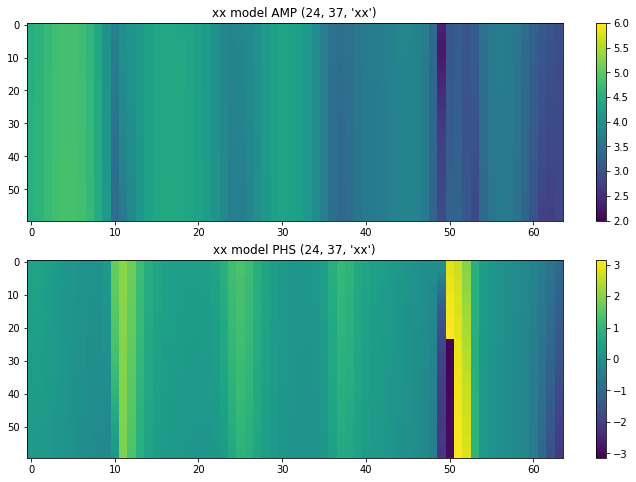

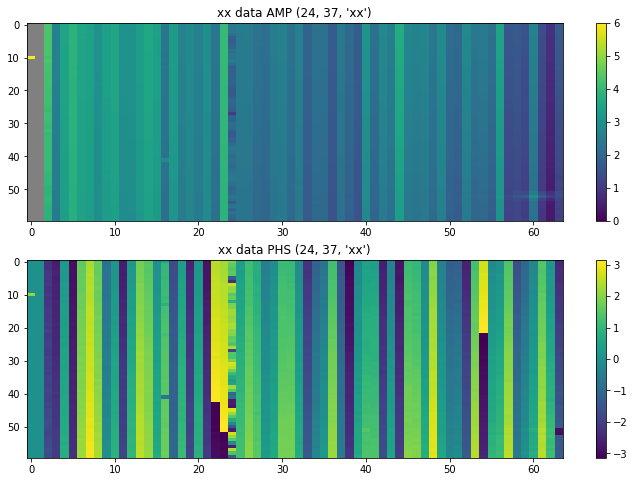

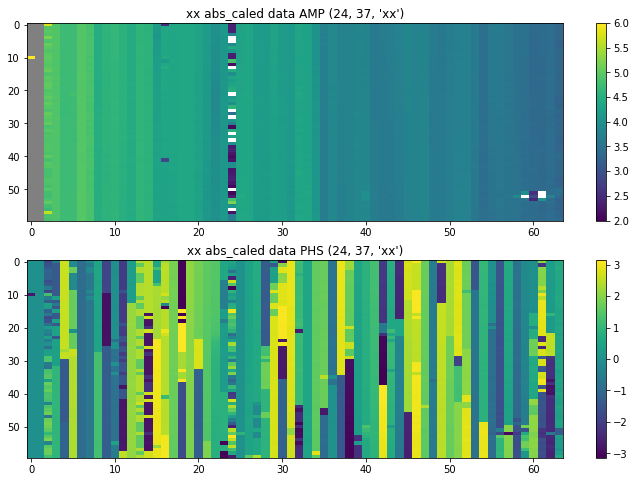

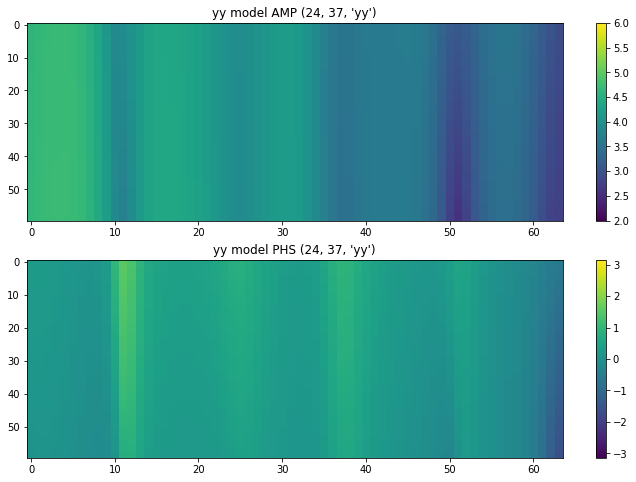

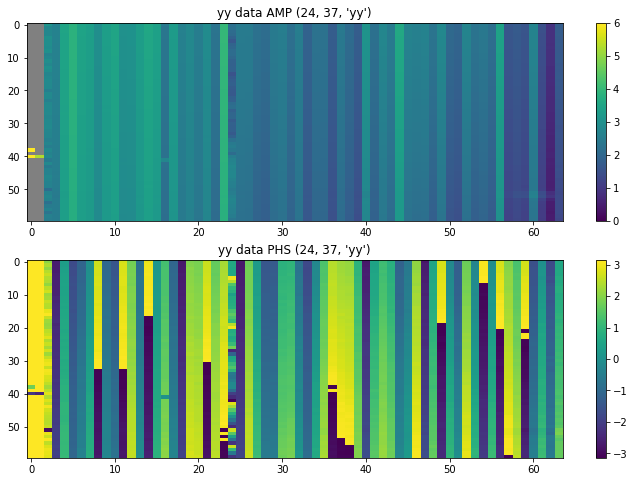

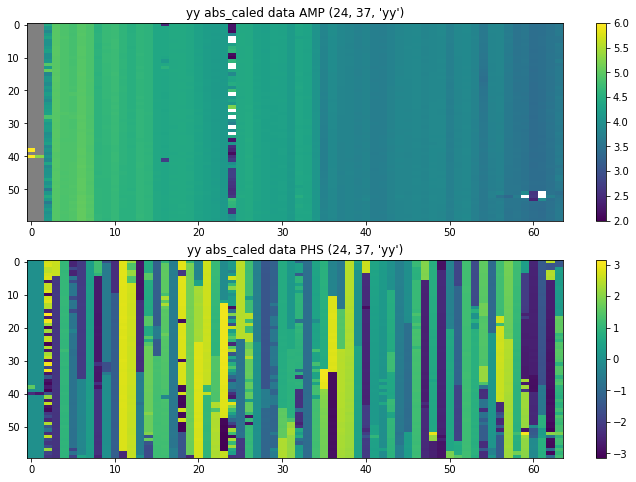

In [28]:
Absolute_Calibration_dred_mfreq_pscal = True

if Absolute_Calibration_dred_mfreq_pscal:
	
	for i in range(2):
		data_dred_mfreq_pscal[i] = LastUpdatedOrderedDict()
		pol = ['xx', 'yy'][i]
		if Absolute_Calibration_dred_mfreq:
			keys = dflags_dred_mfreq[i].keys()
			for key_index, key in enumerate(keys):
				#model_dred_mfreq[i][key] = fullsim_vis_mfreq[key_index, i]
				#data_dred_mfreq[i][key] = np.real(vis_data_dred_mfreq[i][:, :, key_index].transpose()) + np.abs(np.imag(vis_data_dred_mfreq[i][:, :, key_index].transpose()))*1j #[pol][freq,time,ubl_index].transpose()
				data_dred_mfreq_pscal[i][key] = vis_data_dred_mfreq_pscal[i][:, :, key_index].transpose() #[pol][freq,time,ubl_index].transpose()
			if add_Autobsl:
				model_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_vis_mfreq[i] # not lose generality, choose the first anntena in the first UBL for autocorrelation calibraiton.
				data_dred_mfreq_pscal[i][keys[0][0], keys[0][0], keys[0][2]] = autocorr_data_mfreq[i] # add the autocorrelation of first antenna in the first UBL as the last line in visibility.
				cdflags_dred_mfreq[i][keys[0][0], keys[0][0], keys[0][2]] = np.array([[False]*autocorr_data_mfreq[i].shape[1]]*autocorr_data_mfreq[i].shape[0])
				auto_select_dred_mfreq_pscal[i] = (keys[0][0], keys[0][0], keys[0][2])
			print(dflags_dred_mfreq[i].keys())
			print(dflags_dred_mfreq[i].keys()[0][0])
				
		
				
	re_cal_times = 3

	for i in range(2):
		pol = ['xx', 'yy'][i]
		re_cal = 0
		
		if Absolute_Calibration_dred_mfreq_pscal:
			for re_cal in range(re_cal_times): # number of times of absolute calibration
				if re_cal == 0:
					model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
					# instantiate class
					AC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
					# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
					AC_dred_mfreq_pscal[i].delay_lincal(kernel=(1, 11), medfilt=True, time_avg=True, solve_offsets=True)
				else:
					#model_dred_mfreq[i], interp_flags_dred_mfreq[i] = hc.abscal.interp2d_vis(model_dred_mfreq[i], lsts, flist[i], lsts, flist[i])
					# instantiate class
					AC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], abs_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
					# kernel is median filter kernel, chosen to produce time-smooth output delays for this particular dataset
					AC_dred_mfreq_pscal[i].delay_lincal(kernel=(1, 3), medfilt=True, time_avg=True, solve_offsets=True)
				# apply to data
				delay_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(AC_dred_mfreq_pscal[i].data, (AC_dred_mfreq_pscal[i].ant_dly_gain))
				# instantiate class
				DAC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], delay_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# avg phase solver
				DAC_dred_mfreq_pscal[i].phs_logcal(avg=True)
				# apply to data
				dly_phs_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(DAC_dred_mfreq_pscal[i].data, (DAC_dred_mfreq_pscal[i].ant_phi_gain))
				# instantiate class
				DPAC_dred_mfreq_pscal[i] = hc.abscal.AbsCal(model_dred_mfreq[i], dly_phs_corr_data_dred_mfreq_pscal[i], antpos=antpos[i], wgts=wgts_dred_mfreq[i], freqs=flist[i])
				# run amp linsolve
				DPAC_dred_mfreq_pscal[i].abs_amp_logcal()
				# run phs linsolve
				DPAC_dred_mfreq_pscal[i].TT_phs_logcal(zero_psi=False, four_pol=False)
				# apply to data
				abs_corr_data_dred_mfreq_pscal[i] = hc.abscal.apply_gains(DPAC_dred_mfreq_pscal[i].data, 
										(DPAC_dred_mfreq_pscal[i].abs_psi_gain, DPAC_dred_mfreq_pscal[i].TT_Phi_gain, DPAC_dred_mfreq_pscal[i].abs_eta_gain), gain_convention='multiply')
									
			vis_data_dred_mfreq_pscal_abscal[i] = np.zeros_like(vis_data_dred_mfreq_pscal[i], dtype='complex128')
			for key_id, key in enumerate(dflags_dred_mfreq[i].keys()):
				vis_data_dred_mfreq_pscal_abscal[i][:, :, key_id] = abs_corr_data_dred_mfreq_pscal[i][key].transpose()
				#vis_data_dred_mfreq_pscal_abscal[i][:, :, key_id] = np.real(abs_corr_data_dred_mfreq_pscal[i][key].transpose()) + np.abs(np.imag(abs_corr_data_dred_mfreq_pscal[i][key].transpose()))*1j
			if add_Autobsl:
				autocorr_data_dred_mfreq_pscal_abscal[i] = abs_corr_data_dred_mfreq_pscal[i][auto_select_dred_mfreq_pscal[i]]
			else:
				autocorr_data_dred_mfreq_pscal_abscal[i] = autocorr_vis_mfreq[i]
				
			vis_data_dred_pscal_abscal[i] = vis_data_dred_mfreq_pscal_abscal[i][index_freq[i], :, :]
			if add_Autobsl: 
				autocorr_data_dred_pscal_abscal[i] = autocorr_data_dred_mfreq_pscal_abscal[i][:, index_freq[i]]
			else:
				autocorr_data_dred_pscal_abscal[i] = autocorr_vis_mfreq[i][:, index_freq[i]]
			
	for i in range(2):
		pol = ['xx', 'yy'][i]
		
		if Absolute_Calibration_dred_mfreq_pscal:								
			plt.figure(85000000+10*i)
			fig4[i], axes4[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4[i][0])
			uvt.plot.waterfall(AC_dred_mfreq_pscal[i].model[bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' model AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4[i][1])
			uvt.plot.waterfall(AC_dred_mfreq_pscal[i].model[bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' model PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)			
			#plt.cla()
				
			plt.figure(95000000+10*i)
			fig4_data[i], axes4_data[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4_data[i][0])
			uvt.plot.waterfall(data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=6)
			plt.colorbar()
			plt.title(pol + ' data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4_data[i][1])
			uvt.plot.waterfall(data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			#plt.cla()		
				
			####################### after ABS Calibration #########################	
			plt.figure(8500000+10*i)
			fig4_data_abscorr[i], axes4_data_abscorr[i] = plt.subplots(2, 1, figsize=(12, 8))
			plt.sca(axes4_data_abscorr[i][0])
			uvt.plot.waterfall(abs_corr_data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='log', mx=6, drng=4)
			plt.colorbar()
			plt.title(pol + ' abs_caled data AMP {}'.format(bl_dred_mfreq_pscal[i]))
			plt.sca(axes4_data_abscorr[i][1])
			uvt.plot.waterfall(abs_corr_data_dred_mfreq_pscal[i][bl_dred_mfreq_pscal[i]], mode='phs', mx=np.pi, drng=2*np.pi)
			plt.colorbar()
			plt.title(pol + ' abs_caled data PHS {}'.format(bl_dred_mfreq_pscal[i]))
			plt.show(block=False)
			#plt.cla()
	

In [29]:
################################### Store Visibility Data and prepare to Delete Variable ##################################
data_vis_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
data_vis_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
vis_data[0].astype('complex128').tofile(data_vis_xx_filename)
vis_data[1].astype('complex128').tofile(data_vis_yy_filename)

data_vis_dred_xx_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_xx_dred.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
data_vis_dred_yy_filename = script_dir + '/../Output/%s_%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_dred_yy_dred.simvis'%(INSTRUMENT, freq, nUBL_used+1, nt_used, nside_standard, bnside)
vis_data_dred[0].astype('complex128').tofile(data_vis_dred_xx_filename)
vis_data_dred[1].astype('complex128').tofile(data_vis_dred_yy_filename)

data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%s_dred_mfreq.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%s_dred_mfreq.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[1]), np.max(flist[1]), len(flist[1]))
vis_data_dred_mfreq[0].astype('complex128').tofile(data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq[1].astype('complex128').tofile(data_vis_dred_mfreq_yy_filename)

abscal_data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_mfreq%s-%s-%s_dred_mfreq_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[0]), np.max(flist[0]), len(flist[0]))
abscal_data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_mfreq%s-%s-%s_dred_mfreq_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, np.min(flist[1]), np.max(flist[1]), len(flist[1]))
vis_data_dred_mfreq_abscal[0].astype('complex128').tofile(abscal_data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq_abscal[1].astype('complex128').tofile(abscal_data_vis_dred_mfreq_yy_filename)

abscal_data_vis_dred_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_dred_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, freq)
abscal_data_vis_dred_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_dred_abscal.simvis'%(INSTRUMENT, nUBL_used+1, nt_used, nside_standard, bnside, freq)
vis_data_dred_abscal[0].astype('complex128').tofile(abscal_data_vis_dred_xx_filename)
vis_data_dred_abscal[1].astype('complex128').tofile(abscal_data_vis_dred_yy_filename)

pscal_data_vis_dred_mfreq_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_dred_mfreq_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
pscal_data_vis_dred_mfreq_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_dred_mfreq_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
vis_data_dred_mfreq_pscal[0].astype('complex128').tofile(pscal_data_vis_dred_mfreq_xx_filename)
vis_data_dred_mfreq_pscal[1].astype('complex128').tofile(pscal_data_vis_dred_mfreq_yy_filename)

pscal_data_vis_dred_xx_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_xx_%s_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
pscal_data_vis_dred_yy_filename = script_dir + '/../Output/%s_p2_u%i_t%i_nside%i_bnside%i_vis_data_yy_%s_pscal.simvis'%(INSTRUMENT, nUBL, nt, nside_standard, bnside, freq)
vis_data_dred_pscal[0].astype('complex128').tofile(pscal_data_vis_dred_xx_filename)
vis_data_dred_pscal[1].astype('complex128').tofile(pscal_data_vis_dred_yy_filename)

sys.stdout.flush()


In [30]:
#print noise['x']

In [31]:
################
####read data and N
################
data = {}
Ni = {}
data_shape = {}
ubl_sort = {}
data_filename = full_sim_filename

Use_Simulation_noise = True
From_File_Data = True


for p in ['x', 'y']:
	pol = p + p
	print "%i UBLs to include, longest baseline is %i wavelengths" % (
	nUBL_used, np.max(np.linalg.norm(used_common_ubls, axis=1)) / (C / freq))
	if p == 'x':
		pol_index = 0
		sim_var_filename = sim_var_xx_filename
		sim_vis_filename = sim_vis_xx_filename
		try:
			data_var_filename = data_var_xx_filename
			data_var_filename_pscal = data_var_xx_filename_pscal
		except:
			pass
	elif p == 'y':
		pol_index = 1
		sim_var_filename = sim_var_yy_filename
		sim_vis_filename = sim_vis_yy_filename
		try:
			data_var_filename = data_var_yy_filename
			data_var_filename_pscal = data_var_yy_filename_pscal
		except:
			pass

	# get Ni (1/variance) and data
#	var_filename = datadir + tag + '_%s%s_%i_%i' % (p, p, nt, nUBL) + vartag + '.var'
#	Ni[pol] = 1. / (N[p].reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
	if Use_SimulatedData == 1:
#		Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt_used, nUBL_used))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() * jansky2kelvin ** 2)
		Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
		data[pol] = np.fromfile(sim_vis_filename, dtype='complex128').reshape((nUBL_used, nt_used))
	else:
		if INSTRUMENT == 'miteor':
			if Use_Simulation_noise:
				Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten())
			else:
				Ni[pol] = 1. / var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			data[pol] = vis_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')			
			data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0].conjugate()
#			data[pol] = (data[pol].flatten() * jansky2kelvin).conjugate()  # there's a conjugate convention difference
			data[pol] = (data[pol].flatten()).conjugate()  # there's a conjugate convention difference
		elif INSTRUMENT == 'hera47':
			if From_File_Data:
				if Use_PsAbsCal:
					Ni[pol] = 1. / (np.fromfile(data_var_filename_pscal, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten()) #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
				elif Use_Fullsim_Noise:
					Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
				else:
					Ni[pol] = 1. / (np.fromfile(data_var_filename, dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten()) #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			else:
				if Use_PsAbsCal:
					Ni[pol] = 1. / N_data_pscal[p].reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
				elif Use_Fullsim_Noise:
					Ni[pol] = 1. / (np.fromfile(sim_var_filename, dtype='complex128').reshape((nt_used, nUBL_used)).transpose().flatten())
				else:
					Ni[pol] = 1. / N_data[p].reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1].flatten() #var_data[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1].flatten()
			if From_File_Data:
				if Use_PsAbsCal:
					data[pol] = np.fromfile(globals()['pscal_data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
				elif Use_AbsCal:				
					data[pol] = np.fromfile(globals()['abscal_data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
				else:
					data[pol] = np.fromfile(globals()['data_vis_dred_' + pol + '_filename'], dtype='complex128').reshape((nt, nUBL))[tmask].transpose()[abs(ubl_index[p]) - 1]
			else:
				if Use_PsAbsCal:
					data[pol] = vis_data_dred_pscal[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = data[pol].flatten()#.conjugate()  # there's a conjugate convention difference
				elif Use_AbsCal:				
					data[pol] = vis_data_dred_abscal[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = data[pol].flatten()#.conjugate()  # there's a conjugate convention difference
				else:
					data[pol] = vis_data_dred[pol_index][tmask].transpose()[abs(ubl_index[p]) - 1] #= (time_vis_data[:,1:,1::3] + time_vis_data[:,1:,2::3] * 1j).astype('complex64')
					#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
					data[pol] = (data[pol].flatten() * jansky2kelvin)#.conjugate()  # there's a conjugate convention difference
			#data[pol][ubl_index[p] < 0] = data[pol][ubl_index[p] < 0]#.conjugate()
			#data[pol] = (data[pol].flatten() * jansky2kelvin)#.conjugate()  # there's a conjugate convention difference
	data_shape[pol] = (nUBL_used, nt_used)
	ubl_sort[p] = np.argsort(la.norm(used_common_ubls, axis=1))
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024)
sys.stdout.flush()

# Merge data
data = np.array([data['xx'], data['yy']]).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
data = np.concatenate((np.real(data), np.imag(data))).astype('complex128')
Ni = np.concatenate((Ni['xx'], Ni['yy'])).reshape([2] + list(data_shape['xx'])).transpose(
	(1, 0, 2)).flatten()
Ni = np.concatenate((Ni * 2, Ni * 2))

sys.stdout.flush()

def get_complex_data(real_data, nubl=nUBL_used, nt=nt_used):
	if len(real_data.flatten()) != 2 * nubl * 2 * nt:
		raise ValueError("Incorrect dimensions: data has length %i where nubl %i and nt %i together require length of %i."%(len(real_data), nubl, nt, 2 * nubl * 2 * nt))
	input_shape = real_data.shape
	real_data.shape = (2, nubl, 2, nt)
	result = real_data[0] + 1.j * real_data[1]
	real_data.shape = input_shape
	return result

def stitch_complex_data(complex_data):
	return np.concatenate((np.real(complex_data.flatten()), np.imag(complex_data.flatten()))).astype('complex128')


9 UBLs to include, longest baseline is 14 wavelengths
9 UBLs to include, longest baseline is 14 wavelengths
Memory usage: 3724012.000MB


In [32]:
##################### Delete or Erase Data #######################
Erase = False
if Erase:
	model_sf = {}
	model_dred = {}
	model_dred_mfreq = {}
	#data = {}
	data_sf = {}
	data_dred = {}
	data_dred_mfreq = {}
	AC = {}
	AC_sf = {}
	AC_dred = {}
	AC_dred_mfreq = {}
	freq_to_cal = [freq]
	fulldflags = {}
	auto_select_dred_mfreq = {}

	#	try:
	#		cdata = copy.deepcopy(data)
	#	except:
	#		pass

	try:
		del(dflags_sf) 
		#del(cdflags_sf)
	except:
		pass
		
	try:
		del(dflags_dred) 
		#del(cdflags_dred)
	except:
		pass

	try:
		del(dflags)
		#del(cdflags) 
	except:
		pass

	try:
		del(dflags_dred_mfreq)
		#del(cdflags_dred_mfreq) 
	except:
		pass
		
	#cwgts = copy.deepcopy(wgts)
	#cwgts_dred = copy.deepcopy(wgts_dred)

	bl_select = 0
	#bl = dflags.keys()[bl_select] #dflags and dflags_yy #[(24, 53, 'xx')
	fig = {}
	axes = {}
	fig_data = {}
	axes_data = {}

	bl_dred_select = 0
	#bl_dred = dflags_dred[0].keys()[bl_dred_select] #[(25, 37, 'xx')
	fig2 = {}
	axes2 = {}
	fig2_data = {}
	axes2_data = {}

	bl_dred_mfreq_select = 8
	#bl_dred_mfreq = [dflags_dred_mfreq[0].keys()[bl_dred_mfreq_select], dflags_dred_mfreq[1].keys()[bl_dred_mfreq_select]]  #[(25, 37, 'xx'), (25, 37, 'yy')]
	fig3 = {}
	axes3 = {}
	fig3_data = {}
	axes3_data = {}
	fig3_data_abscorr = {} 
	axes3_data_abscorr = {}

	delay_corr_data = {}
	delay_corr_data_sf = {}
	delay_corr_data_dred = {}
	delay_corr_data_dred_mfreq = {}
	DAC = {}
	DAC_sf = {}
	DAC_dred = {}
	DAC_dred_mfreq = {}
	dly_phs_corr_data = {}
	dly_phs_corr_data_sf = {}
	dly_phs_corr_data_dred = {}
	dly_phs_corr_data_dred_mfreq = {}
	DPAC = {}
	DPAC_sf = {}
	DPAC_dred = {}
	DPAC_dred_mfreq = {}
	abs_corr_data = {}
	abs_corr_data_sf = {}
	abs_corr_data_dred = {}
	abs_corr_data_dred_mfreq = {}

	vis_data_dred_mfreq_abscal = [[], []]
	autocorr_data_dred_mfreq_abscal = [[], []]
	vis_data_dred_abscal = [[], []]
	autocorr_data_dred_abscal = [[], []]


	Del = True
	if Del:
		try:
			del(vis_data)
			del(vis_data_dred)
		except:
			pass
		try:
			del(vis_data_mfreq)
			del(vis_data_dred_mfreq)
		except:
			pass	
			
			
		try:
			del(N_data)
		except:
			pass
		try:
			del(noise_data)
		except:
			pass
		try:
			del(var_data)
		except:
			pass
	#	try:
	#		del(var_data)
	#	except:
	#		pass

sys.stdout.flush()


In [33]:
print Ni

[3.07213470e-04+0.j 3.66949804e-03+0.j 4.41389713e-05+0.j ...
 1.21934894e-04+0.j 6.01709621e-05+0.j 5.05568063e-05+0.j]


In [34]:
# pre_ampcal = False

In [35]:
#pre_ampcal = True

In [36]:
################################
################################
####pre_calibrate################
################################
################################
#####1. antenna based calibration#######
for cal_index in range(1):
	if cal_index == 0:
		raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
#	if pre_ampcal:
#		pre_ampcal = False if cal_index == 0 else True
#		cal_index += 1
#	else:
#		cal_index = 2 
	if antpairs is not None:
		used_antpairs = antpairs[abs(ubl_index['x'])-1]
		n_usedants = np.unique(used_antpairs)
	#####2. re-phasing and crosstalk#######
	additive_A = np.zeros((nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)).astype('complex128')

	#put in autocorr regardless of whats saved on disk
	for p in range(2):
		additive_A[:, p, :, 0] = fullsim_vis[:, p]
		for i in range(nUBL_used):
			additive_A[i, p, :, 1 + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]
			additive_A[i, p, :, 1 + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]
	additive_A.shape = (nUBL_used * 2 * nt_used, 1 + 4 * nUBL_used)

	if pre_calibrate:
		#import omnical.calibration_omni as omni
		#raw_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
		#raw_Ni = np.copy(Ni)

		real_additive_A = np.concatenate((np.real(additive_A), np.imag(additive_A)), axis=0).astype('complex128')
		if pre_ampcal:#if pre_ampcal, allow xx and yy to fit amp seperately
			n_prefit_amp = 2
			real_additive_A.shape = (2 * nUBL_used, 2, nt_used, 1 + 4 * nUBL_used)
			real_additive_A_expand = np.zeros((2 * nUBL_used, 2, nt_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
			for i in range(n_prefit_amp):
				real_additive_A_expand[:, i, :, i] = real_additive_A[:, i, :, 0]
			real_additive_A_expand[..., n_prefit_amp:] = real_additive_A[..., 1:]
			real_additive_A = real_additive_A_expand
			real_additive_A.shape = (2 * nUBL_used * 2 * nt_used, n_prefit_amp + 4 * nUBL_used)
		else:
			n_prefit_amp = 1

		additive_AtNiA = np.empty((n_prefit_amp + 4 * nUBL_used, n_prefit_amp + 4 * nUBL_used), dtype='complex128')
		if pre_addcal:
			ATNIA(real_additive_A, Ni, additive_AtNiA)
			additive_AtNiAi = sla.inv(additive_AtNiA)
		else:
			real_additive_A[..., n_prefit_amp:] = 0.
			ATNIA(real_additive_A, Ni, additive_AtNiA)
			additive_AtNiAi = sla.pinv(additive_AtNiA)

		niter = 0
		rephases = np.zeros((2,2))
		additive_term = np.zeros_like(data)
		additive_term_incr = np.zeros_like(data)
		while (niter == 0 or la.norm(rephases) > .001 or la.norm(additive_term_incr) / la.norm(data) > .001) and niter < 500:
			niter += 1

			if pre_phscal:
				cdata = get_complex_data(data)
				for p, pol in enumerate(['xx', 'yy']):
					#rephase = omni.solve_phase_degen_fast(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
					rephase = solve_phase_degen(cdata[:, p].transpose(), cdata[:, p].transpose(), fullsim_vis[:, p].transpose(), fullsim_vis[:, p].transpose(), used_common_ubls)
					rephases[p] = rephase
					if p == 0:
						print 'pre process rephase', pol, rephase,
					else:
						print pol, rephase
					cdata[:, p] *= np.exp(1.j * used_common_ubls[:, :2].dot(rephase))[:, None]
				data = stitch_complex_data(cdata).astype('complex128')

			additive_sol = additive_AtNiAi.dot(np.transpose(real_additive_A).dot(data * Ni))
			print '>>>>>>>>>>>>>additive fitting amp', additive_sol[:n_prefit_amp],
			additive_term_incr = real_additive_A[:, n_prefit_amp:].dot(additive_sol[n_prefit_amp:])
			data -= additive_term_incr
			additive_term += additive_term_incr
			print "additive fraction", la.norm(additive_term_incr) / la.norm(data),

		cadd = get_complex_data(additive_term)

		if pre_ampcal:
			data = stitch_complex_data(get_complex_data(data) / additive_sol[:n_prefit_amp, None])
			if Use_PsAbsCal and not comply_ps2mod_autocorr:
				Ni = stitch_complex_data(get_complex_data(Ni) * additive_sol[:n_prefit_amp, None]**2)
			additive_term = stitch_complex_data(get_complex_data(additive_term) / additive_sol[:n_prefit_amp, None])
			
			print(additive_sol[:n_prefit_amp])
			
print 'saving data to', os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i.npz'%(nside_standard, bnside)
np.savez(os.path.dirname(data_filename) + '/' + INSTRUMENT + tag + datatag + vartag + '_gsmcal_n%i_bn%i.npz'%(nside_standard, bnside),
		 data=data,
		 simdata=stitch_complex_data(fullsim_vis),
		 psdata=[stitch_complex_data(vis) for vis in pt_vis],
		 pt_sources=pt_sources,
		 ubls=used_common_ubls,
		 tlist=lsts,
		 Ni=Ni,
		 freq=freq)
	
	


Estimated time for A 2160 by 38 4.054752e-05 minutes pre process rephase xx [ 0.12481946 -0.03067976] yy [ 0.00047314 -0.00041053]
>>>>>>>>>>>>>additive fitting amp [1.20836952+0.j 0.534787  +0.j] additive fraction 1.0675283982855874 pre process rephase xx [0.00620538 0.00704058] yy [-0.00455176  0.00860997]
>>>>>>>>>>>>>additive fitting amp [1.1844469 +0.j 0.59417211+0.j] additive fraction 0.11498354505985511 pre process rephase xx [0.00576   0.0068234] yy [-0.00350592  0.0072183 ]
>>>>>>>>>>>>>additive fitting amp [1.15809186+0.j 0.64026518+0.j] additive fraction 0.10028146625514972 pre process rephase xx [0.00527315 0.00650414] yy [-0.00270109  0.00604255]
>>>>>>>>>>>>>additive fitting amp [1.13018835+0.j 0.67503826+0.j] additive fraction 0.08718990928637078 pre process rephase xx [0.00478025 0.00621068] yy [-0.00214856  0.00512048]
>>>>>>>>>>>>>additive fitting amp [1.100858  +0.j 0.70142378+0.j] additive fraction 0.07692134770023495 pre process rephase xx [0.00446789 0.006047  ] y

In [37]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(raw_data)/la.norm(data)
print #la.norm(raw_Ni)
print la.norm(Ni)
print data
print fullsim_vis

578660.5811811045
436544.36865000287
490013.22120103094
0.7544048840495958

529.4272174797538
[-9014.08555914+0.j -1743.82835615+0.j -1616.60788672+0.j ...
   326.51898191+0.j  1558.83415534+0.j  2381.62956118+0.j]
[[[ -6933.77123406+9.77620029e+02j  -6932.71429535+9.90285496e+02j
    -6931.54735726+1.00292621e+03j ...  -6710.71177322+1.62681606e+03j
    -6702.61150573+1.63660432e+03j  -6694.40249167+1.64631833e+03j]
  [-10985.34344495+8.07110421e+02j -10987.25437447+8.16943652e+02j
   -10989.07214343+8.26744406e+02j ... -10947.26104782+1.29942875e+03j
   -10943.28959943+1.30641289e+03j -10939.21712817+1.31333067e+03j]]

 [[ -4287.04953807-8.39421014e+02j  -4295.11989577-8.27811111e+02j
    -4303.13823568-8.16059590e+02j ...  -4573.57220637+1.74733880e+01j
    -4574.12338644+3.55429442e+01j  -4574.47470352+5.36660703e+01j]
  [ -2498.33371822-7.36639388e+02j  -2509.05309706-7.28157299e+02j
    -2519.7313397 -7.19513860e+02j ...  -2941.85886904-2.34884758e+01j
    -2945.25266905-7.095240

In [38]:
print additive_sol[0], additive_sol[1], n_prefit_amp
print (additive_sol[0] * (pre_ampcal)+(not pre_ampcal))
print additive_sol[:n_prefit_amp, None]
print pre_ampcal

(0.7231495733030897+0j) (0.7789227981784279+0j) 2
(0.7231495733030897+0j)
[[0.72314957+0.j]
 [0.7789228 +0.j]]
True


In [39]:
print la.norm(data)
print la.norm(raw_data)
print la.norm(fullsim_vis)
print la.norm(fullsim_vis)/la.norm(data)
#print la.norm(raw_Ni)
print la.norm(Ni)
print Ni
print Ni.max()
print Ni**-0.5

578660.5811811045
436544.36865000287
490013.22120103094
0.8468059465893886
529.4272174797538
[3.07213470e-04+0.j 3.66949804e-03+0.j 4.41389713e-05+0.j ...
 1.21934894e-04+0.j 6.01709621e-05+0.j 5.05568063e-05+0.j]
(368.03029540620895+0j)
[ 57.05318222+0.j  16.50808399+0.j 150.51815844+0.j ...  90.55991315+0.j
 128.91591105+0.j 140.64042952+0.j]


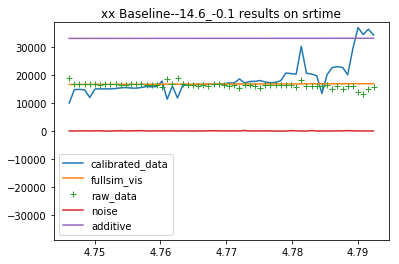

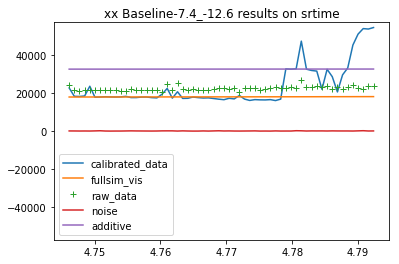

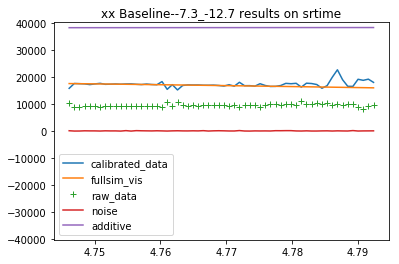

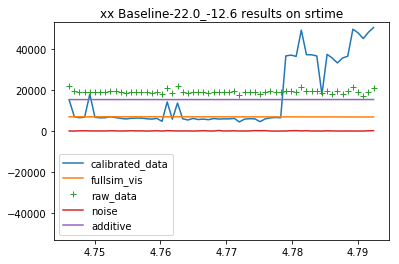

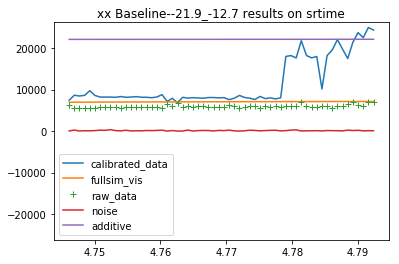

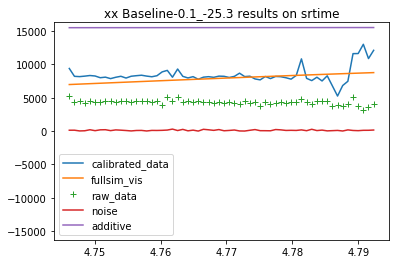

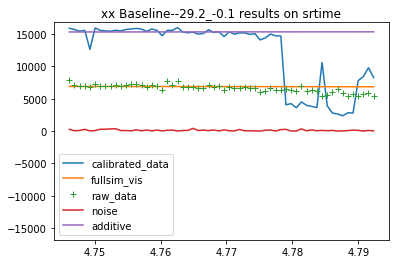

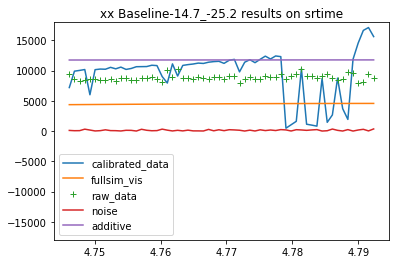

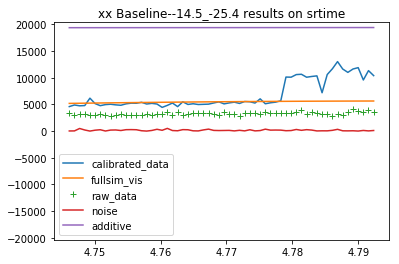

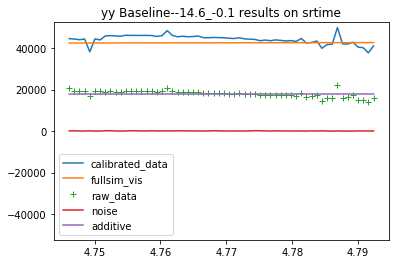

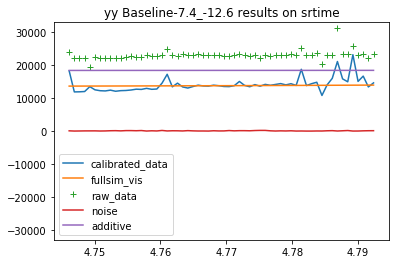

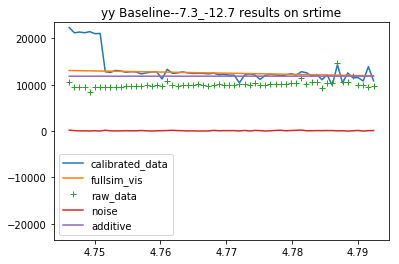

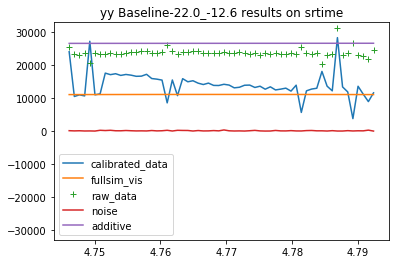

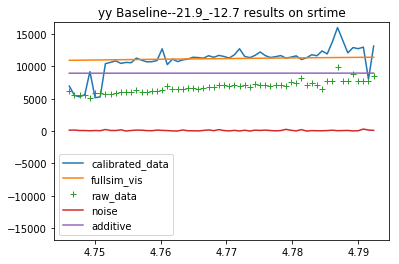

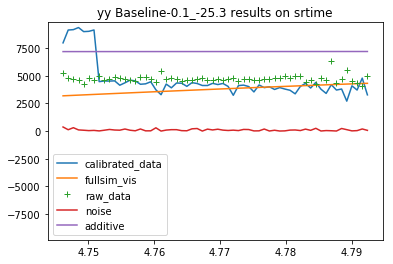

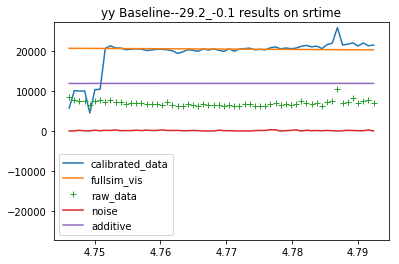

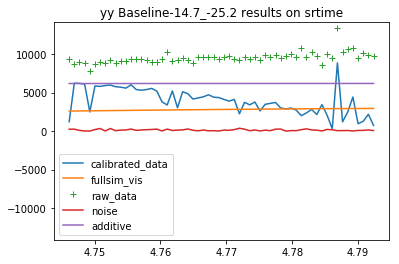

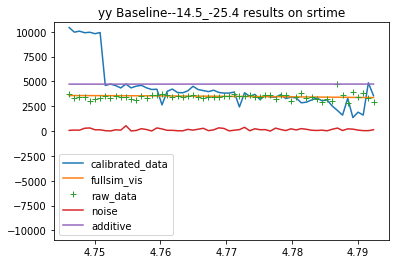

In [40]:
if plot_data_error:
	#plt.clf()
	
	cdata = get_complex_data(data)
	crdata = get_complex_data(raw_data) #/ (additive_sol[0] * (pre_ampcal) + (not pre_ampcal))
	cNi = get_complex_data(Ni)
	

	fun = np.abs
	srt = sorted((lsts - lst_offset)%24.+lst_offset)
	asrt = np.argsort((lsts - lst_offset)%24.+lst_offset)
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x']
	figure = {}
#		plt.figure(400)
#		plt.subplots_adjust(hspace=1.2,wspace=0.7)
	for p in range(2):
#			plt.figure(400+10*p)
#			plt.subplots_adjust(hspace=1.2,wspace=0.7)
#			for nu, u in enumerate(us):
#				
#				plt.subplot(5, (len(us) + 4) / 5, nu + 1)
#				plt.plot(srt, fun(cdata[u, p][asrt]))
#				plt.plot(srt, fun(fullsim_vis[u, p][asrt]))
#				plt.plot(srt, fun(crdata[u, p][asrt]))
#				plt.plot(srt, fun(cNi[u, p][asrt])**-.5)
#				if pre_calibrate:
#					plt.plot(srt, fun(cadd[u, p][asrt]))
#				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), 5 * np.max(np.abs(fun(cNi[u, p]))), np.max(fun(cadd[u, p]))])
#				plt.title("%s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
#				plt.ylim([-1.05*data_range, 1.05*data_range])		
#			plt.savefig(script_dir + '/../Output/%s-dipole-precal_data_error-fullvis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, ['xx','yy'][p], beam_freqs[ind], bnside, nside_standard))
#			plt.show(block=False)
		
		#plt.figure(500+10*p)
		#plt.subplots_adjust(hspace=1.2,wspace=0.7)
		for nu, u in enumerate(us):
			plt.figure(5000+100*p+nu)
			#plt.subplot(5, (len(us) + 4) / 5, nu + 1)
			figure[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
			figure[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
			figure[3], = plt.plot(srt, fun(crdata[u, p][asrt]), '+', label='raw_data')
			figure[4], = plt.plot(srt, fun(cNi[u, p][asrt])**-.5, label='Ni')
			if pre_calibrate:
				figure[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(fun(cadd[u, p]))]) #5 * np.max(np.abs(fun(cNi[u, p]))),
			else:
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(crdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p])))]) #5 * np.max(np.abs(fun(cNi[u, p])))
			plt.title("%s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.ylim([-1.05*data_range, 1.05*data_range])
			if pre_calibrate:
				plt.legend(handles=[figure[1], figure[2], figure[3], figure[4], figure[5]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise', 'additive'], loc=0)
			else:
				plt.legend(handles=[figure[1], figure[2], figure[3], figure[4]], labels=['calibrated_data', 'fullsim_vis', 'raw_data', 'noise'], loc=0)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Full_vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			
			
		#plt.gcf().clear()
		#plt.clf()
		#plt.close()

Del=True
if Del:
	try:
		del(crdata)
		del(cNi)
		del(cdata)
		del(cadd)
	except:
		pass
	
sys.stdout.flush()


In [41]:
################
####Use N and the par file generated by pixel_parameter_search to determine dynamic pixel parameters
################
if seek_optimal_threshs:
	par_result_filename = full_sim_filename.replace('.simvis', '_par_search.npz')
	par_file = np.load(par_result_filename)
	qualified_par_mask = (par_file['err_norm'] / np.sum(1./Ni)**.5) < dynamic_precision
	index_min_pix_in_mask = np.argmin(par_file['n_pix'][qualified_par_mask])
	thresh, valid_pix_thresh = par_file['parameters'][qualified_par_mask][index_min_pix_in_mask]
print "<<<<<<<<<<<<picked std thresh %.3f, pix thresh %.1e"%(thresh, valid_pix_thresh)

sys.stdout.flush()

<<<<<<<<<<<<picked std thresh 2.000, pix thresh 1.0e-04


In [42]:
########################################################################
########################processing dynamic pixelization######################
########################################################################
gsm_beamweighted = equatorial_GSM_standard * beam_weight
if AtNiA_only:
	valid_npix = pixel_scheme_number
	pixel_scheme_file = np.load(pixel_directory + 'pixel_scheme_%i_%s.npz'%(valid_npix,freq))
	fake_solution_map = pixel_scheme_file['gsm']
	thetas = pixel_scheme_file['thetas']
	phis= pixel_scheme_file['phis']
	sizes= pixel_scheme_file['sizes']
	nside_distribution= pixel_scheme_file['nside_distribution']
	final_index= pixel_scheme_file['final_index']
	npix = pixel_scheme_file['n_fullsky_pix']
	valid_pix_mask= pixel_scheme_file['valid_pix_mask']
	thresh= pixel_scheme_file['thresh']
else:
	nside_distribution = np.zeros(12 * nside_standard ** 2)
	final_index = np.zeros(12 * nside_standard ** 2, dtype=int)
	thetas, phis, sizes = [], [], []
	abs_thresh = np.mean(gsm_beamweighted) * thresh
	pixelize(gsm_beamweighted, nside_distribution, nside_standard, nside_start, abs_thresh,
			 final_index, thetas, phis, sizes)
	npix = len(thetas)
	valid_pix_mask = hpf.get_interp_val(gsm_beamweighted, thetas, phis, nest=True) > valid_pix_thresh * max(gsm_beamweighted)
	valid_npix = np.sum(valid_pix_mask)
	print '>>>>>>VALID NPIX =', valid_npix

	fake_solution_map = np.zeros_like(thetas)      
	for i in range(len(fake_solution_map)):
		fake_solution_map[i] = np.sum(equatorial_GSM_standard[final_index == i])
	fake_solution_map = fake_solution_map[valid_pix_mask]
	sizes = np.array(sizes)[valid_pix_mask]
	thetas = np.array(thetas)[valid_pix_mask]
	phis = np.array(phis)[valid_pix_mask]
	np.savez(pixel_directory + 'pixel_scheme_%i_%s.npz'%(valid_npix,freq), gsm=fake_solution_map, thetas=thetas, phis=phis, sizes=sizes, nside_distribution=nside_distribution, final_index=final_index, n_fullsky_pix=npix, valid_pix_mask=valid_pix_mask, thresh=thresh)#thresh is in there for idiotic reason  due to unneccessary inclusion of thresh in A filename

if not fit_for_additive:
	fake_solution = np.copy(fake_solution_map)
else:
	fake_solution = np.concatenate((fake_solution_map, np.zeros(4 * nUBL_used)))

def sol2map(sol):
	solx = sol[:valid_npix]
	full_sol = np.zeros(npix)
	full_sol[valid_pix_mask] = solx / sizes
	return full_sol[final_index]

def sol2additive(sol):
	return np.transpose(sol[valid_npix:].reshape(nUBL_used, 2, 2), (1, 0, 2))#ubl by pol by re/im before transpose


>>>>>>VALID NPIX = 10420


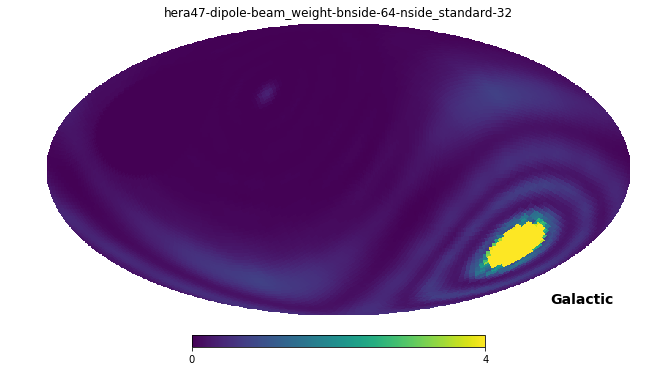

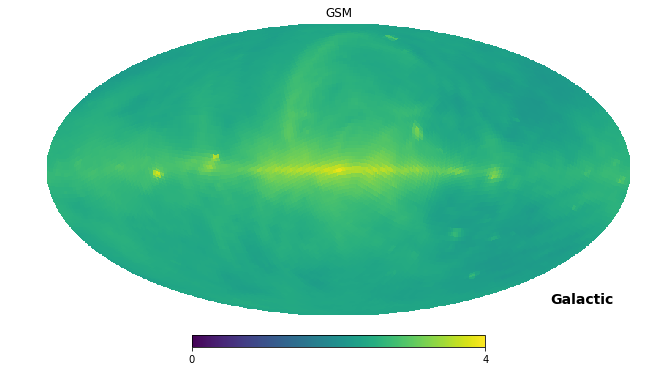

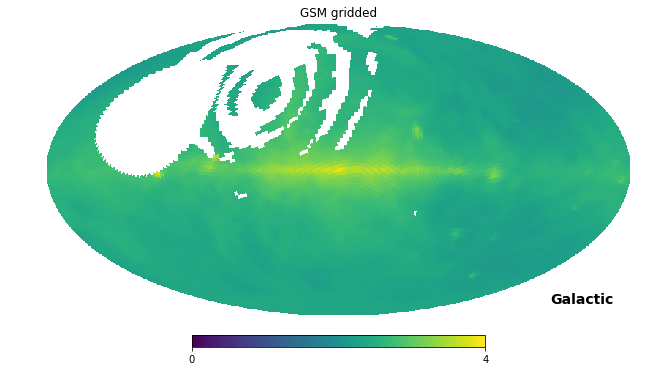

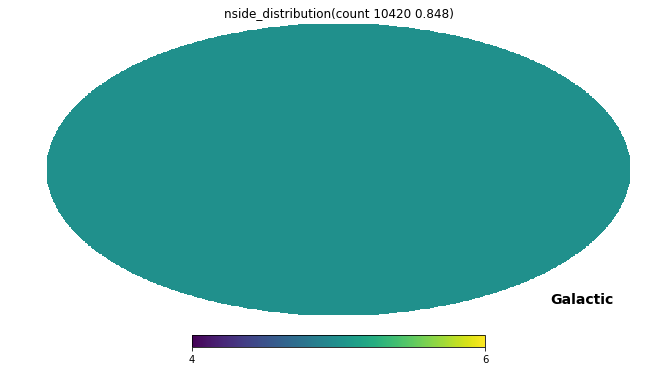

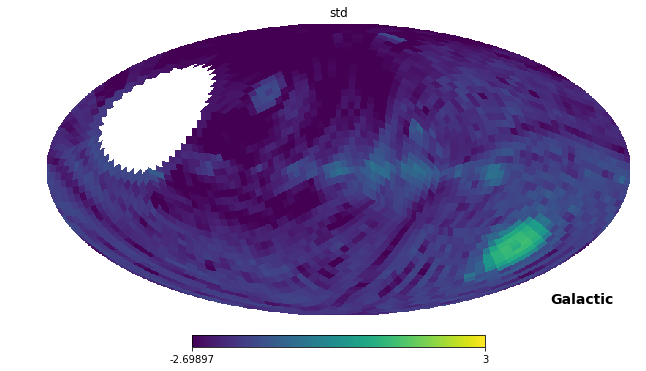

In [43]:
# final_index_filename = datadir + tag + '_%i.dyind%i_%.3f'%(nside_standard, npix, thresh)
# final_index.astype('float32').tofile(final_index_filename)
# sizes_filename = final_index_filename.replace('dyind', "dysiz")
# np.array(sizes).astype('float32').tofile(sizes_filename)
if plot_pixelization:
	##################################################################
	####################################sanity check########################
	###############################################################
	# npix = 0
	# for i in nside_distribution:
	# npix += i**2/nside_standard**2
	# print npix, len(thetas)
	stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
	plotcoord = 'CG'
    
	##################################################################
	####################################plotting########################
	###############################################################
	with warnings.catch_warnings():
		warnings.filterwarnings("ignore", category=RuntimeWarning)
		#plt.clf()
		plt.figure(50)
		hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s'%(INSTRUMENT, bnside, nside_standard), nest=True)
		plt.savefig(script_dir + '/../Output/%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
		plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%s-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
					 title='GSM gridded', nest=True)
		plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
					 coord=plotcoord,
					 title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
		plt.savefig(script_dir + '/../Output/nside_distribution-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std',
					 nest=True)
		plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()

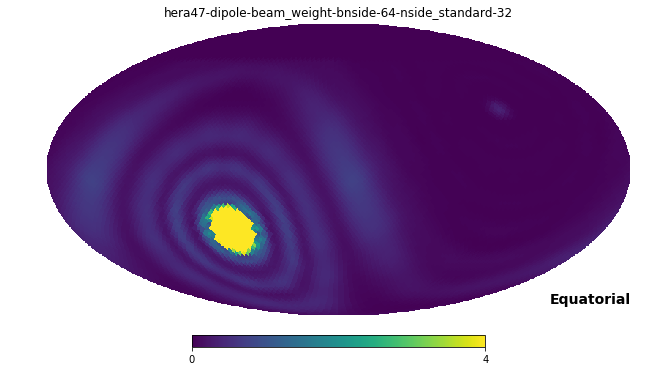

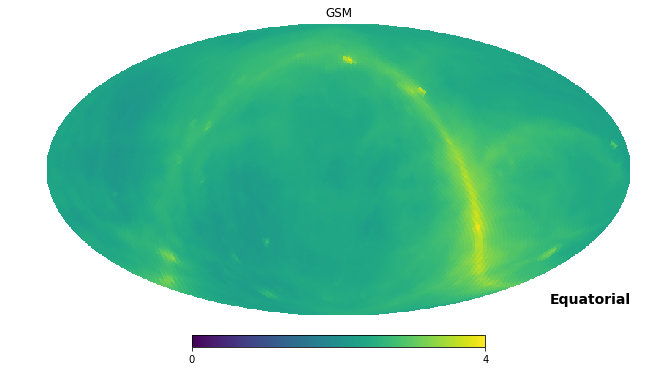

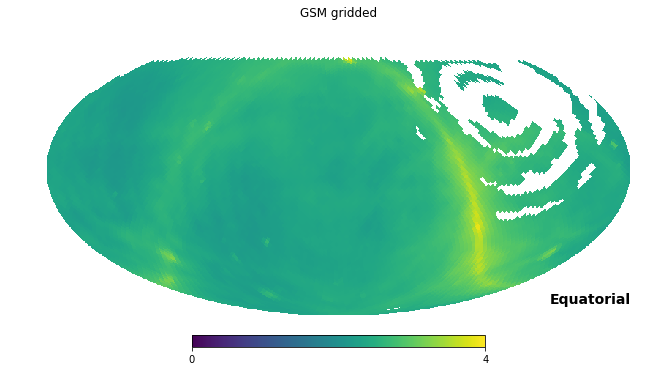

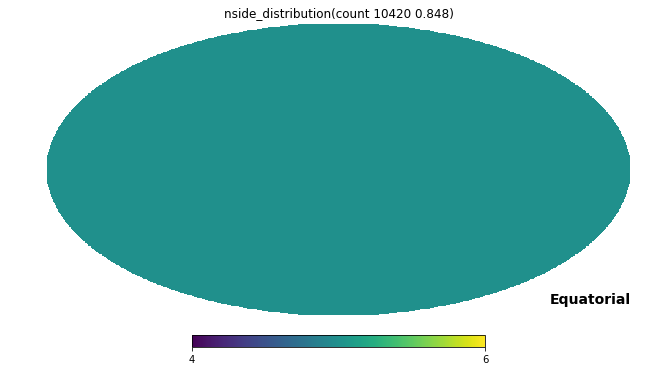

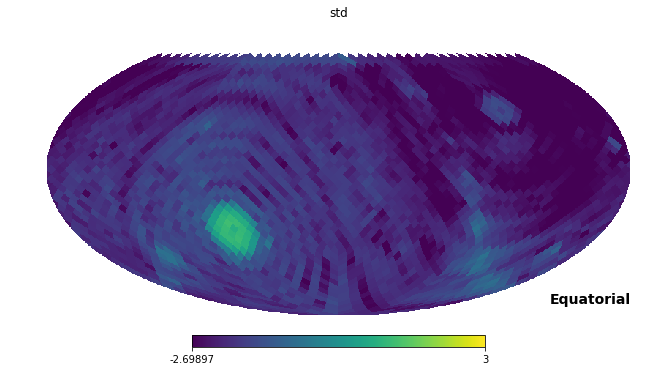

In [44]:
if plot_pixelization:
	##################################################################
	####################################sanity check########################
	###############################################################
	# npix = 0
	# for i in nside_distribution:
	# npix += i**2/nside_standard**2
	# print npix, len(thetas)

	stds = np.std((equatorial_GSM_standard * beam_weight).reshape(12 * nside_standard ** 2 / 4, 4), axis=1)
	plotcoord = 'C'
	##################################################################
	####################################plotting########################
	###############################################################
	with warnings.catch_warnings():
		warnings.filterwarnings("ignore", category=RuntimeWarning)
		#plt.clf()
		plt.figure(50)
		hpv.mollview(beam_weight, min=0, max=4, coord=plotcoord, title='%s-dipole-beam_weight-bnside-%s-nside_standard-%s'%(INSTRUMENT, bnside, nside_standard), nest=True)
		plt.savefig(script_dir + '/../Output/%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(equatorial_GSM_standard), min=0, max=4, coord=plotcoord, title='GSM', nest=True)
		plt.savefig(script_dir + '/../Output/GSM-3C-for-%s-%s-bnside-%s.pdf'%(INSTRUMENT, freq, bnside))
		hpv.mollview(np.log10(sol2map(fake_solution)[:len(equatorial_GSM_standard)]), min=0, max=4, coord=plotcoord,
					 title='GSM gridded', nest=True)
		plt.savefig(script_dir + '/../Output/maskedfsol_GSM-3C-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log2(nside_distribution), min=np.log2(nside_start), max=np.log2(nside_standard),
					 coord=plotcoord,
					 title='nside_distribution(count %i %.3f)' % (len(thetas), float(len(thetas)) / (12 * nside_standard ** 2)), nest=True)
		plt.savefig(script_dir + '/../Output/nside_distribution-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		hpv.mollview(np.log10(stds / abs_thresh), min=np.log10(thresh) - 3, max=3, coord=plotcoord, title='std',
					 nest=True)
		plt.savefig(script_dir + '/../Output/stds-beam_weight_GSM-%s-%s-dipole-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, freq, bnside, nside_standard))
		plt.show(block=False)
		#plt.gcf().clear()

In [45]:
##################################################################
####################compute dynamic A matrix########################
###############################################################
A_tag = 'A_dI'
A_filename = A_tag + '_u%i_t%i_p%i_n%i_%i_b%i_%.3f_v%.1f' % (nUBL_used, nt_used, valid_npix, nside_start, nside_standard, bnside, thresh, A_version)
A_path = datadir + tag + A_filename
AtNiA_tag = 'AtNiA_N%s'%vartag
if not fit_for_additive:
	AtNiA_tag += "_noadd"
elif crosstalk_type == 'autocorr':
	AtNiA_tag += "_autocorr"
if pre_ampcal:
	AtNiA_tag += "_ampcal"
AtNiA_filename = AtNiA_tag + A_filename
AtNiA_path = datadir + tag + AtNiA_filename
if os.path.isfile(AtNiA_path) and AtNiA_only and not force_recompute:
	sys.exit(0)


def get_A(additive_A=None):
	if os.path.isfile(A_path) and not force_recompute:
		print "Reading A matrix from %s" % A_path
		sys.stdout.flush()
		A = np.fromfile(A_path, dtype='complex128').reshape((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used))
	else:

		print "Computing A matrix..."
		sys.stdout.flush()
		A = np.empty((nUBL_used, 2, nt_used, valid_npix + 4 * nUBL_used), dtype='complex128')
		timer = time.time()
		for n in range(valid_npix):
			ra = phis[n]
			dec = PI / 2 - thetas[n]
			print "\r%.1f%% completed, %f minutes left" % (
			100. * float(n) / (valid_npix), float(valid_npix - n) / (n + 1) * (float(time.time() - timer) / 60.)),
			sys.stdout.flush()

			A[:, 0, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_x, tlist=lsts) / 2 #xx and yy are each half of I
			A[:, -1, :, n] = vs.calculate_pointsource_visibility(ra, dec, used_common_ubls, freq, beam_heal_equ=beam_heal_equ_y, tlist=lsts) / 2



		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		A.tofile(A_path)

	# #put in autocorr regardless of whats saved on disk
	# for i in range(nUBL_used):
	#     for p in range(2):
	#         A[i, p, :, valid_npix + 4 * i + 2 * p] = 1. * autocorr_vis_normalized[p]
	#         A[i, p, :, valid_npix + 4 * i + 2 * p + 1] = 1.j * autocorr_vis_normalized[p]

	A.shape = (nUBL_used * 2 * nt_used, A.shape[-1])
	if not fit_for_additive:
		A = A[:, :valid_npix]
	else:
		A[:, valid_npix:] = additive_A[:, 1:]
	# Merge A
	try:
		return np.concatenate((np.real(A), np.imag(A))).astype('complex128')
	except MemoryError:
		print "Not enough memory, concatenating A on disk ", A_path + 'tmpre', A_path + 'tmpim',
		sys.stdout.flush()
		Ashape = list(A.shape)
		Ashape[0] = Ashape[0] * 2
		np.real(A).tofile(A_path + 'tmpre')
		np.imag(A).tofile(A_path + 'tmpim')
		del (A)
		os.system("cat %s >> %s" % (A_path + 'tmpim', A_path + 'tmpre'))

		os.system("rm %s" % (A_path + 'tmpim'))
		A = np.fromfile(A_path + 'tmpre', dtype='complex128').reshape(Ashape)
		os.system("rm %s" % (A_path + 'tmpre'))
		print "done."
		sys.stdout.flush()
		return A.astype('complex128')

if not fit_for_additive:
	A = get_A()
else:
	A = get_A(additive_A)
	
Ashape0, Ashape1 = A.shape

# for ipix in hpf.ang2pix(nside_standard, thetas, phis, nest=True):
#     if

print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

sys.stdout.flush()


def get_vis_normalization(data, clean_sim_data):
	a = np.linalg.norm(data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	b = np.linalg.norm(clean_sim_data.reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]), axis=0).flatten()
	return a.dot(b) / b.dot(b)


Computing A matrix...


78.1% completed, 0.147490 minutes left

100.0% completed, 0.000063 minutes left                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [46]:
tlist

array([15.01222222, 15.01527778, 15.01833333, 15.02138889, 15.02416667,
       15.02722222, 15.03027778, 15.03333333, 15.03611111, 15.03916667,
       15.04222222, 15.045     , 15.04805556, 15.05111111, 15.05416667,
       15.05694444, 15.06      , 15.06305556, 15.06611111, 15.06888889,
       15.07194444, 15.075     , 15.07805556, 15.08083333, 15.08388889,
       15.08694444, 15.09      , 15.09277778, 15.09583333, 15.09888889,
       15.10166667, 15.10472222, 15.10777778, 15.11083333, 15.11361111,
       15.11666667, 15.11972222, 15.12277778, 15.12555556, 15.12861111,
       15.13166667, 15.13472222, 15.1375    , 15.14055556, 15.14361111,
       15.14666667, 15.14944444, 15.1525    , 15.15555556, 15.15833333,
       15.16138889, 15.16444444, 15.1675    , 15.17027778, 15.17333333,
       15.17638889, 15.17944444, 15.18222222, 15.18527778, 15.18833333])

In [47]:
Integration_Time
np.sum(Ni**-1)**.5

(7327.664984574873+0j)

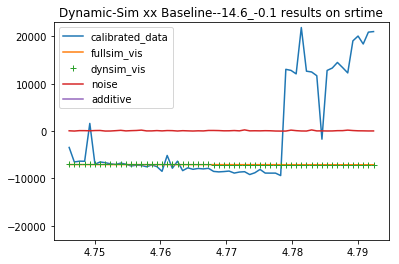

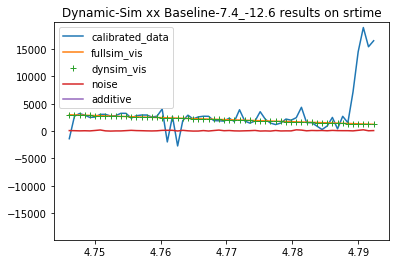

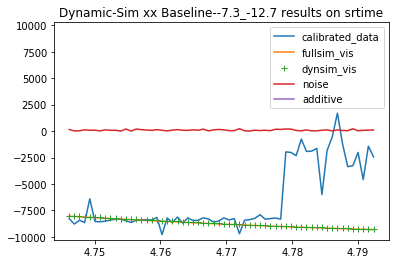

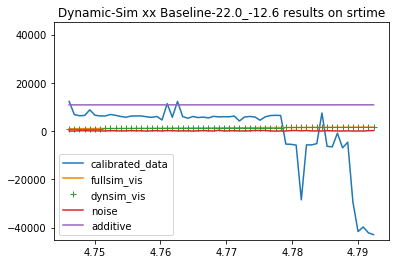

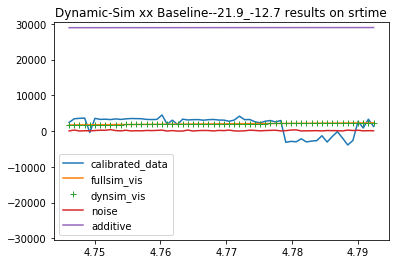

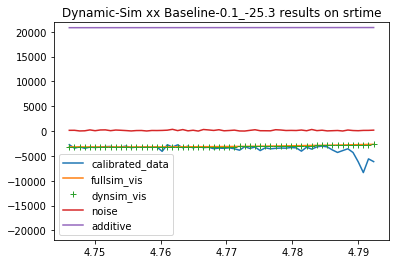

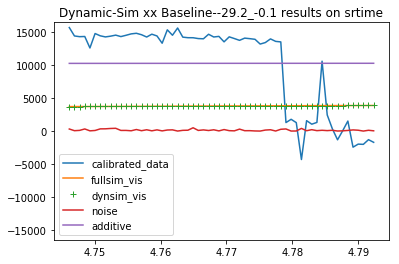

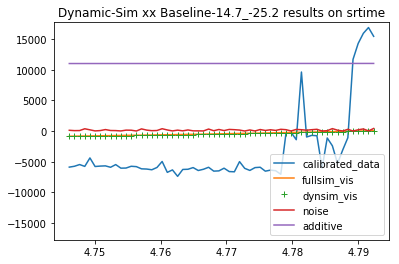

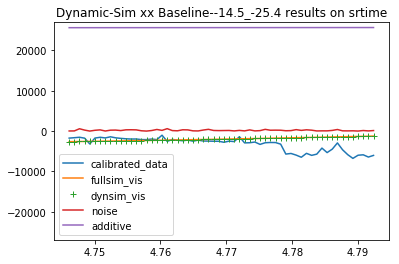

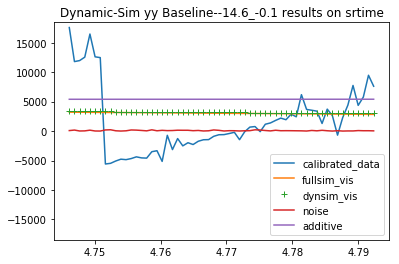

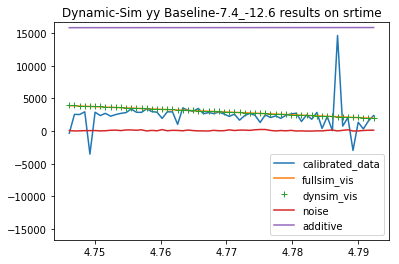

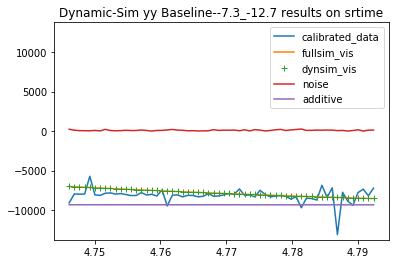

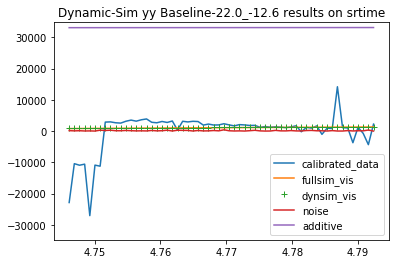

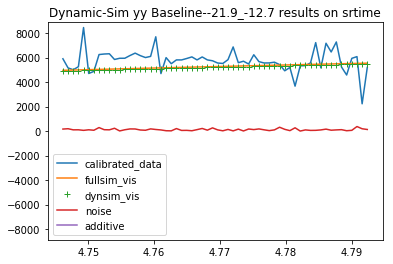

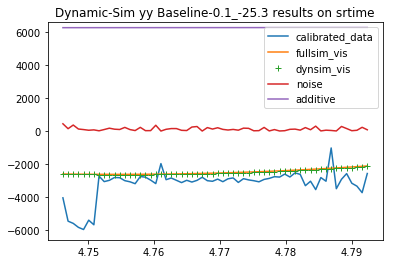

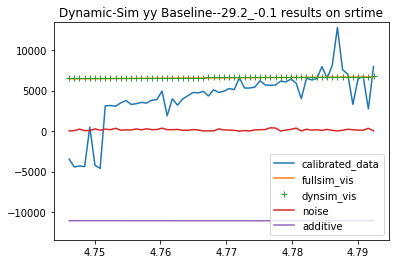

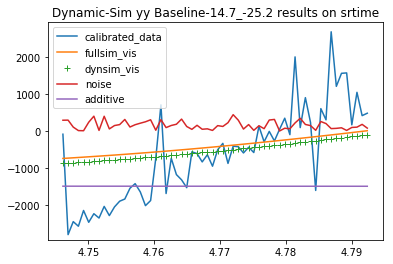

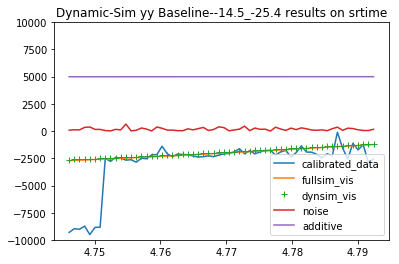

total deviation between dynamic and full sim compared to sim:  0.004945533540446285
total deviation between dynamic and full sim compared to data noise:  (0.3307161047636813+0j)


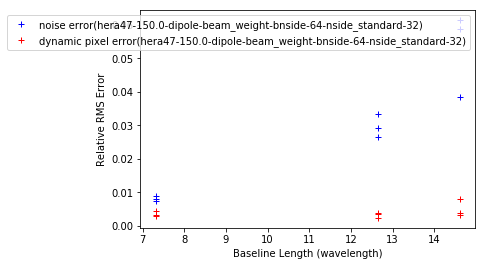

Normalization from visibilities 1.1026783028569556


In [48]:
##############
# simulate visibilities according to the pixelized A matrix
##############
clean_sim_data = A.dot(fake_solution.astype(A.dtype))

if plot_data_error:
	cdata = get_complex_data(data)
	cdynamicmodel = get_complex_data(clean_sim_data)
	cNi = get_complex_data(Ni)
	if pre_calibrate:
		cadd = get_complex_data(additive_term)

	fun = np.imag
	srt = sorted((lsts - lst_offset)%24.+lst_offset)
	asrt = np.argsort((lsts - lst_offset)%24.+lst_offset)
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x']
	#plt.clf()
#	plt.figure(60)
#	for p in range(2):
#		for nu, u in enumerate(us):
#
#			plt.subplot(2, len(us), len(us) * p + nu + 1)
#			plt.plot(srt, fun(cdata[u, p][asrt]))
#			plt.plot(srt, fun(fullsim_vis[u, p][asrt]))
#			plt.plot(srt, fun(cdynamicmodel[u, p][asrt]))
#			plt.plot(srt, fun(cNi[u, p][asrt])**-.5)
#			if pre_calibrate:
#				plt.plot(srt, fun(cadd[u, p][asrt]))
#			data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), 5 * np.max(np.abs(fun(cNi[u, p])))])
#			plt.title("%.1f,%.1f"%(used_common_ubls[u, 0], used_common_ubls[u, 1]))
#			plt.ylim([-1.05*data_range, 1.05*data_range])
#
#	print "total deviation between dynamic and full sim compared to sim", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
#	print "total deviation between dynamic and full sim compared to data noise", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni**-1)**.5
#	plt.savefig(script_dir + '/../Output/data_error_dynamic-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
#	plt.show(block=False)
	
	figure_D={}
	for p in range(2):
		for nu, u in enumerate(us):
			plt.figure(6000+100*p+nu)
			#plt.subplot(2, len(us), len(us) * p + nu + 1)
			figure_D[1], = plt.plot(srt, fun(cdata[u, p][asrt]), label='calibrated_data')
			figure_D[2], = plt.plot(srt, fun(fullsim_vis[u, p][asrt]), label='fullsim_vis')
			figure_D[3], = plt.plot(srt, fun(cdynamicmodel[u, p][asrt]), '+', label='dynsim_vis')
			figure_D[4], = plt.plot(srt, fun(cNi[u, p][asrt])**-.5, label='Ni')
			if pre_calibrate:
				figure_D[5], = plt.plot(srt, fun(cadd[u, p][asrt]), label='additive')
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p]))), np.max(fun(cadd[u, p]))]) # 5 * np.max(np.abs(fun(cNi[u, p])))
			else:	
				data_range = np.max([np.max(np.abs(fun(cdata[u, p]))), np.max(np.abs(fun(fullsim_vis[u, p]))), np.max(np.abs(fun(cdynamicmodel[u, p])))]) # 5 * np.max(np.abs(fun(cNi[u, p])))
			plt.title("Dynamic-Sim %s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.ylim([-1.05*data_range, 1.05*data_range])
			if pre_calibrate:
				plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4], figure_D[5]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise', 'additive'], loc=0)
			else:
				plt.legend(handles=[figure_D[1], figure_D[2], figure_D[3], figure_D[4]], labels=['calibrated_data', 'fullsim_vis', 'dynsim_vis', 'noise'], loc=0)
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-Dynamic_Vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			#plt.clf()
			#plt.gcf().clear()
	print "total deviation between dynamic and full sim compared to sim: ", la.norm(fullsim_vis - cdynamicmodel) / la.norm(fullsim_vis)
	print "total deviation between dynamic and full sim compared to data noise: ", la.norm(fullsim_vis - cdynamicmodel) / np.sum(Ni**-1)**.5
	
	plt.figure(70)
	try:
		fullsim_vis2 = 4 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis'%(nUBL_used+1, nt_used, nside_standard / 2, bnside), dtype='complex128').reshape((2, nUBL_used+1, nt_used))[:, :-1].transpose((1, 0 ,2))
		plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, bnside, nside_standard))
		plt.savefig(script_dir + '/../Output/nside_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, bnside, nside_standard))
	except:
		try:
			fullsim_vis2 = .25 * np.fromfile(datadir + tag + '_p2_u%i_t%i_nside%i_bnside%i.simvis'%(nUBL_used+1, nt_used, nside_standard * 2, bnside), dtype='complex128').reshape((2, nUBL_used+1, nt_used))[:, :-1].transpose((1, 0 ,2))
			plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - fullsim_vis2, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'g+', label='nside error(%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, bnside, nside_standard))
			plt.savefig(script_dir + '/../Output/nside_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, bnside, nside_standard))
		except:
			pass
	#plt.clf()
	plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, np.sum(2. / np.real(get_complex_data(Ni)), axis=-1)[:, 0]**.5 / la.norm(fullsim_vis, axis=-1)[:, 0], 'b+', label='noise error(%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
#	plt.legend()
#	plt.xlabel('Baseline Length (wavelength)')
#	plt.ylabel('Relative RMS Error')
	plt.savefig(script_dir + '/../Output/noise_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
#	plt.show(block=False)
#	plt.gcf().clear()
	#plt.clf()
	plt.plot(la.norm(used_common_ubls, axis=-1)*freq/C, la.norm(fullsim_vis - cdynamicmodel, axis=-1)[:, 0] / la.norm(fullsim_vis, axis=-1)[:, 0], 'r+', label='dynamic pixel error(%s-%s-dipole-beam_weight-bnside-%s-nside_standard-%s)'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.legend(loc=0)
	plt.xlabel('Baseline Length (wavelength)')
	plt.ylabel('Relative RMS Error')
	plt.savefig(script_dir + '/../Output/dynamic_pixel_error-%s-dipole-beam_weight-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()


vis_normalization = get_vis_normalization(data, stitch_complex_data(fullsim_vis))
print "Normalization from visibilities", vis_normalization

Del=True
if Del:
	try:
		del(cdata)
		del(cNi)
		del(cdynamicmodel)
	except:
		pass

sys.stdout.flush()



In [49]:
##renormalize the model
fake_solution *= vis_normalization # GSM Masked and being Normalized (abs calibration), Clean
clean_sim_data *= vis_normalization # Dynamic Simulated, Clean, being Normalized (abs calibration)
fullsim_vis *= vis_normalization # Full Simulated, Clean, being Normalized (abs calibration)
sim_data = stitch_complex_data(fullsim_vis) + np.random.randn(len(data)) / Ni ** .5 # Full Simulated, being Normalized (abs calibration), Noise
# "data" is Calibrated Full Simulated Visibilities

#add additive term
if fit_for_additive:
	sim_data.shape = (2, nUBL_used, 2, nt_used)
	sim_additive = np.random.randn(2, nUBL_used, 2) * np.median(np.abs(data)) / 2.
	sim_data = sim_data + np.array([np.outer(sim_additive[..., p], autocorr_vis_normalized[p]).reshape((2, nUBL_used, nt_used)) for p in range(2)]).transpose((1, 2, 0, 3))#sim_additive[..., None]
	sim_data = sim_data.flatten()


In [50]:
# compute AtNi.y
AtNi_data = np.transpose(A).dot((data * Ni).astype(A.dtype))
AtNi_sim_data = np.transpose(A).dot((sim_data * Ni).astype(A.dtype))
AtNi_clean_sim_data = np.transpose(A).dot((clean_sim_data * Ni).astype(A.dtype))


In [51]:
# compute S
print "computing S...",
sys.stdout.flush()
timer = time.time()

#diagonal of S consists of S_diag_I and S-diag_add
if S_type == 'none':
	S_diag = np.ones(Ashape1) * np.max(equatorial_GSM_standard)**2 * 1.e12
else:
	if 'lowI' in S_type:
		I_supress = 25.
	elif 'minI' in S_type:
		I_supress = 250.
	elif 'min2I' in S_type:
		I_supress = 2500
	elif 'min3I' in S_type:
		I_supress = 2.5*1.e4
	elif 'min4I' in S_type:
		I_supress = 2.5*1.e5
	elif 'min5I' in S_type:
		I_supress = 2.5*1.e6
	elif 'min6I' in S_type:
		I_supress = 2.5*1.e7
	elif 'min7I' in S_type:
		I_supress = 2.5*1.e8
	elif 'min8I' in S_type:
		I_supress = 2.5*1.e9
	elif 'min9I' in S_type:
		I_supress = 2.5*1.e10
	elif 'min10I' in S_type:
		I_supress = 2.5*1.e11
	elif 'maxI' in S_type:
		I_supress = 2.5*1.e-1
	elif 'ma2I' in S_type:
		I_supress = 2.5*1.e-2
	elif 'max3I' in S_type:
		I_supress = 2.5*1.e-3
	elif 'max4I' in S_type:
		I_supress = 2.5*1.e-4
	elif 'max5I' in S_type:
		I_supress = 2.5*1.e-5
	elif 'max6I' in S_type:
		I_supress = 2.5*1.e-6
	elif 'max7I' in S_type:
		I_supress = 2.5*1.e-7
	elif 'max8I' in S_type:
		I_supress = 2.5*1.e-8
	elif 'max9I' in S_type:
		I_supress = 2.5*1.e-9
	else:
		I_supress = 1.
		
	if 'Iuniform' in S_type:
		S_diag_I = (np.median(equatorial_GSM_standard) * sizes)**2 / I_supress
	else:
		S_diag_I = fake_solution_map ** 2 / I_supress  # np.array([[1+pol_frac,0,0,1-pol_frac],[0,pol_frac,pol_frac,0],[0,pol_frac,pol_frac,0],[1-pol_frac,0,0,1+pol_frac]]) / 4 * (2*sim_x_clean[i])**2

	data_max = np.transpose(np.percentile(np.abs(data.reshape((2, nUBL_used, 2, nt_used))), 95, axis=-1), (1, 2, 0)).flatten()
	if 'min2add' in S_type:
		add_supress = 1000000.
	elif 'minadd' in S_type:
		add_supress = 10000.
	elif 'lowadd' in S_type:
		add_supress = 100.
	else:
		add_supress = 1

	if 'adduniform' in S_type:
		S_diag_add = np.ones(nUBL_used * 4) * np.median(data_max)**2 / add_supress
	else:
		S_diag_add = data_max**2 / add_supress

	if not fit_for_additive:
		S_diag = S_diag_I.astype('complex128')
	else:
		S_diag = np.concatenate((S_diag_I, S_diag_add)).astype('complex128')
	print "Done."
	print "%f minutes used" % (float(time.time() - timer) / 60.)
	sys.stdout.flush()


computing S... Done.
0.000051 minutes used


In [52]:
# compute (AtNiA+Si)i
precision = 'complex128'
AtNiAi_tag = 'AtNiASii'
if not fit_for_additive:
	AtNiAi_version = 0.3
elif crosstalk_type == 'autocorr':
	AtNiAi_version = 0.2
else:
	AtNiAi_version = 0.1
if pre_ampcal:
	AtNiAi_version += 1.
rcond_list = 10.**np.arange(-9., -2., 1.)

AtNiAi_candidate_files = glob.glob(datadir + tag + AtNiAi_tag + '_S%s_RE*_N%s_v%.1f'%(S_type, vartag, AtNiAi_version) + A_filename)
if len(AtNiAi_candidate_files) > 0 and not force_recompute_AtNiAi and not force_recompute and not force_recompute_S and not AtNiA_only:
	rcond = 10**min([float(fn.split('_RE')[1].split('_N')[0]) for fn in AtNiAi_candidate_files])

	AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f'%(S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
	AtNiAi_path = datadir + tag + AtNiAi_filename

	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)
else:
	if os.path.isfile(AtNiA_path) and not force_recompute:
		print "Reading AtNiA...",
		sys.stdout.flush()
		AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))
	else:
		print "Allocating AtNiA..."
		sys.stdout.flush()
		timer = time.time()
		AtNiA = np.zeros((A.shape[1], A.shape[1]), dtype=precision)
		print "Computing AtNiA...", datetime.datetime.now()
		sys.stdout.flush()
		ATNIA(A, Ni, AtNiA)
		print "%f minutes used" % (float(time.time() - timer) / 60.)
		sys.stdout.flush()
		AtNiA.tofile(AtNiA_path)
	if AtNiA_only:
		sys.exit(0)
	del (A)
	AtNiA_diag = np.diagonal(AtNiA)
	print "Computing Regularized AtNiAi, %s, expected time %.1f min"%(datetime.datetime.now(), 88. * (len(S_diag) / 4.6e4)**3.),
	sys.stdout.flush()
	timer = time.time()
	# if la.norm(S) != la.norm(np.diagonal(S)):
	#     raise Exception("Non-diagonal S not supported yet")

	for rcond in rcond_list:
		#add Si on top of AtNiA without renaming AtNiA to save memory
		maxAtNiA = np.max(AtNiA)
		AtNiA.shape = (len(AtNiA) ** 2)
		if Add_S_diag:
			AtNiA[::len(S_diag) + 1] += 1./S_diag

		print 'trying', rcond,
		sys.stdout.flush()
		try:
			AtNiAi_filename = AtNiAi_tag + '_S%s_RE%.1f_N%s_v%.1f'%(S_type, np.log10(rcond), vartag, AtNiAi_version) + A_filename
			AtNiAi_path = datadir + tag + AtNiAi_filename
			if Add_Rcond:
				AtNiA[::len(S_diag) + 1] += maxAtNiA * rcond
			AtNiA.shape = (Ashape1, Ashape1)
			AtNiAi = sv.InverseCholeskyMatrix(AtNiA).astype(precision)
			del(AtNiA)
			AtNiAi.tofile(AtNiAi_path, overwrite=True)
			print "%f minutes used" % (float(time.time() - timer) / 60.)
			print "regularization stength", (maxAtNiA * rcond)**-.5, "median GSM ranges between", np.median(equatorial_GSM_standard) * min(sizes), np.median(equatorial_GSM_standard) * max(sizes)
			break
		except:
			AtNiA[::len(S_diag) + 1] -= maxAtNiA * rcond
			continue

sys.stdout.flush()


Allocating AtNiA...
Computing AtNiA... 2018-03-07 19:20:06.462642
Estimated time for A 2160 by 10456 3.06992844288 minutes 0/20: 0.0mins 1/20: 0.0mins 2/20: 0.0mins 3/20: 0.0mins 4/20: 0.0mins 5/20: 0.0mins 6/20: 0.0mins 7/20: 0.0mins 8/20: 0.0mins 9/20: 0.0mins 10/20: 0.0mins 11/20: 0.0mins 12/20: 0.0mins 13/20: 0.0mins 14/20: 0.0mins 15/20: 0.0mins 16/20: 0.0mins 17/20: 0.0mins 18/20: 0.0mins 19/20: 0.0mins 0.580670 minutes used
Computing Regularized AtNiAi, 2018-03-07 19:20:43.900452, expected time 1.0 min trying 1e-09 0.716441 minutes used
regularization stength (9.226288534167486+0j) median GSM ranges between 284.4070430340813 284.4070430340813


In [53]:
S_type
I_supress

0.25

Applying Regularized AtNiAi... Memory usage: 5706973.000MB
Reading A matrix from /Users/JianshuLi/anaconda3/envs/Cosmology-Python27/lib/python2.7/site-packages/hera_cal-1.0-py2.7.egg/hera_cal/data/../../../simulate_visibilities/scripts/../Output/hera47-150.000000-ampcal-A_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0


Casting complex values to real discards the imaginary part


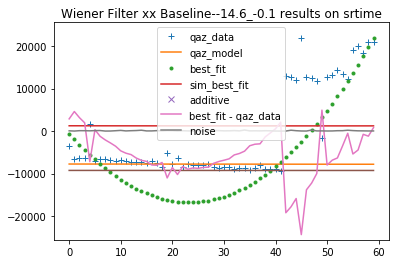

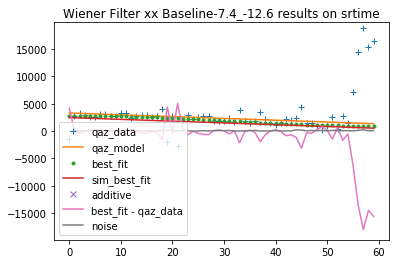

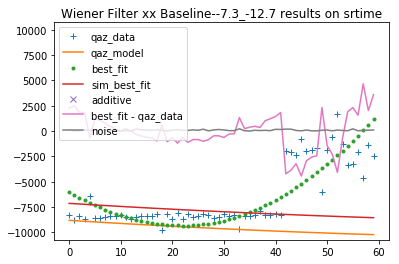

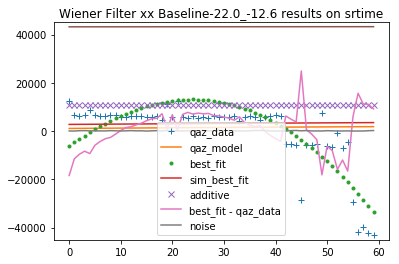

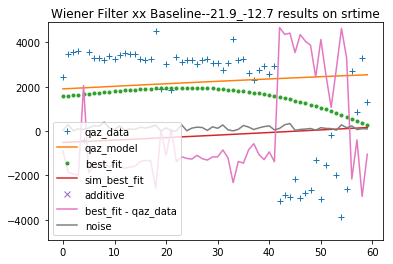

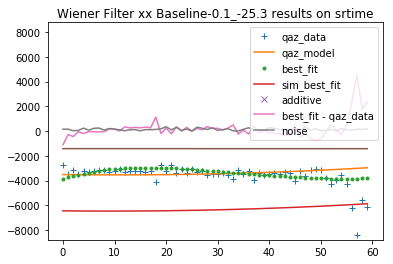

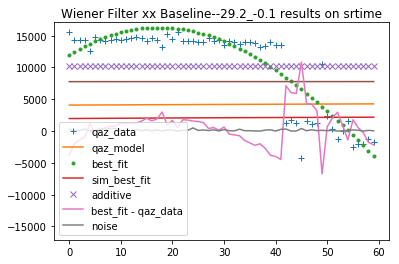

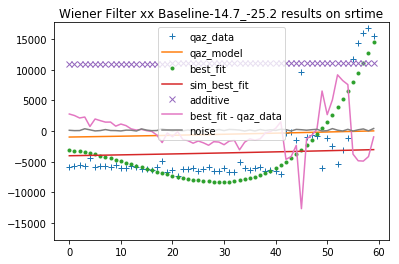

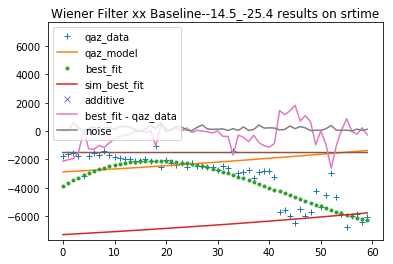

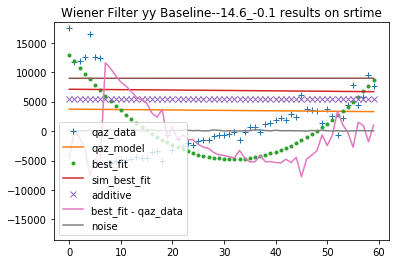

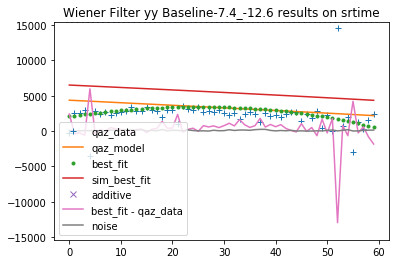

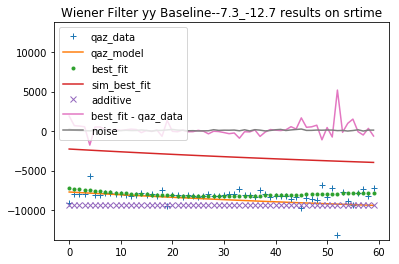

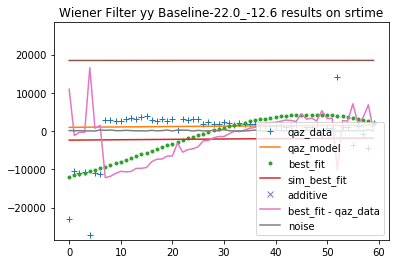

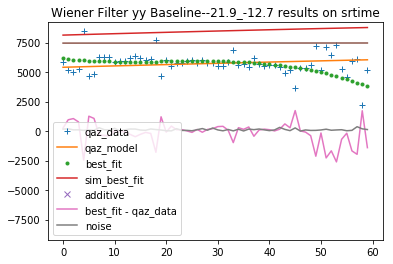

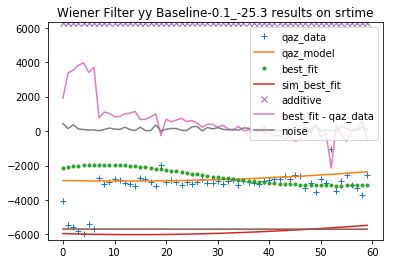

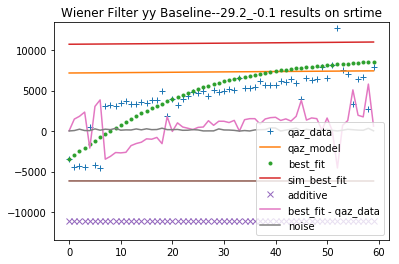

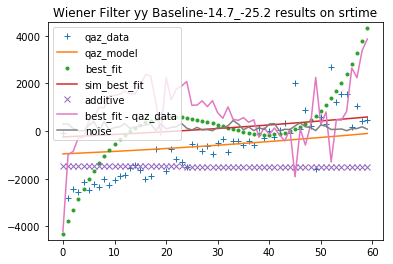

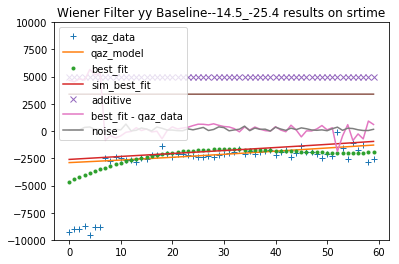

In [54]:
#####apply wiener filter##############
print "Applying Regularized AtNiAi...",
sys.stdout.flush()
w_solution = AtNiAi.dotv(AtNi_data)
w_GSM = AtNiAi.dotv(AtNi_clean_sim_data)
w_sim_sol = AtNiAi.dotv(AtNi_sim_data)
print "Memory usage: %.3fMB" % (resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1000)
sys.stdout.flush()

del (AtNiAi)

if not fit_for_additive:
	A = get_A()
else:
	A = get_A(additive_A)
	
best_fit = A.dot(w_solution.astype(A.dtype)) # Reversely-Calculated-masked-GSM Dynamically simulated Visibilities.
best_fit_no_additive = A[..., :valid_npix].dot(w_solution[:valid_npix].astype(A.dtype))

sim_best_fit = A.dot(w_sim_sol.astype(A.dtype))
sim_best_fit_no_additive = A[..., :valid_npix].dot(w_sim_sol[:valid_npix].astype(A.dtype))

if plot_data_error:
	qaz_model = (clean_sim_data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]) # Dynamic Simulated, Clean, being Normalized    # * vis_normalization
	qaz_data = np.copy(data).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1]) # Full Simulated, Calibrated, reference for normalization
	if pre_calibrate:
		qaz_add = np.copy(additive_term).reshape(2, data_shape['xx'][0], 2, data_shape['xx'][1])
	pncol = min(int(60. / (srt[-1] - srt[0])), 12)
	us = ubl_sort['x'][::len(ubl_sort['x'])/pncol] if len(ubl_sort['x'])/pncol >=1 else ubl_sort['x'] #[::max(1, len(ubl_sort['x'])/70)]
	best_fit.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	best_fit_no_additive.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	sim_best_fit.shape = (2, data_shape['xx'][0], 2, data_shape['xx'][1])
	ri = 1
	#plt.clf()

	figure_W = {}
	for p in range(2):
		
		for nu, u in enumerate(us):
			plt.figure(8000 + 10*p + nu)
			#plt.subplot(6, (len(us) + 5) / 6, nu + 1)
			# plt.errorbar(range(nt_used), qaz_data[ri, u, p], yerr=Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
			figure_W[1], = plt.plot(qaz_data[ri, u, p],'+')
			figure_W[2], = plt.plot(qaz_model[ri, u, p],'-')
			figure_W[3], = plt.plot(best_fit[ri, u, p],'.')
			figure_W[4], = plt.plot(sim_best_fit[ri, u, p])
			if pre_calibrate:
				figure_W[5], = plt.plot(qaz_add[ri, u, p],'x')
			if fit_for_additive:
				figure_W[6], = plt.plot(autocorr_vis_normalized[p] * sol2additive(w_solution)[p, u, ri])
			figure_W[7], = plt.plot(best_fit[ri, u, p] - qaz_data[ri, u, p])
			figure_W[8], = plt.plot(Ni.reshape((2, nUBL_used, 2, nt_used))[ri, u, p]**-.5)
			if pre_calibrate:
				data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])), np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(sim_best_fit[ri, u, p])), np.max(np.abs((best_fit[ri, u, p] - qaz_data[ri, u, p])))]) # np.max(np.abs(qaz_add[ri, u, p])), #, 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.legend(handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[5], figure_W[7], figure_W[8]], labels=['qaz_data', 'qaz_model', 'best_fit', 'sim_best_fit', 'additive', 'best_fit - qaz_data', 'noise'], loc=0)
			else:
				data_range = np.max([np.max(np.abs(qaz_data[ri, u, p])), np.max(np.abs(qaz_model[ri, u, p])), np.max(np.abs(best_fit[ri, u, p])), np.max(np.abs(sim_best_fit[ri, u, p])), np.max(np.abs((best_fit[ri, u, p] - qaz_data[ri, u, p])))]) #, 5 * np.max(np.abs(fun(cNi[u, p])))
				plt.legend(handles=[figure_W[1], figure_W[2], figure_W[3], figure_W[4], figure_W[7], figure_W[8]], labels=['qaz_data', 'qaz_model', 'best_fit', 'sim_best_fit', 'best_fit - qaz_data', 'noise'], loc=0)
			plt.ylim([-1.05*data_range, 1.05*data_range])
			#plt.title("%.1f,%.1f,%.1e"%(used_common_ubls[u, 0], used_common_ubls[u, 1], la.norm(best_fit[ri, u, p] - qaz_data[ri, u, p])))
			plt.title("Wiener Filter %s Baseline-%.1f_%.1f results on srtime"%(['xx','yy'][p], used_common_ubls[u, 0], used_common_ubls[u, 1]))
			plt.savefig(script_dir + '/../Output/%s-Baseline-%.1f_%.1f-dipole-precal_data_error-WienerFilter_Vis-%s-%.2f-bnside-%s-nside_standard-%s.pdf'%(INSTRUMENT, used_common_ubls[u, 0], used_common_ubls[u, 1], ['xx','yy'][p], freq, bnside, nside_standard))
			plt.show(block=False)
			#plt.gcf().clear()
			#plt.close()

# Del=True
# if Del:
# 	try:
# 		#del(additive_A)
# 		#del(real_additive_A)
# 	except:
# 		pass

sys.stdout.flush()

In [55]:
def plot_IQU(solution, title, col, shape=(2,3), coord='C'):
	# Es=solution[np.array(final_index).tolist()].reshape((4, len(final_index)/4))
	# I = Es[0] + Es[3]
	# Q = Es[0] - Es[3]
	# U = Es[1] + Es[2]
	I = sol2map(solution)
	plotcoordtmp = coord
	hpv.mollview(np.log10(I), min=0, max=4, coord=plotcoordtmp, title=title, nest=True, sub=(shape[0], shape[1], col))
	#if col == shape[0] * shape[1]:
		#plt.show(block=False)

def plot_IQU_unlimit(solution, title, col, shape=(2,3), coord='C'):
	# Es=solution[np.array(final_index).tolist()].reshape((4, len(final_index)/4))
	# I = Es[0] + Es[3]
	# Q = Es[0] - Es[3]
	# U = Es[1] + Es[2]
	I = sol2map(solution)
	plotcoordtmp = coord
	hpv.mollview(np.log10(I), coord=plotcoordtmp, title=title, nest=True, sub=(shape[0], shape[1], col))
	#if col == shape[0] * shape[1]:
		#plt.show(block=False)


In [56]:
rescale_factor = np.max(np.abs(fake_solution))/ np.max(np.abs(w_solution))

In [57]:
%matplotlib inline

In [58]:
print('Number of Positive w_solution Pixels: %s'%len(w_solution[w_solution>=0]))
print('Number of Positive w_GSM Pixels: %s'%len(w_GSM[w_GSM>=0]))
print('Number of Positive w_sim Pixels: %s'%len(w_sim_sol[w_sim_sol>=0]))
print('Number of Positive GSM Pixels: %s'%len(fake_solution[fake_solution>=0]))

Number of Positive w_solution Pixels: 5428
Number of Positive w_GSM Pixels: 6084
Number of Positive w_sim Pixels: 5804
Number of Positive GSM Pixels: 10456


divide by zero encountered in log10


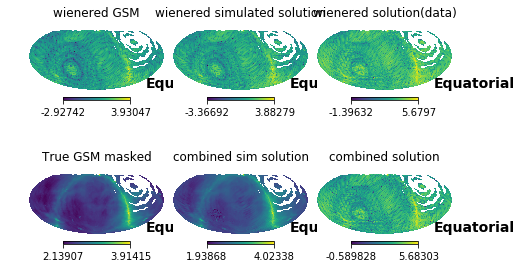

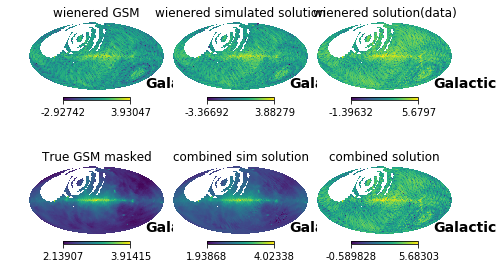

In [59]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(900 + crd)
	crd += 10
	plot_IQU_unlimit(np.abs(w_GSM), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit(np.abs(w_sim_sol), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit(np.abs(w_sim_sol - w_GSM + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit(np.abs(w_solution - w_GSM + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	#plt.show(block=False)
	#plt.gcf().clear()
	


divide by zero encountered in log10


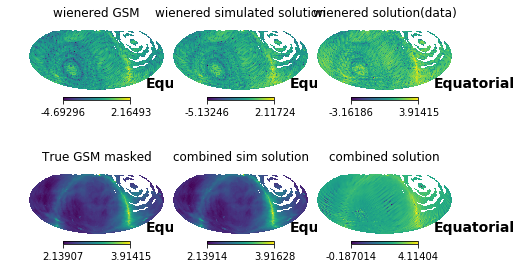

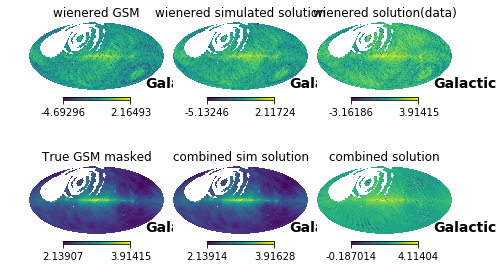

In [60]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9000000 + crd)
	crd += 10
	plot_IQU_unlimit(np.abs(w_GSM) * rescale_factor, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit(np.abs(w_sim_sol) * rescale_factor, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit(np.abs(w_solution) * rescale_factor, 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit(np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit(np.abs((w_solution - w_GSM) * rescale_factor + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()
	

divide by zero encountered in log10


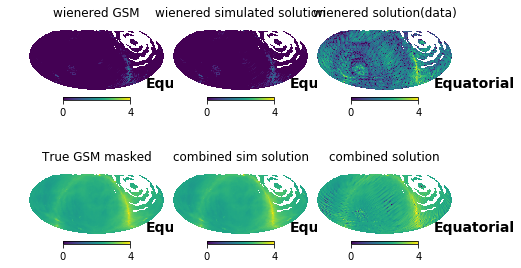

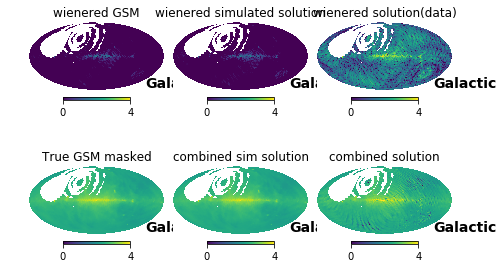

In [61]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9500000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM) * rescale_factor, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol) * rescale_factor, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution) * rescale_factor, 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs((w_solution - w_GSM) * rescale_factor + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


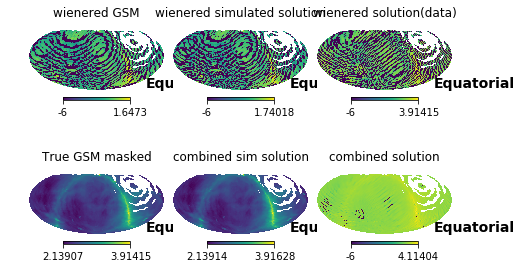

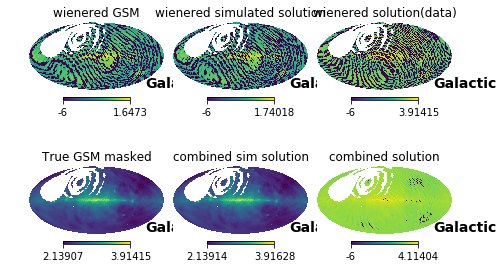

In [62]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(950 + crd)
	crd += 10
	plot_IQU_unlimit((w_GSM + np.abs(w_GSM))*0.5 * rescale_factor + 1.e-6, 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU_unlimit((w_sim_sol + np.abs(w_sim_sol))*0.5 * rescale_factor + 1.e-6, 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU_unlimit((w_solution + np.abs(w_solution))*0.5 * rescale_factor + 1.e-6, 'wienered solution(data)', 3, coord=coord)
	plot_IQU_unlimit((fake_solution + np.abs(fake_solution))*0.5 + 1.e-6, 'True GSM masked', 4, coord=coord)
	plot_IQU_unlimit((((w_sim_sol - w_GSM) * rescale_factor + fake_solution) + np.abs((w_sim_sol - w_GSM) * rescale_factor + fake_solution))*0.5 + 1.e-6, 'combined sim solution', 5, coord=coord)
	plot_IQU_unlimit((((w_solution - w_GSM) * rescale_factor + fake_solution) + np.abs((w_solution - w_GSM) * rescale_factor + fake_solution))*0.5 + 1.e-6, 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-%s-denegative-unlimit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, rescale_factor, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

divide by zero encountered in log10


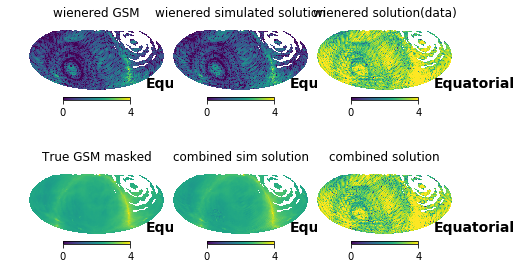

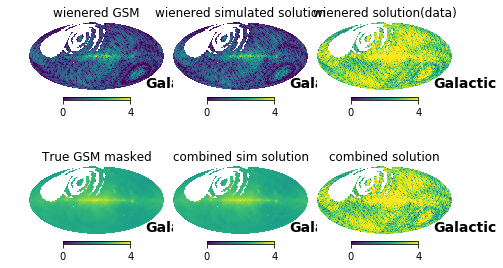

In [63]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(90000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs(w_sim_sol - w_GSM + fake_solution), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs(w_solution - w_GSM + fake_solution), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()
	

divide by zero encountered in log10


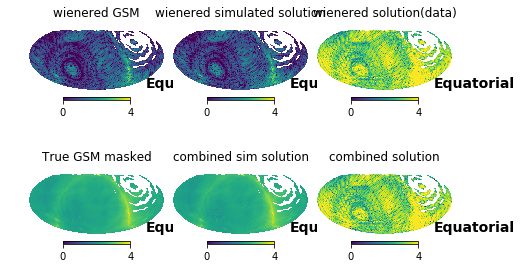

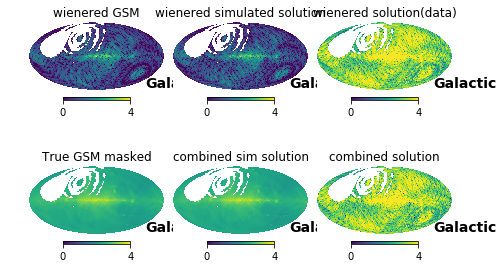

In [64]:
crd = 0
for coord in ['C', 'CG']:
	#plt.clf()
	plt.figure(9000 + crd)
	crd += 10
	plot_IQU(np.abs(w_GSM/vis_normalization), 'wienered GSM', 1, coord=coord) # (clean dynamic_data)
	plot_IQU(np.abs(w_sim_sol/vis_normalization), 'wienered simulated solution', 2, coord=coord) # (~noise+data)
	plot_IQU(np.abs(w_solution), 'wienered solution(data)', 3, coord=coord)
	plot_IQU(np.abs(fake_solution/vis_normalization), 'True GSM masked', 4, coord=coord)
	plot_IQU(np.abs((w_sim_sol - w_GSM + fake_solution)/vis_normalization), 'combined sim solution', 5, coord=coord)
	plot_IQU(np.abs((w_solution - w_GSM + fake_solution)/vis_normalization), 'combined solution', 6, coord=coord)
	plt.savefig(script_dir + '/../Output/results_wiener_renormalized-%s-%s-%sMHz-dipole-bnside-%s-nside_standard-%s-rescale-none-limit-S-%s-recond-%s.png'%(coord, INSTRUMENT, freq, bnside, nside_standard, S_type, rcond if Add_Rcond else 'none'))
	plt.show(block=False)
	#plt.gcf().clear()

chi^2 = 4.521e+07, data points 2160, pixels 10420
re/im chi2 1.074e+07, 3.447e+07
xx/yy chi2 3.801e+07, 7.199e+06


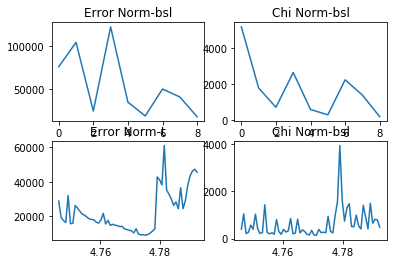

Additive_sol: [0.72314957+0.j 0.7789228 +0.j]
('regularization stength', (9.226288534167486+0j), 'median GSM ranges between', 284.4070430340813, 284.4070430340813)
Rescale_factor: 0.017157589327365705


In [65]:
error = data.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1])) - best_fit
chi = error * (Ni.reshape((2, data_shape['xx'][0], 2, data_shape['xx'][1])))**.5
print "chi^2 = %.3e, data points %i, pixels %i"%(la.norm(chi)**2, len(data), valid_npix)
print "re/im chi2 %.3e, %.3e"%(la.norm(chi[0])**2, la.norm(chi[1])**2)
print "xx/yy chi2 %.3e, %.3e"%(la.norm(chi[:, :, 0])**2, la.norm(chi[:, :, 1])**2)
#plt.clf()
plt.figure(120)
plt.subplot(2, 2, 1)
plt.plot([la.norm(error[:, u]) for u in ubl_sort['x']])
plt.title('Error Norm-bsl')
plt.subplot(2, 2, 2)
plt.plot([la.norm(chi[:, u]) for u in ubl_sort['x']])
plt.title('Chi Norm-bsl')
plt.subplot(2, 2, 3)
plt.plot(lsts, [la.norm(error[..., t]) for t in range(error.shape[-1])])
plt.title('Error Norm-t')
plt.subplot(2, 2, 4)
plt.plot(lsts, [la.norm(chi[..., t]) for t in range(error.shape[-1])])
plt.title('Chi Norm-bsl')
plt.savefig(script_dir + '/../Output/chi-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, freq, bnside, nside_standard))
plt.show(block=False)
#plt.gcf().clear()

try:
	print('Additive_sol: %s' %additive_sol[:2])
	print ("regularization stength", (maxAtNiA * rcond)**-.5, "median GSM ranges between", np.median(equatorial_GSM_standard) * min(sizes), np.median(equatorial_GSM_standard) * max(sizes))
	print('Rescale_factor: %s'%rescale_factor)
except:
	pass	


sys.stdout.flush()

In [66]:
#S_type = 'none'
#point spread function:
if True and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)

	AtNiA_tag = 'AtNiA_N%s'%vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))

	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	#plt.clf()
	plt.figure(130)
	for theta in np.arange(0, PI*.9, PI/6.):
		for phi in np.arange(0, TPI, PI/3.):
			iplot += 1
			choose_plots = [1, 12, 24]
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')

				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				#rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI/2-fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is (): 
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]#should print 1.57079632679 0.0 if rotation is working correctly


				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset)%TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis) 
				hpv.mollview(np.log10(np.abs(spreaded)), min=-3, max=0, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
	plt.savefig(script_dir + '/../Output/spreaded_function-CG-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, freq, bnside, nside_standard))
	plt.show(block=False)
	#plt.gcf().clear()

In [67]:
print AtNiA_filename
print A_filename
print AtNiA_tag

AtNiA_N_2018__autocorr_ampcalA_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0
A_dI_u9_t60_p10420_n32_32_b64_2.000_v1.0
AtNiA_N_2018__autocorr_ampcal


Reading Regularized AtNiAi... Reading AtNiA...

Casting complex values to real discards the imaginary part
divide by zero encountered in log10


 1.5707963267948966 2.9228940278547097e-33


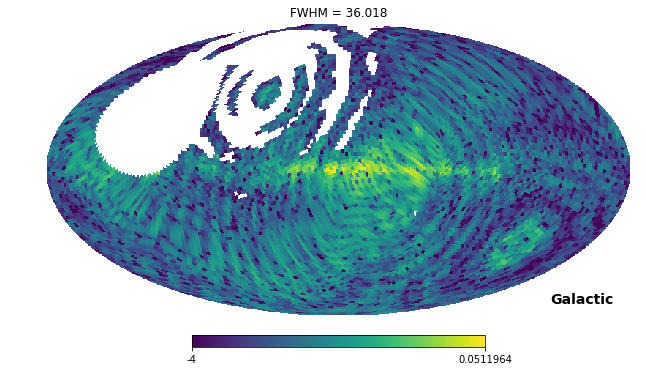

1.5707963267948966 4.2334564159933844e-19


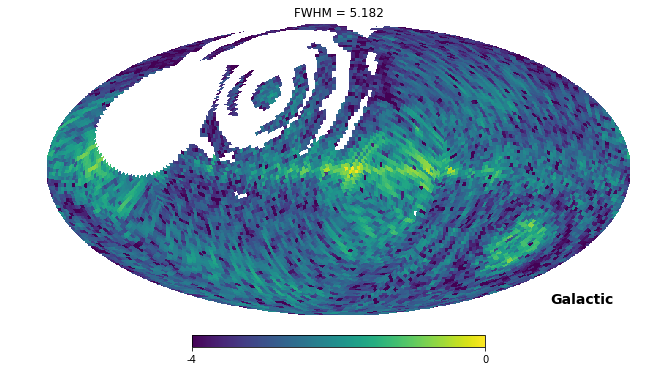

1.5707963267948966 -8.771105757010978e-19


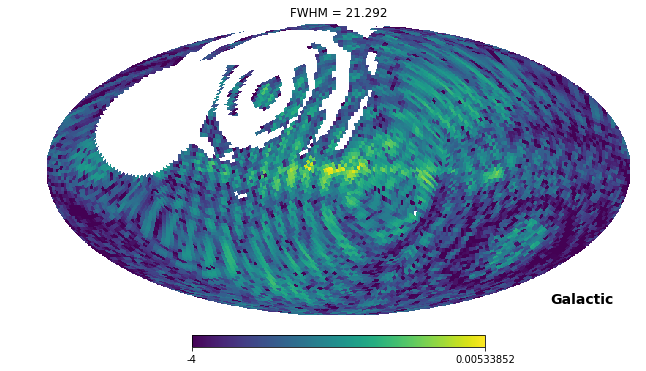

1.5707963267948966 2.9228940278547097e-33


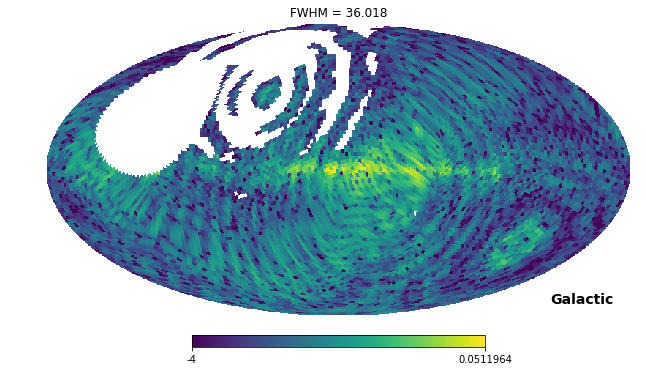

1.5707963267948966 1.0698877043520681e-17


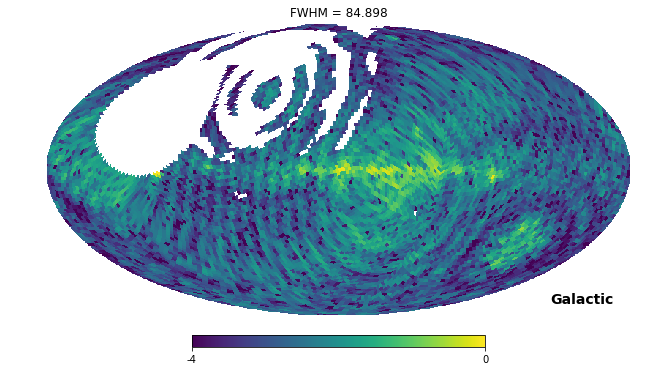

1.5707963267948966 3.885494424521741e-18


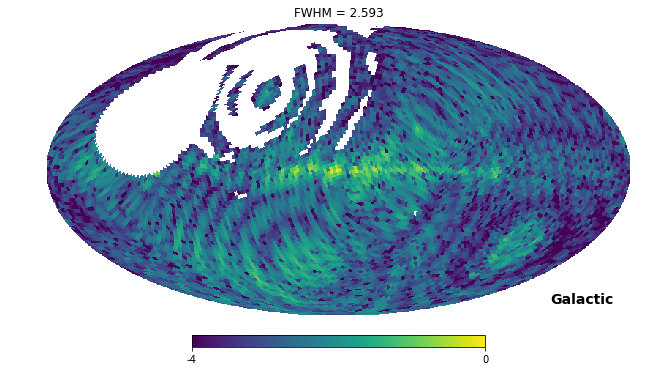

1.5707963267948966 1.5514817053803626e-17


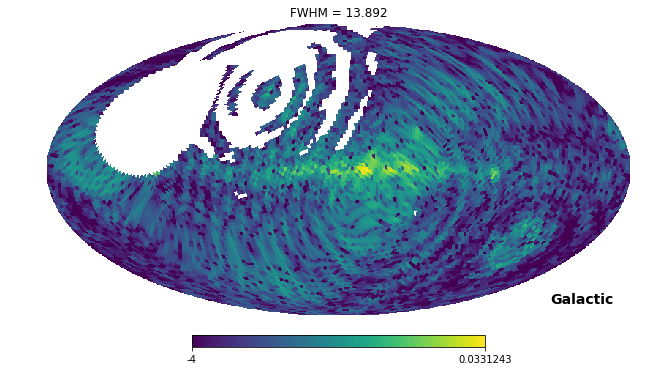

1.5707963267948966 8.746498611567823e-18


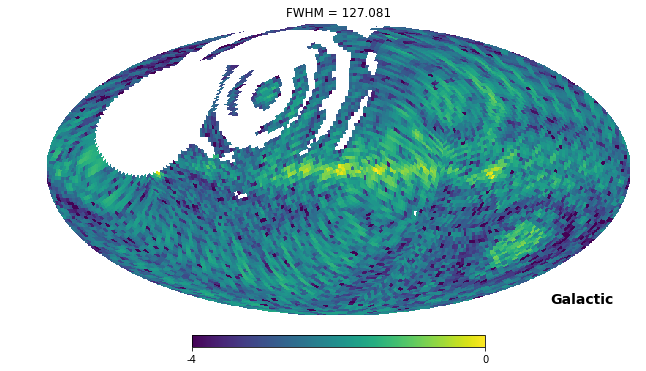

1.5707963267948966 6.938893903907228e-18


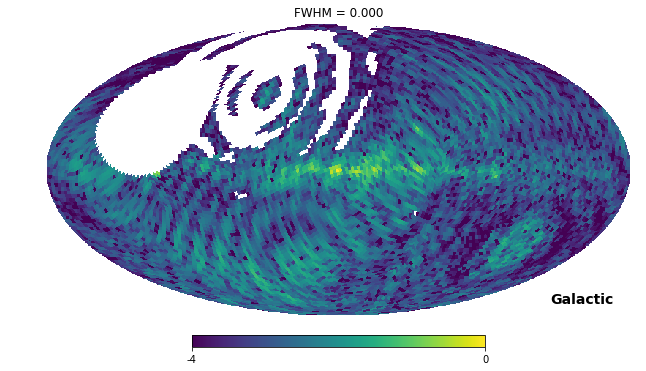

1.5707963267948966 4.106899497426809e-18


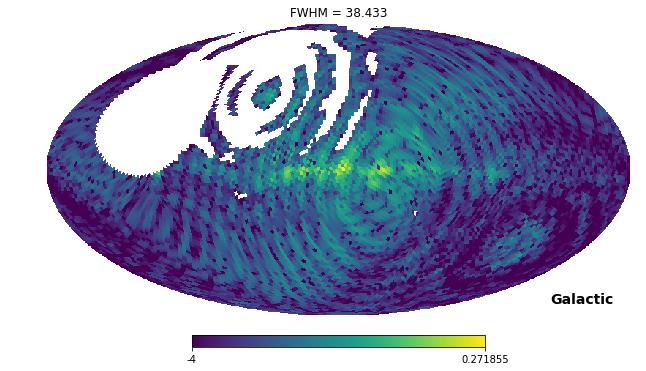

1.5707963267948963 7.693720365562387e-18


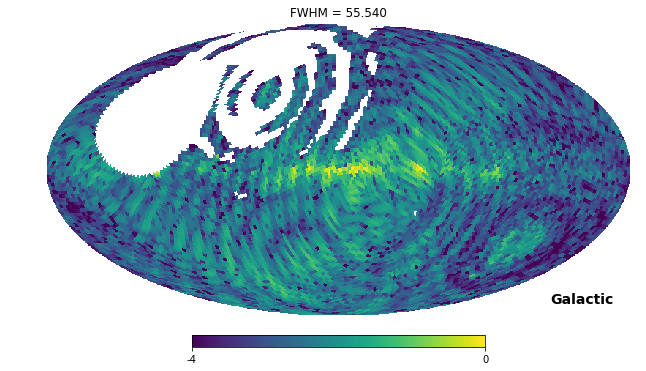

1.5707963267948966 3.885494424521741e-18


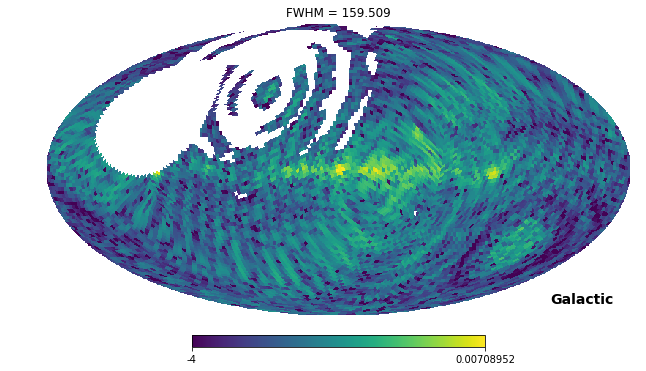

1.5707963267948966 -2.2987347103069353e-17


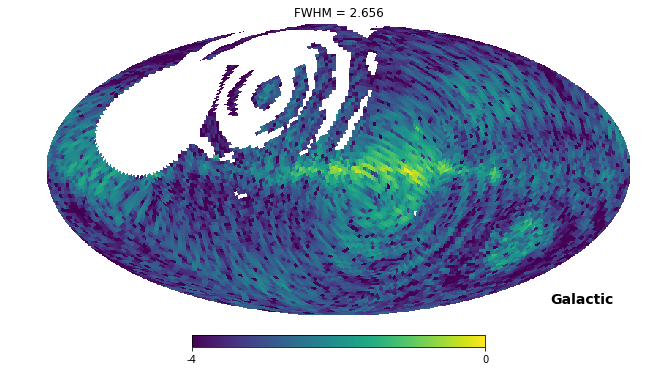

1.5707963267948966 2.9228940278547097e-33


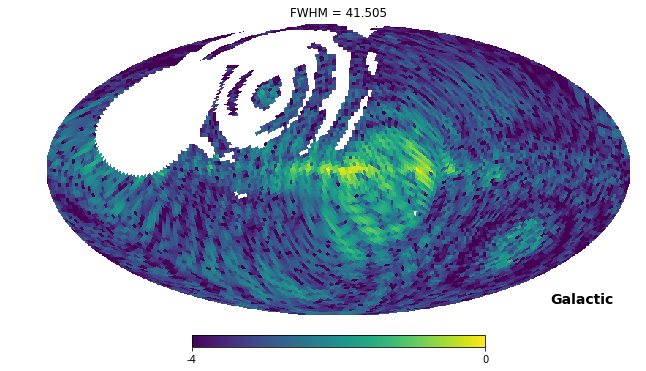

In [68]:
#S_type = 'none'
#point spread function:
if True:# and S_type == 'none':
	print "Reading Regularized AtNiAi...",
	sys.stdout.flush()
	AtNiAi = sv.InverseCholeskyMatrix.fromfile(AtNiAi_path, len(S_diag), precision)

	AtNiA_tag = 'AtNiA_N%s'%vartag
	if not fit_for_additive:
		AtNiA_tag += "_noadd"
	elif crosstalk_type == 'autocorr':
		AtNiA_tag += "_autocorr"
	if pre_ampcal:
		AtNiA_tag += "_ampcal"
	AtNiA_filename = AtNiA_tag + A_filename
	AtNiA_path = datadir + tag + AtNiA_filename
	print "Reading AtNiA...",
	sys.stdout.flush()
	AtNiA = np.fromfile(AtNiA_path, dtype=precision).reshape((Ashape1, Ashape1))

	iplot = 0
	valid_thetas_phis = np.array(zip(thetas, phis))
	full_thetas, full_phis = hpf.pix2ang(nside_standard, range(hpf.nside2npix(nside_standard)), nest=True)
	#plt.clf()
	
	for theta in np.arange(0, PI*.9, PI/6.):
		for phi in np.arange(0, TPI, PI/3.):
			
			#choose_plots = [1, 6, 12, 18, 24, 30]
			choose_plots = [0, 1, 4, 6, 8, 12, 16, 20, 24, 28, 30, 32, 33, 35]
			
			if iplot in choose_plots:
				np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))
				point_vec = np.zeros_like(fake_solution).astype('complex128')

				point_vec[np.argmin(la.norm(valid_thetas_phis - [theta, phi], axis=-1))] = 1
				spreaded = sol2map(AtNiAi.dotv(AtNiA.dot(point_vec)))
				spreaded /= np.max(spreaded)
				fwhm_mask = np.abs(spreaded) >= .5
				masked_max_ind = np.argmax(spreaded[fwhm_mask])
				fwhm_thetas = full_thetas[fwhm_mask]
				fwhm_phis = full_phis[fwhm_mask]
				#rotate angles to center around PI/2 0
				fwhm_thetas, fwhm_phis = hpr.Rotator(rot=[fwhm_phis[masked_max_ind], PI/2-fwhm_thetas[masked_max_ind], 0], deg=False)(fwhm_thetas, fwhm_phis)
				if np.array(fwhm_thetas).shape is (): 
					fwhm_thetas = np.array([fwhm_thetas])
					fwhm_phis = np.array([fwhm_phis])
				print fwhm_thetas[masked_max_ind], fwhm_phis[masked_max_ind]#should print 1.57079632679 0.0 if rotation is working correctly


				fwhm_theta = max(fwhm_thetas) - min(fwhm_thetas)
				phi_offset = fwhm_phis[masked_max_ind] - PI
				fwhm_phis = (fwhm_phis - phi_offset)%TPI + phi_offset
				fwhm_phi = max(fwhm_phis) - min(fwhm_phis)
				plt.figure(1300+iplot) 
				#hpv.mollview(np.log10(np.abs(spreaded)), min=-3, max=0, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI), sub=(len(choose_plots), 1, choose_plots.index(iplot)+1))
				hpv.mollview(np.log10(np.abs(spreaded)), min=-4, nest=True, coord='CG', title='FWHM = %.3f'%((fwhm_theta*fwhm_phi)**.5*180./PI))
				plt.savefig(script_dir + '/../Output/spreaded_function-CG-%s-%s-%s-dipole-bnside-%s-nside_standard-%s.png'%(INSTRUMENT, iplot, freq, bnside, nside_standard))
				plt.show(block=False)
				#plt.gcf().clear()
			iplot += 1


sys.stdout.flush()


In [69]:
#point_vec